In [313]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import allel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, cohen_kappa_score, f1_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline


import umap.umap_ as umap

In [5]:
R_SEED = 22
home = os.path.expanduser('~')
directory = os.path.join('Imp_Research','Dataset')

# populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
#               'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
#               'GW','KE','UGgam']

# Using only 12 populations out of 16
populations = ['BFcol','BFgam','AOcol','CIcol','CMgam',
              'GAgam','GHcol','GM','GNgam','GW','KE','UGgam']

# Creating a dictionary of Population names with labels
populations_encoding = {}
for i in range(len(populations)):
    populations_encoding[i] = populations[i]

### Functions to Load and Pre-Process the Datasets

In [80]:
'''
Requirements : NumPy and Scikit-Allel
'''

class FilterSNP():
    def __init__(self,haplotype, POS):
        self.haplotype = haplotype
        self.POS = POS
        self.H = haplotype
        self.P = POS
        self._removed_maf = None
        self._retained_maf = None
        self._retained_ld = None
        self._removed_ld = None
        self._unlinked_POS = None
        
    def all_filters(self, LD_window_size, LD_overlap_step, MBP_start = 1, MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=1):
        print("1.) Selecting Mega Base Pairs")
        self.H,self.P = self.get_haplo_MBP(self.H,self.P,start = MBP_start, end = MBP_end)
        print("MBP selected. Retained Matrix = ", self.H.shape)
        print("2.) Filtering Rare Allels")
        self.H,self.P = self.filter_MAF(self.H,self.P,threshold = MAF_threshold)
        print("3.) Performing LD Pruning")
        self.H,self.P = self.LD_pruning(self.H, self.P, LD_window_size, LD_overlap_step, threshold = LD_threshold, n_iter = LD_iter)
        print("Retained Haplotype Matrix = ", self.H.shape)
        print("Retained Positions Matrix = ",self.P.shape)
        
        return self.H, self.P
        
    # input dimensions for Haplotype matrix (gn) = SNP X n
    def filter_MAF(self,haplo,POS,threshold = 5):
        if threshold >= 50 : 
            print("MAF threshold cannot be more than 49%")
            return
        samples = haplo.shape[1]
        sums = haplo.sum(axis=1)
        maf = self.get_MAF(haplo)
        #indexes = np.where(maf >= threshold*0.01)[0]
        minor = samples*threshold/100
        major = samples*(100-threshold)/100
        # Selects indexes where allels are >threshold or all 0 and all 1.
        indexes = np.where((sums>=minor)& (sums<=major))[0]
        print("Number of SNPs removed = ",len(haplo)-len(indexes))
        print("Retaining = ",len(indexes))
        self._removed_maf = len(haplo)-len(indexes)
        self._retained_maf = len(indexes)
        return np.take(haplo,indexes,0), np.take(POS,indexes,0)

    # Returns : Array of MAF
    # input dimensions for Haplotype matrix (gn) = SNP X n
    def get_MAF(self,haplo):
        samples = haplo.shape[1]
        sums = haplo.sum(axis=1)
        maf = []
        for s in sums:
            if s != samples or s != 0:
                frequency = s/samples
                if frequency > 0.5:
                    maf.append(1-frequency)
                else: 
                    maf.append(frequency)
        return np.array(maf)

    # input dimensions for Haplotype matrix (gn) = SNP X n
    def get_MBP(self,POS,start = 1,end = 37):
        return np.where(POS[np.where(POS>=1e6)]<=37e6)[0]

    # input dimensions for Haplotype matrix (gn) = SNP X n
    def get_haplo_MBP(self,haplotype,POS,start = 1,end = 37):
        index = self.get_MBP(POS,start,end)
        return np.take(haplotype,index,0),np.take(POS,index,0)
    
    # input dimensions for Haplotype matrix (gn) = SNP X n
    def LD_pruning(self, gn, pos, size, step, threshold = .1, n_iter=1):
        removed = 0
        for i in range(n_iter):
            
            # Returns a boolean array. True(1) - SNPs are within threshold (Unliked), False(0) = Linked
            loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
            
            # Counts non-zero elements = No. of unlinked loci or SNPs to retain
            n = np.count_nonzero(loc_unlinked)
            
            # Calculate the number of SNPs to be removed
            n_remove = gn.shape[0] - n
            removed += n_remove
            print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
            
            # Select only the unlinked SNPs, i.e., indexes where value is True(1).
            gn = gn.compress(loc_unlinked, axis=0)
            
            # retaining the indexes preserved
            pos = pos.compress(loc_unlinked)
        self._retained_ld = gn.shape[0]
        self._removed_ld = removed
        self._unlinked_POS = pos
        return gn,pos

In [7]:
'''
Disclaimer : The class is for personal use. It is not aimed for portability or reusability.

Class to load and filter the data from disk.
Object Parameters : 
data_path  -> Path to the data directory

load_pop() : Function to load the data
params : 
Populations -> list or array of population names/filenames
filtered -> boolean, whethere to filter the data or not
combine -> Boolean, to combine the populations (Implement it !!!)

returns : A dictionary of haplotype matrix and Position array
'''

class LoadFilteredPops():
    def __init__(self,data_path = None):
        self.data_path = data_path
        
    def load_pop(self,populations,naming='custom',chromo_arms = ['3R'],filtered = True):
        if self.data_path is None:
            home = os.path.expanduser('~')
            directory = os.path.join('Imp_Research','Dataset')
        Haplo_pop = {}
        POS_pop = {}
        for population in populations:
            for arm in chromo_arms:
                pop_name = population+'.'+arm
                if naming == 'custom':
                    filename = f'Haplotype.POS.{pop_name}.hd5'
                else:
                    filename = population
                if self.data_path is None:
                    data_path = os.path.join(home, directory,"HDF_Dataset", filename)
                else:
                    try:
                        data_path = os.path.join(self.data_path,filename)
                    except:
                        print("Cannot resolve Directory path")
                        exit()
                print(f'------{pop_name}------\n')
                H = pd.read_hdf(data_path,key='Haplotype').astype('int8').to_numpy().astype('int8')
                P = pd.read_hdf(data_path,key='POS').to_numpy()
                
                if filtered:
                    # Uses FilterSNP class for filtering steps
                    datafilter = FilterSNP(H,P)
                    Haplo_pop[pop_name],POS_pop[pop_name] = datafilter.all_filters(LD_window_size = 500,LD_overlap_step = 100,LD_iter = 3)
                else: 
                    Haplo_pop[pop_name],POS_pop[pop_name] = H,P
                del H,P     
        print("Populations loaded !!!")
        return Haplo_pop,POS_pop

    
'''
Function to combine the populations
Input Params
Haplo_all : Dictionary containing Haplotype matrix for populations. Key-> pop name; Value -> matrix.
            Matrix dimensions must be POS x haplotypes.
POS_all : Position array of SNPs
filtered : Boolean, to filter after combining or not.
get_labels : Boolean, to generate labels

returns
Haplo_all : ndarray of n x m dimensions. n = length of POS array; m = sum of haplotypes from all populations.
POS : SNP Position array
labels : list of labels if Labels = []
'''

# def all_filters(self, LD_window_size, LD_overlap_step, MBP_start = 1, 
#                 MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=1):

def combine_pops(H_all,P_all,filtered = True,get_labels = True,LD_window_size = 500, LD_overlap_step = 100,
                 MBP_start = 1, MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=3):
    keys = list(H_all.keys())
    
    # Unpacking the Haplotype matrices of all pops from dictionary
    H = np.array(H_all[keys[0]])
    if len(H_all) > 1:
        for i in range(1,len(H_all)):
            H = np.append(H,H_all[keys[i]],axis=1)
    print('Combined Shape => ',H.shape)
    # Generating Labels if True
    if get_labels:
        label = []
        for each in keys:
            label.extend([each]*len(H_all[each][0]))
                          
    # Returning the combined Haplotype data matrix if Filtered = False
    if filtered == False:
        if get_labels:
            return H,P_all,label
        else:
            return H,p_all
    else:
        # Uses FilterSNP class for filtering steps
        datafilter = FilterSNP(H,P_all)
        H_filtered,POS_filtered = datafilter.all_filters(LD_window_size,LD_overlap_step,MBP_start,MBP_end,
                                                            MAF_threshold,LD_threshold,LD_iter)
        print('Final Filtered Shape = ',H_filtered.shape)
        if get_labels:
            return H_filtered,POS_filtered,label
        else:
            return H_filtered,POS_filtered
        

### Loading Dataset

In [8]:
# Loading dataset into the memory using the custom loader classes above
# Stored into dictionaries

loader = LoadFilteredPops()
Haplo_all, POS_all = loader.load_pop(populations,filtered = False)

------BFcol.3R------

------BFgam.3R------

------AOcol.3R------

------CIcol.3R------

------CMgam.3R------

------GAgam.3R------

------GHcol.3R------

------GM.3R------

------GNgam.3R------

------GW.3R------

------KE.3R------

------UGgam.3R------

Populations loaded !!!


In [310]:
H_allF, POS_allF, pop_labels = combine_pops(Haplo_all,POS_all['BFcol.3R'],filtered = True, MAF_threshold = 3)

Combined Shape =>  (4836295, 2186)
1.) Selecting Mega Base Pairs
iteration 1 retaining 158382 removing 126234 variants
iteration 2 retaining 157263 removing 1119 variants
iteration 3 retaining 157217 removing 46 variants
Retained Haplotype Matrix =  (157217, 2186)
Retained Positions Matrix =  (157217,)
Final Filtered Shape =  (157217, 2186)


#### Downsampling CMgam

In [77]:
H = Haplo_all.copy()

# Find the indexes  of CMgam
cmgam = H['CMgam.3R']
# Retaining only first 100 samples (200 Haplotypes)
H['CMgam.3R'] = cmgam[:,:200]
print('Shape of CMgam: ',H['CMgam.3R'].shape)

Shape of CMgam:  (4836295, 200)


#### Converting Haplotypes into Genotypes

In [58]:
for key in H.keys():
    X = H[key].T
    X_g = []
    for i in range(0,len(X),2):
        X_g.append(X[i]+X[i+1])
    X_g = np.array(X_g)
    H[key] = X_g
    print(f'{key} transformed shape: \t{X_g.shape}')

BFcol.3R transformed shape: 	(75, 4836295)
BFgam.3R transformed shape: 	(92, 4836295)
AOcol.3R transformed shape: 	(78, 4836295)
CIcol.3R transformed shape: 	(71, 4836295)
CMgam.3R transformed shape: 	(100, 4836295)
GAgam.3R transformed shape: 	(69, 4836295)
GHcol.3R transformed shape: 	(55, 4836295)
GM.3R transformed shape: 	(65, 4836295)
GNgam.3R transformed shape: 	(40, 4836295)
GW.3R transformed shape: 	(91, 4836295)
KE.3R transformed shape: 	(48, 4836295)
UGgam.3R transformed shape: 	(112, 4836295)


### Analysis Script

In [73]:
def to_genotype(X):
    Xg = []
    for i in range(0,len(X),2):
        Xg.append(X[i]+X[i+1])
    return np.array(Xg)

def evaluate_classifier(y_true,y_pred):
    test_accuracy = accuracy_score(y_true,y_pred)
    f1w = f1_score(y_true,y_pred,average= 'weighted')
    kappa = cohen_kappa_score(y_true,y_pred)
    return test_accuracy, f1w, kappa

BFcol_BFgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 334)
2.) Filtering Rare Allels
Number of SNPs removed =  3448792
Retaining =  202928
3.) Performing LD Pruning
iteration 1 retaining 117897 removing 85031 variants
iteration 2 retaining 117005 removing 892 variants
iteration 3 retaining 116947 removing 58 variants
Retained Haplotype Matrix =  (116947, 334)
Retained Positions Matrix =  (116947,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


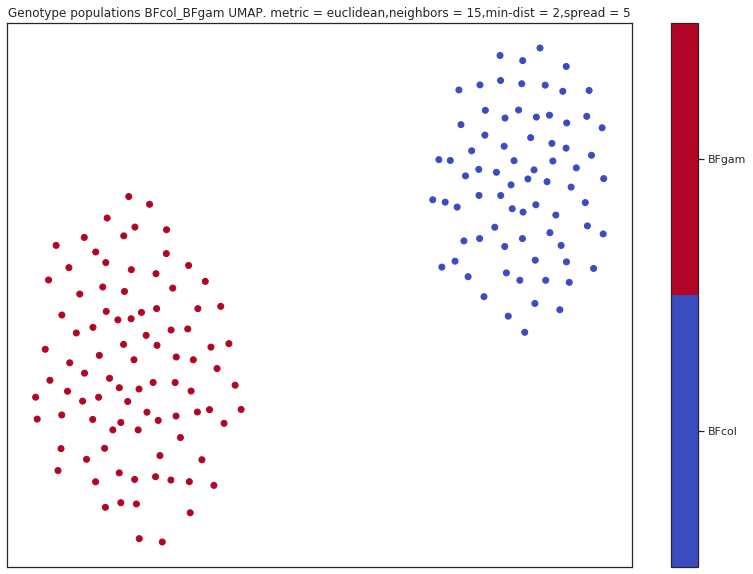

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_AOcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 306)
2.) Filtering Rare Allels
Number of SNPs removed =  3455502
Retaining =  196218
3.) Performing LD Pruning
iteration 1 retaining 65183 removing 131035 variants
iteration 2 retaining 61723 removing 3460 variants
iteration 3 retaining 61477 removing 246 variants
Retained Haplotype Matrix =  (61477, 306)
Retained Positions Matrix =  (61477,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


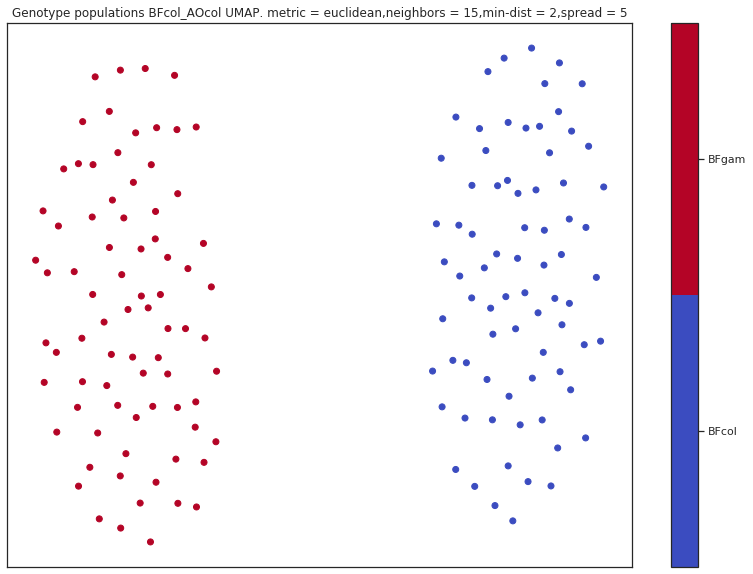

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_CIcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 292)
2.) Filtering Rare Allels
Number of SNPs removed =  3444868
Retaining =  206852
3.) Performing LD Pruning
iteration 1 retaining 92739 removing 114113 variants
iteration 2 retaining 91952 removing 787 variants
iteration 3 retaining 91924 removing 28 variants
Retained Haplotype Matrix =  (91924, 292)
Retained Positions Matrix =  (91924,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


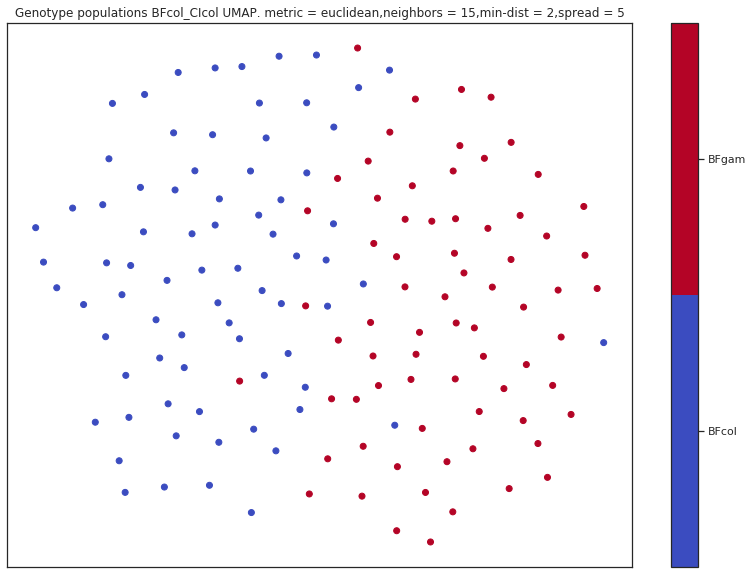

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 350)
2.) Filtering Rare Allels
Number of SNPs removed =  3450888
Retaining =  200832
3.) Performing LD Pruning
iteration 1 retaining 118766 removing 82066 variants
iteration 2 retaining 117913 removing 853 variants
iteration 3 retaining 117855 removing 58 variants
Retained Haplotype Matrix =  (117855, 350)
Retained Positions Matrix =  (117855,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


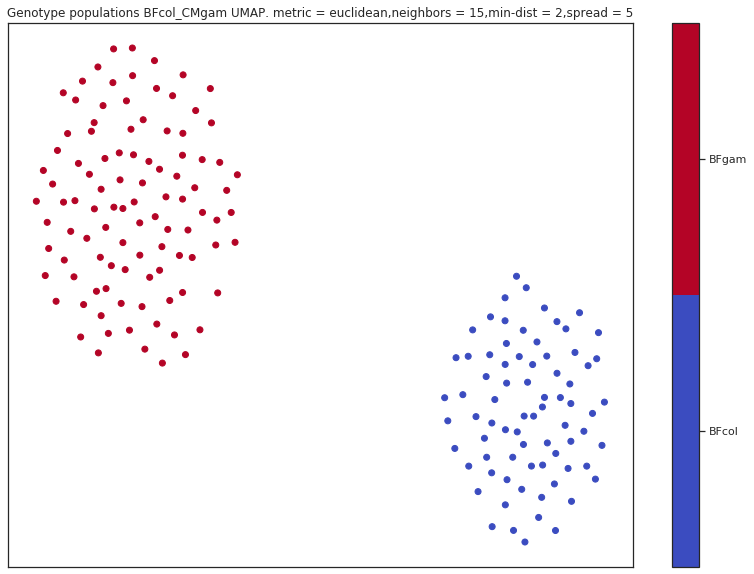

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 288)
2.) Filtering Rare Allels
Number of SNPs removed =  3433494
Retaining =  218226
3.) Performing LD Pruning
iteration 1 retaining 58599 removing 159627 variants
iteration 2 retaining 52813 removing 5786 variants
iteration 3 retaining 52373 removing 440 variants
Retained Haplotype Matrix =  (52373, 288)
Retained Positions Matrix =  (52373,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


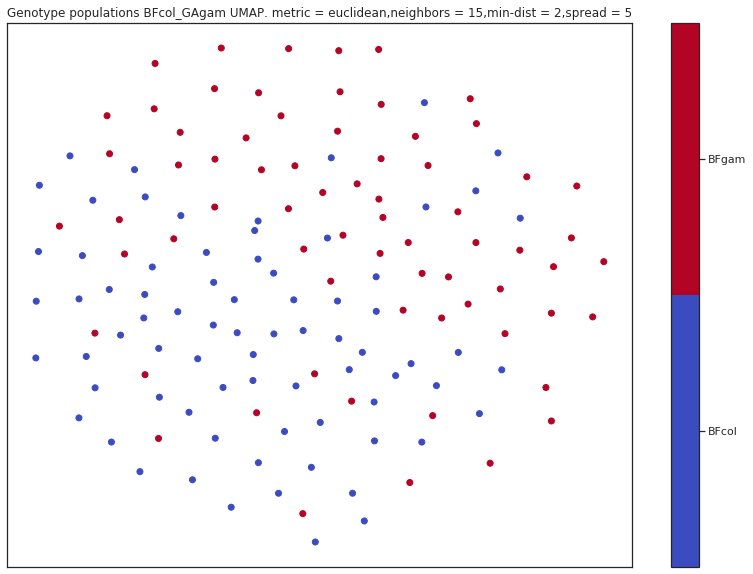

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 260)
2.) Filtering Rare Allels
Number of SNPs removed =  3442525
Retaining =  209195
3.) Performing LD Pruning
iteration 1 retaining 100559 removing 108636 variants
iteration 2 retaining 99841 removing 718 variants
iteration 3 retaining 99782 removing 59 variants
Retained Haplotype Matrix =  (99782, 260)
Retained Positions Matrix =  (99782,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


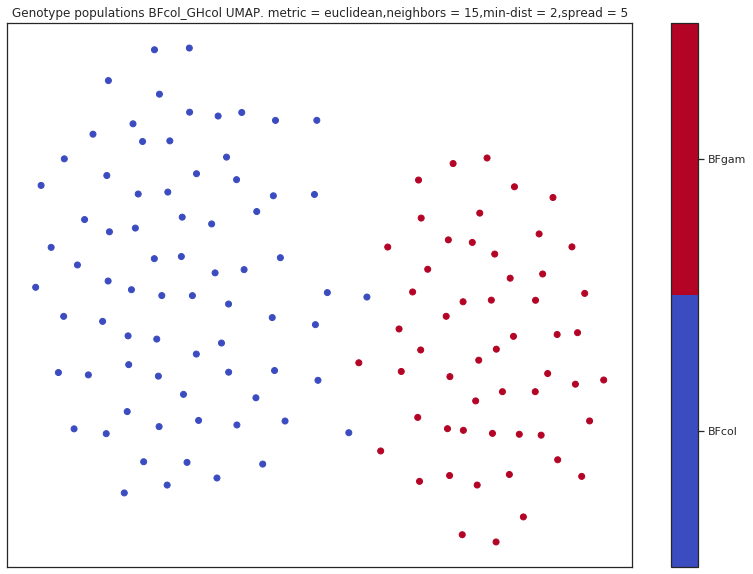

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3437772
Retaining =  213948
3.) Performing LD Pruning
iteration 1 retaining 98127 removing 115821 variants
iteration 2 retaining 95281 removing 2846 variants
iteration 3 retaining 95080 removing 201 variants
Retained Haplotype Matrix =  (95080, 280)
Retained Positions Matrix =  (95080,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


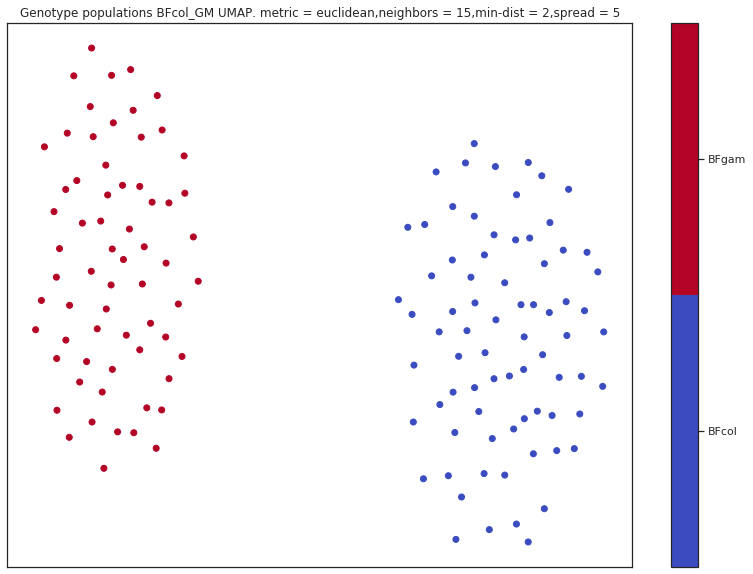

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 230)
2.) Filtering Rare Allels
Number of SNPs removed =  3451347
Retaining =  200373
3.) Performing LD Pruning
iteration 1 retaining 112974 removing 87399 variants
iteration 2 retaining 111236 removing 1738 variants
iteration 3 retaining 111014 removing 222 variants
Retained Haplotype Matrix =  (111014, 230)
Retained Positions Matrix =  (111014,)
iteration 2 retaining 111266 removing 222 variants
iteration 3 retaining 111254 removing 12 variants
Retained Haplotype Matrix =  (111254, 332)
Retained Positions Matrix =  (111254,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


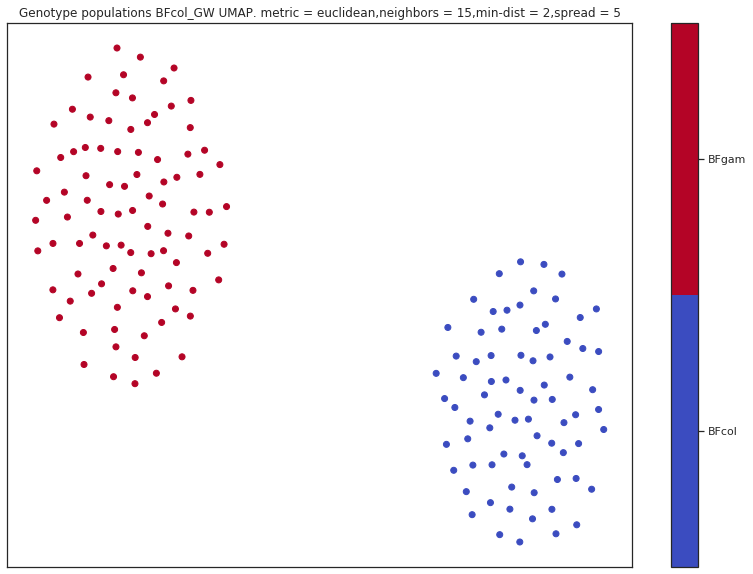

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 246)
2.) Filtering Rare Allels
Number of SNPs removed =  3459635
Retaining =  192085
3.) Performing LD Pruning
iteration 1 retaining 39963 removing 152122 variants
iteration 2 retaining 26214 removing 13749 variants
iteration 3 retaining 21719 removing 4495 variants
Retained Haplotype Matrix =  (21719, 246)
Retained Positions Matrix =  (21719,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


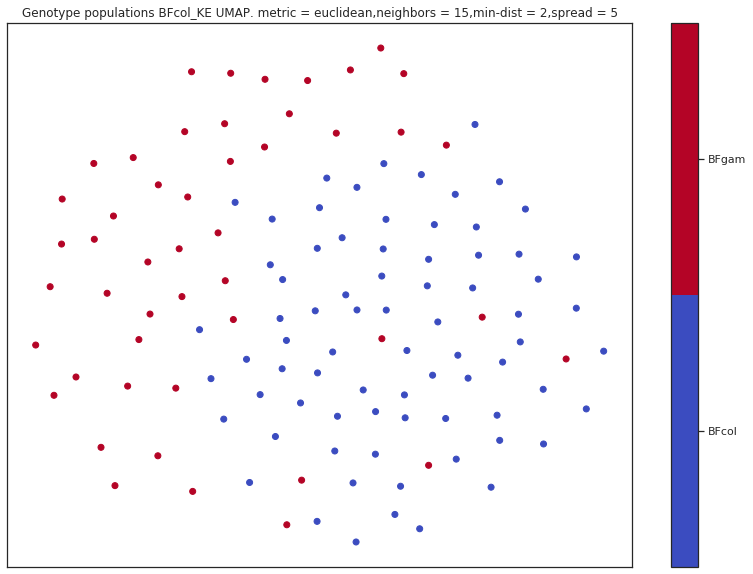

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 374)
2.) Filtering Rare Allels
Number of SNPs removed =  3446681
Retaining =  205039
3.) Performing LD Pruning
iteration 1 retaining 115321 removing 89718 variants
iteration 2 retaining 114508 removing 813 variants
iteration 3 retaining 114456 removing 52 variants
Retained Haplotype Matrix =  (114456, 374)
Retained Positions Matrix =  (114456,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


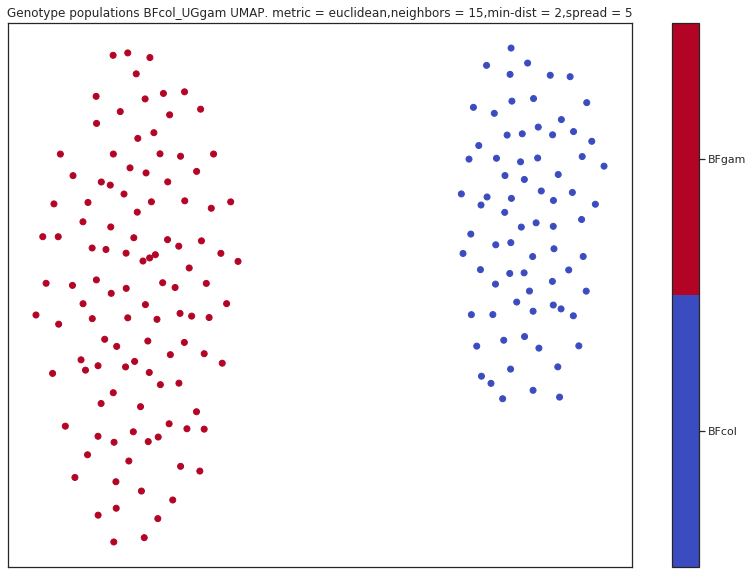

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_AOcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 340)
2.) Filtering Rare Allels
Number of SNPs removed =  3444632
Retaining =  207088
3.) Performing LD Pruning
iteration 1 retaining 73062 removing 134026 variants
iteration 2 retaining 69575 removing 3487 variants
iteration 3 retaining 69339 removing 236 variants
Retained Haplotype Matrix =  (69339, 340)
Retained Positions Matrix =  (69339,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


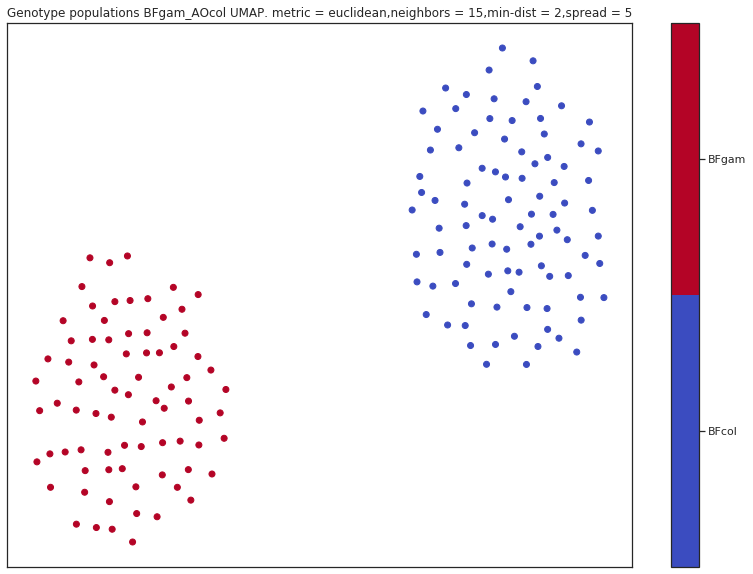

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_CIcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 326)
2.) Filtering Rare Allels
Number of SNPs removed =  3447386
Retaining =  204334
3.) Performing LD Pruning
iteration 1 retaining 104147 removing 100187 variants
iteration 2 retaining 102738 removing 1409 variants
iteration 3 retaining 102654 removing 84 variants
Retained Haplotype Matrix =  (102654, 326)
Retained Positions Matrix =  (102654,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


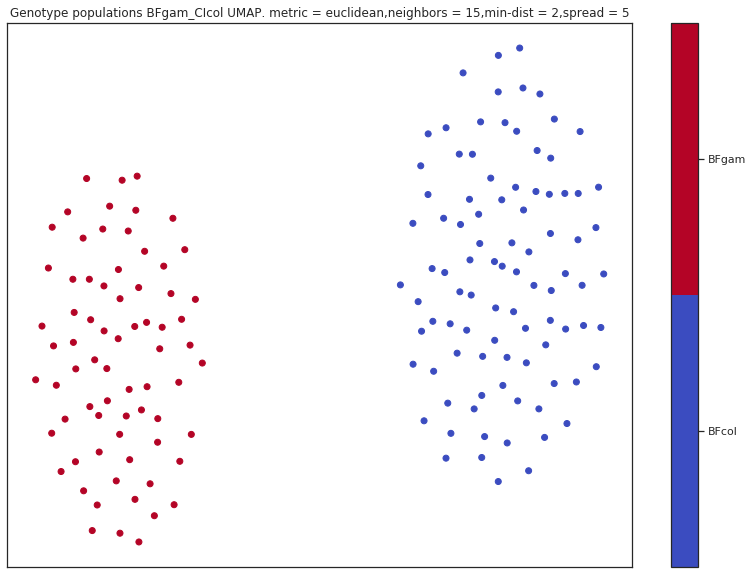

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 384)
2.) Filtering Rare Allels
Number of SNPs removed =  3449831
Retaining =  201889
3.) Performing LD Pruning
iteration 1 retaining 114364 removing 87525 variants
iteration 2 retaining 113491 removing 873 variants
iteration 3 retaining 113461 removing 30 variants
Retained Haplotype Matrix =  (113461, 384)
Retained Positions Matrix =  (113461,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


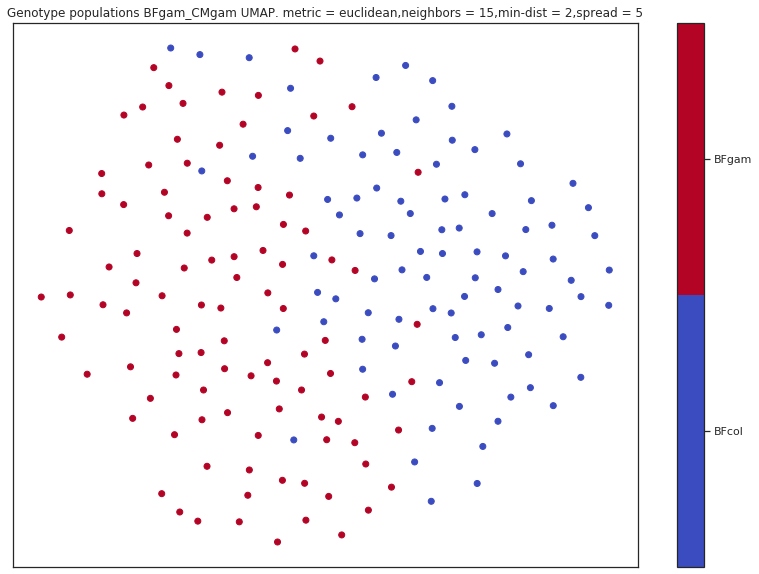

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 322)
2.) Filtering Rare Allels
Number of SNPs removed =  3435732
Retaining =  215988
3.) Performing LD Pruning
iteration 1 retaining 63966 removing 152022 variants
iteration 2 retaining 59327 removing 4639 variants
iteration 3 retaining 59156 removing 171 variants
Retained Haplotype Matrix =  (59156, 322)
Retained Positions Matrix =  (59156,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


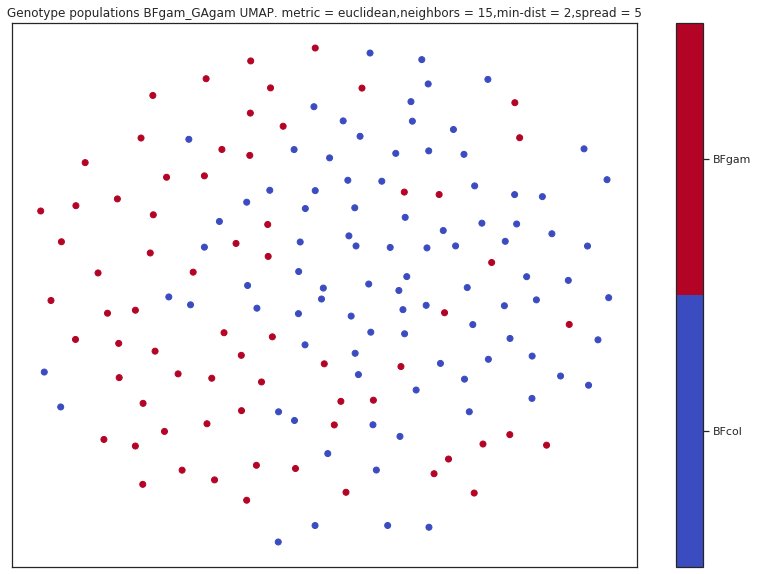

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 294)
2.) Filtering Rare Allels
Number of SNPs removed =  3444547
Retaining =  207173
3.) Performing LD Pruning
iteration 1 retaining 109988 removing 97185 variants
iteration 2 retaining 108493 removing 1495 variants
iteration 3 retaining 108392 removing 101 variants
Retained Haplotype Matrix =  (108392, 294)
Retained Positions Matrix =  (108392,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


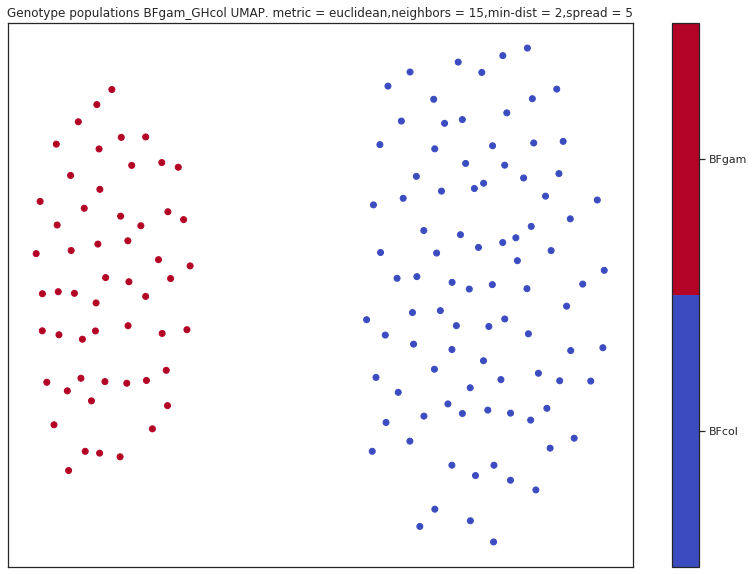

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 314)
2.) Filtering Rare Allels
Number of SNPs removed =  3441219
Retaining =  210501
3.) Performing LD Pruning
iteration 1 retaining 102758 removing 107743 variants
iteration 2 retaining 100152 removing 2606 variants
iteration 3 retaining 99979 removing 173 variants
Retained Haplotype Matrix =  (99979, 314)
Retained Positions Matrix =  (99979,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


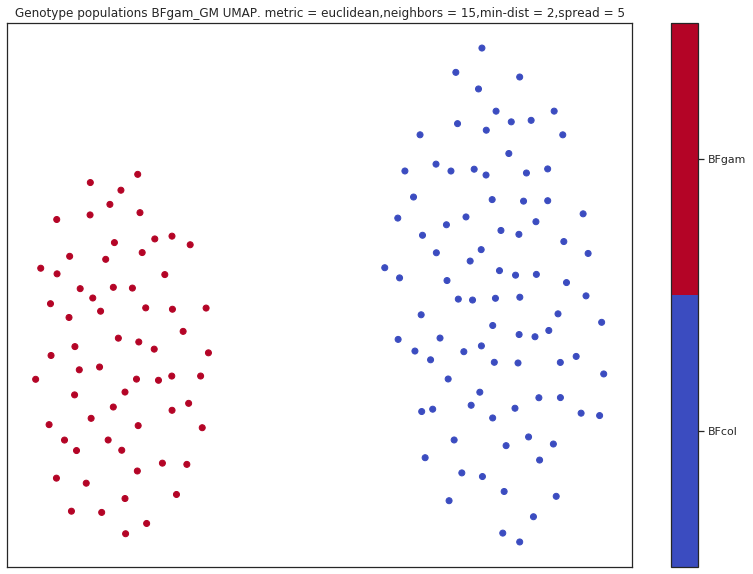

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 264)
2.) Filtering Rare Allels
Number of SNPs removed =  3448273
Retaining =  203447
3.) Performing LD Pruning
iteration 1 retaining 107740 removing 95707 variants
iteration 2 retaining 105927 removing 1813 variants
iteration 3 retaining 105816 removing 111 variants
Retained Haplotype Matrix =  (105816, 264)
Retained Positions Matrix =  (105816,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


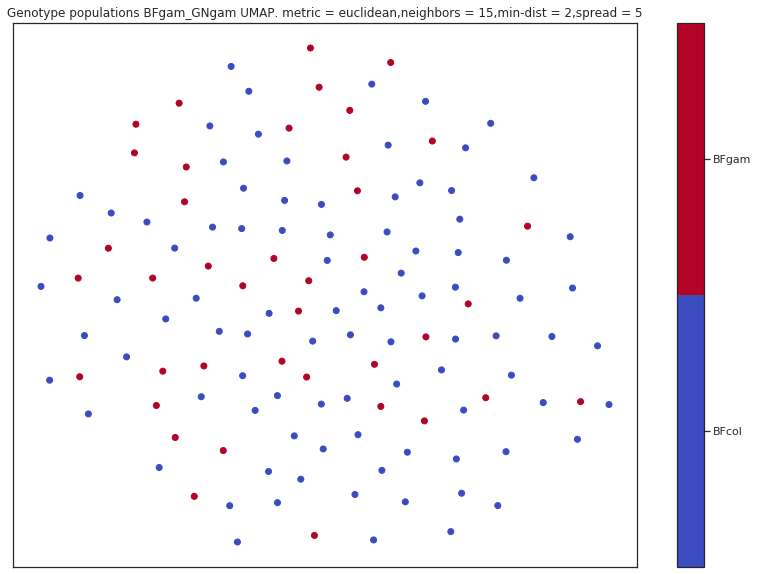

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 366)
2.) Filtering Rare Allels
Number of SNPs removed =  3447387
Retaining =  204333
3.) Performing LD Pruning
iteration 1 retaining 114490 removing 89843 variants
iteration 2 retaining 113970 removing 520 variants
iteration 3 retaining 113954 removing 16 variants
Retained Haplotype Matrix =  (113954, 366)
Retained Positions Matrix =  (113954,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


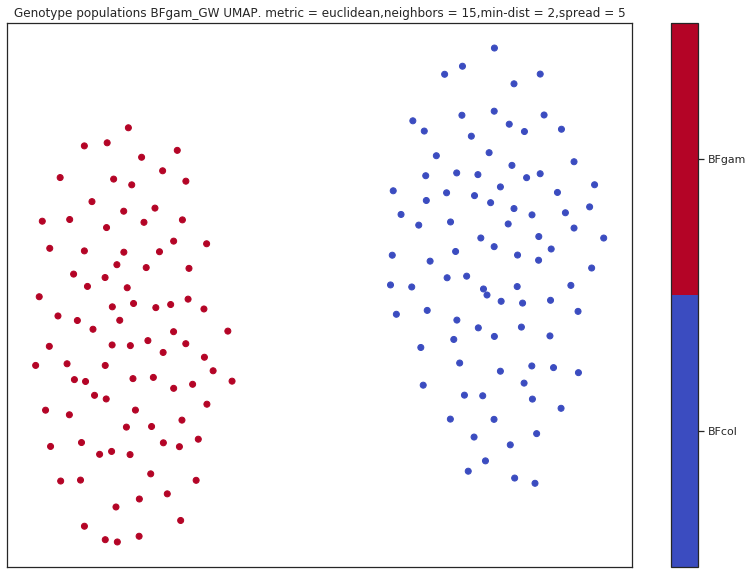

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3446317
Retaining =  205403
3.) Performing LD Pruning
iteration 1 retaining 49687 removing 155716 variants
iteration 2 retaining 39225 removing 10462 variants
iteration 3 retaining 37312 removing 1913 variants
Retained Haplotype Matrix =  (37312, 280)
Retained Positions Matrix =  (37312,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


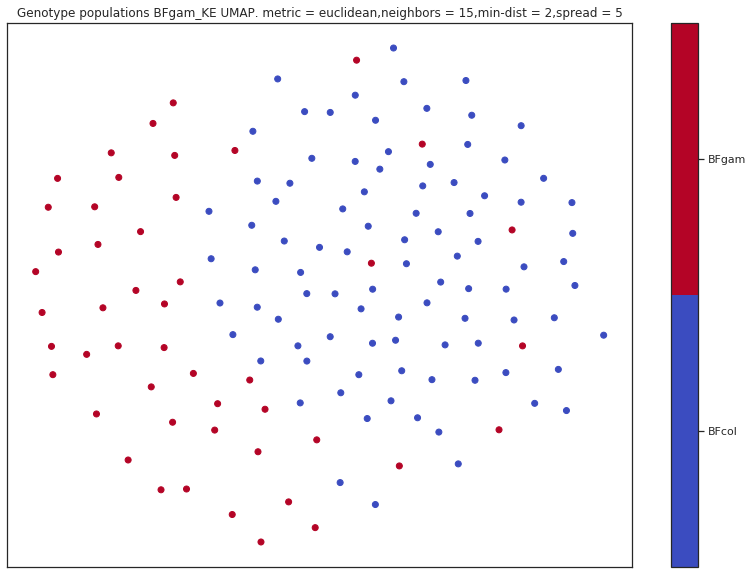

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


BFgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 408)
2.) Filtering Rare Allels
Number of SNPs removed =  3447173
Retaining =  204547
3.) Performing LD Pruning
iteration 1 retaining 114492 removing 90055 variants
iteration 2 retaining 113867 removing 625 variants
iteration 3 retaining 113845 removing 22 variants
Retained Haplotype Matrix =  (113845, 408)
Retained Positions Matrix =  (113845,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


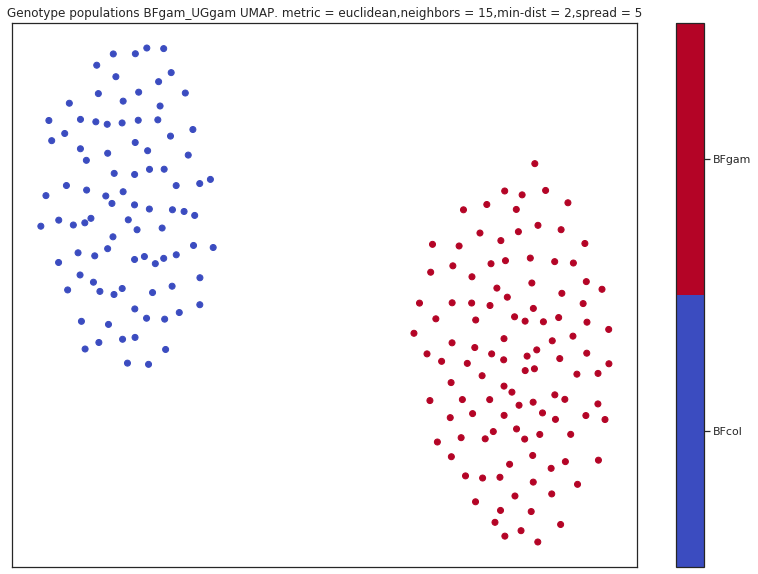

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_CIcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 298)
2.) Filtering Rare Allels
Number of SNPs removed =  3444038
Retaining =  207682
3.) Performing LD Pruning
iteration 1 retaining 50998 removing 156684 variants
iteration 2 retaining 46649 removing 4349 variants
iteration 3 retaining 46424 removing 225 variants
Retained Haplotype Matrix =  (46424, 298)
Retained Positions Matrix =  (46424,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


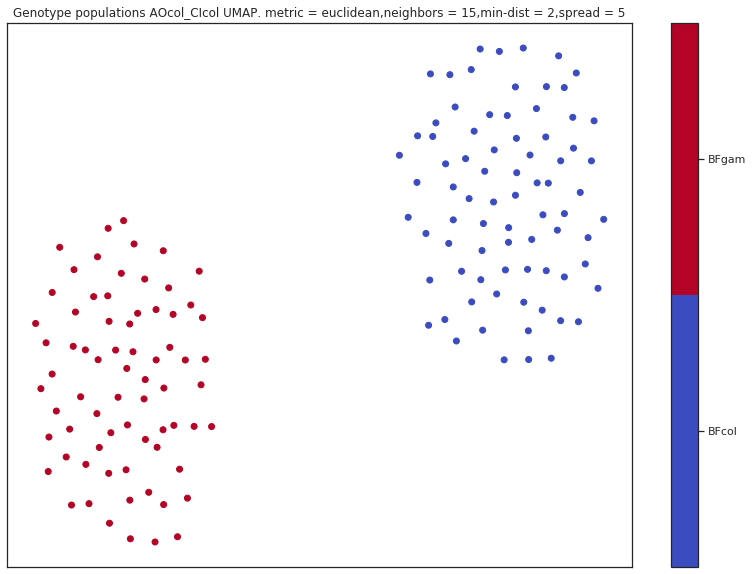

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 356)
2.) Filtering Rare Allels
Number of SNPs removed =  3446178
Retaining =  205542
3.) Performing LD Pruning
iteration 1 retaining 77193 removing 128349 variants
iteration 2 retaining 74259 removing 2934 variants
iteration 3 retaining 74067 removing 192 variants
Retained Haplotype Matrix =  (74067, 356)
Retained Positions Matrix =  (74067,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


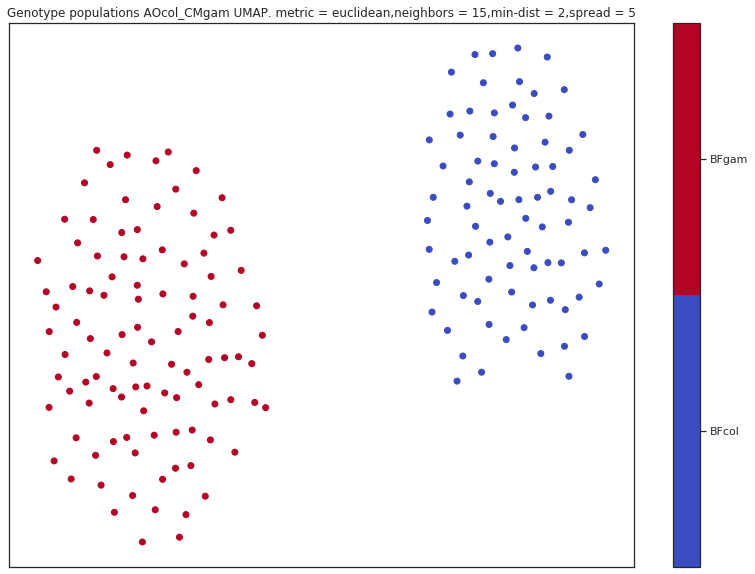

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 294)
2.) Filtering Rare Allels
Number of SNPs removed =  3424104
Retaining =  227616
3.) Performing LD Pruning
iteration 1 retaining 25459 removing 202157 variants
iteration 2 retaining 19488 removing 5971 variants
iteration 3 retaining 19320 removing 168 variants
Retained Haplotype Matrix =  (19320, 294)
Retained Positions Matrix =  (19320,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


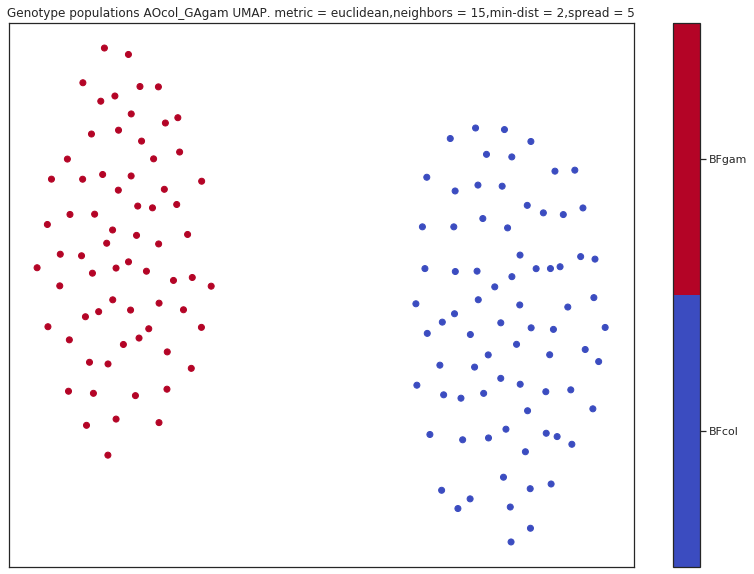

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 266)
2.) Filtering Rare Allels
Number of SNPs removed =  3452478
Retaining =  199242
3.) Performing LD Pruning
iteration 1 retaining 47168 removing 152074 variants
iteration 2 retaining 41904 removing 5264 variants
iteration 3 retaining 41458 removing 446 variants
Retained Haplotype Matrix =  (41458, 266)
Retained Positions Matrix =  (41458,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


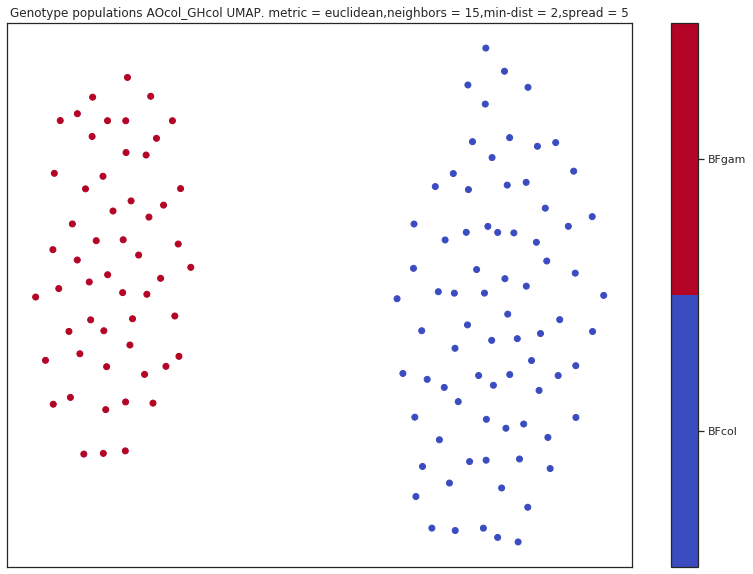

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 286)
2.) Filtering Rare Allels
Number of SNPs removed =  3444735
Retaining =  206985
3.) Performing LD Pruning
iteration 1 retaining 44183 removing 162802 variants
iteration 2 retaining 38047 removing 6136 variants
iteration 3 retaining 37741 removing 306 variants
Retained Haplotype Matrix =  (37741, 286)
Retained Positions Matrix =  (37741,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


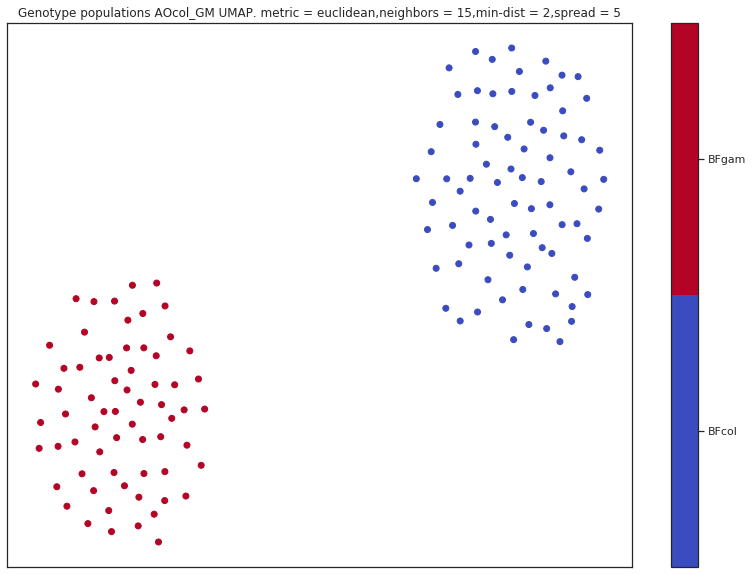

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 236)
2.) Filtering Rare Allels
Number of SNPs removed =  3449962
Retaining =  201758
3.) Performing LD Pruning
iteration 2 retaining 67030 removing 2626 variants
iteration 3 retaining 66857 removing 173 variants
Retained Haplotype Matrix =  (66857, 338)
Retained Positions Matrix =  (66857,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


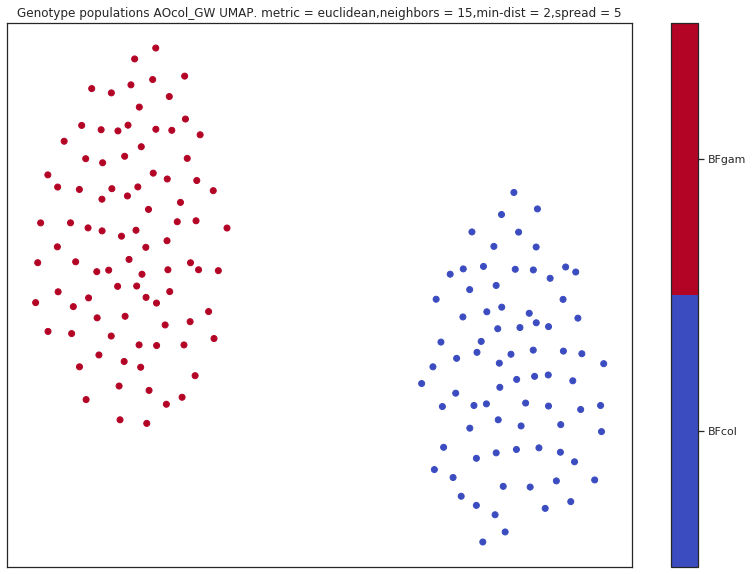

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 252)
2.) Filtering Rare Allels
Number of SNPs removed =  3443182
Retaining =  208538
3.) Performing LD Pruning
iteration 1 retaining 12232 removing 196306 variants
iteration 2 retaining 5776 removing 6456 variants
iteration 3 retaining 4681 removing 1095 variants
Retained Haplotype Matrix =  (4681, 252)
Retained Positions Matrix =  (4681,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


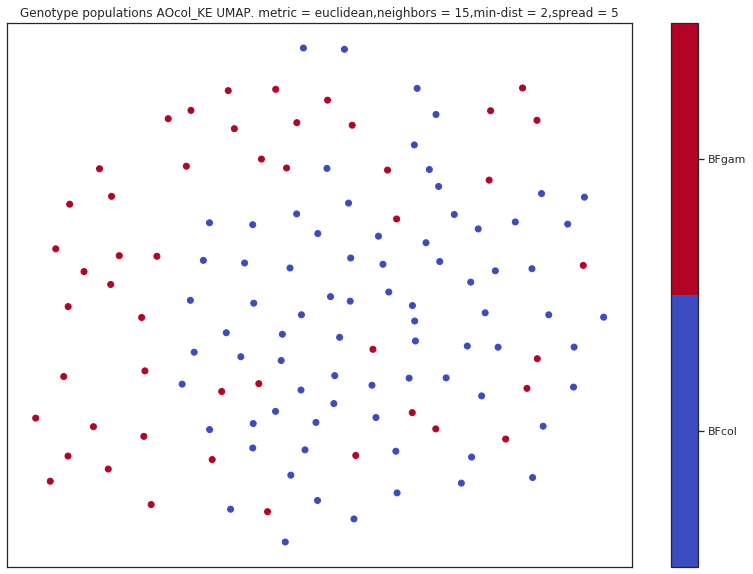

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AOcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 380)
2.) Filtering Rare Allels
Number of SNPs removed =  3441526
Retaining =  210194
3.) Performing LD Pruning
iteration 1 retaining 77218 removing 132976 variants
iteration 2 retaining 74726 removing 2492 variants
iteration 3 retaining 74624 removing 102 variants
Retained Haplotype Matrix =  (74624, 380)
Retained Positions Matrix =  (74624,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


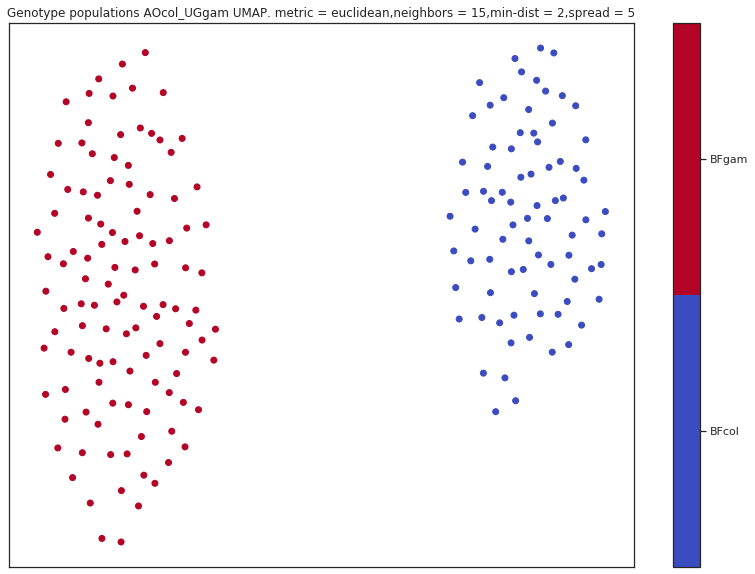

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 342)
2.) Filtering Rare Allels
Number of SNPs removed =  3450009
Retaining =  201711
3.) Performing LD Pruning
iteration 1 retaining 107163 removing 94548 variants
iteration 2 retaining 106004 removing 1159 variants
iteration 3 retaining 105937 removing 67 variants
Retained Haplotype Matrix =  (105937, 342)
Retained Positions Matrix =  (105937,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


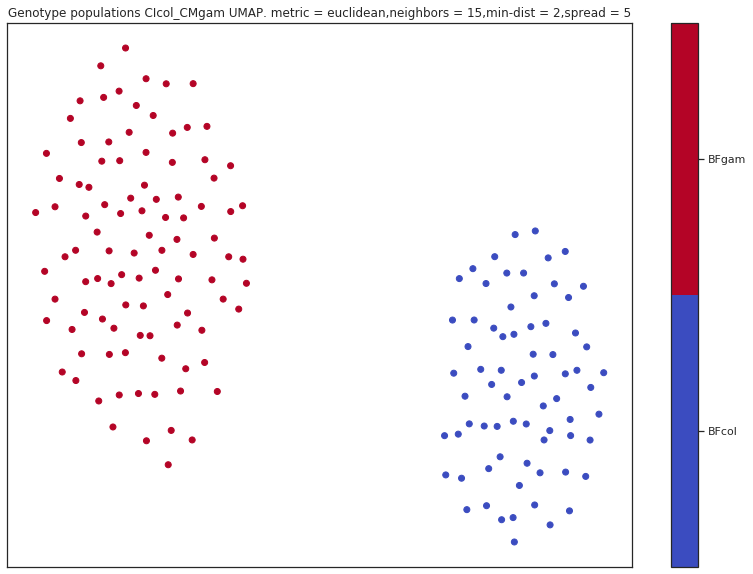

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3419651
Retaining =  232069
3.) Performing LD Pruning
iteration 1 retaining 43017 removing 189052 variants
iteration 2 retaining 36170 removing 6847 variants
iteration 3 retaining 35845 removing 325 variants
Retained Haplotype Matrix =  (35845, 280)
Retained Positions Matrix =  (35845,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


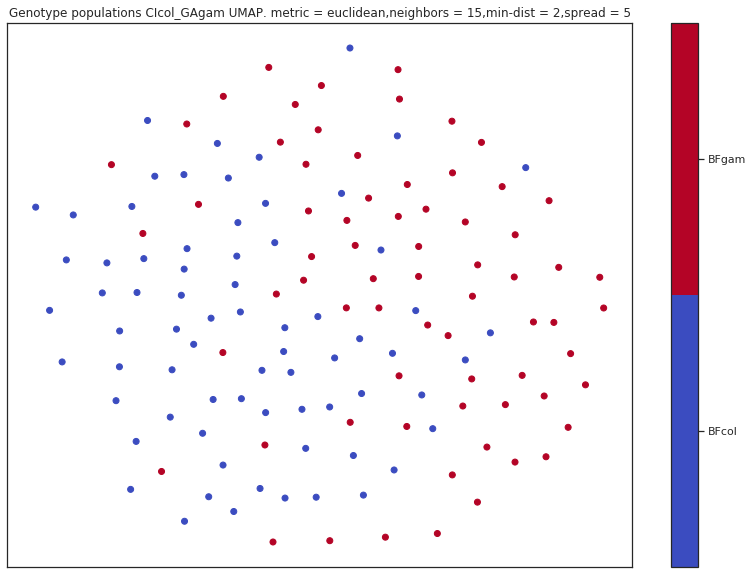

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 252)
2.) Filtering Rare Allels
Number of SNPs removed =  3437390
Retaining =  214330
3.) Performing LD Pruning
iteration 1 retaining 70534 removing 143796 variants
iteration 2 retaining 68882 removing 1652 variants
iteration 3 retaining 68829 removing 53 variants
Retained Haplotype Matrix =  (68829, 252)
Retained Positions Matrix =  (68829,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


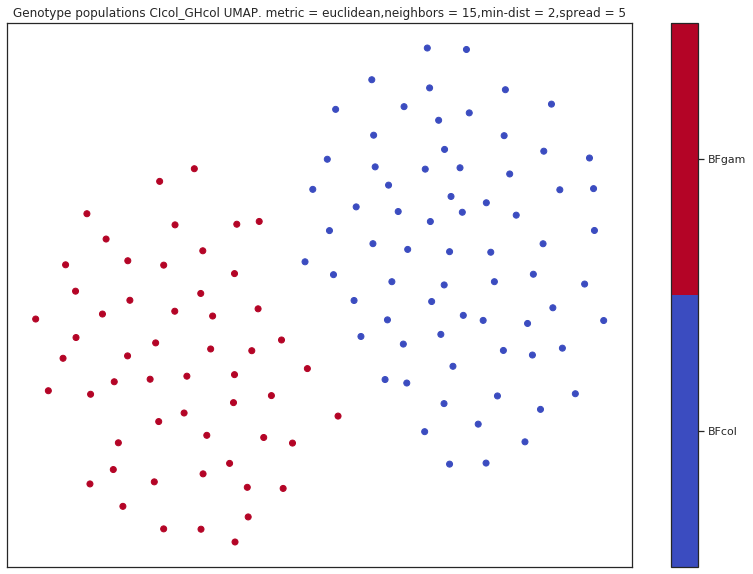

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 272)
2.) Filtering Rare Allels
Number of SNPs removed =  3435319
Retaining =  216401
3.) Performing LD Pruning
iteration 1 retaining 76799 removing 139602 variants
iteration 2 retaining 72882 removing 3917 variants
iteration 3 retaining 72688 removing 194 variants
Retained Haplotype Matrix =  (72688, 272)
Retained Positions Matrix =  (72688,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


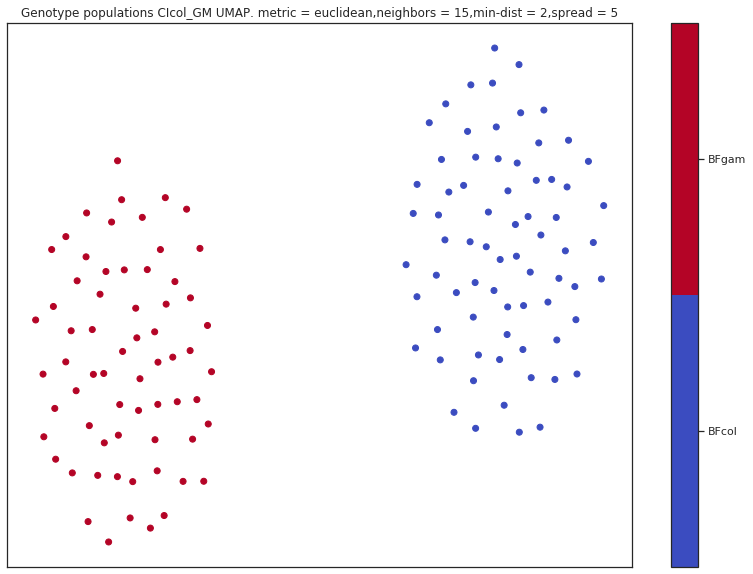

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 222)
2.) Filtering Rare Allels
Number of SNPs removed =  3447416
Retaining =  204304
3.) Performing LD Pruning
iteration 1 retaining 84886 removing 119418 variants
iteration 2 retaining 81532 removing 3354 variants
iteration 3 retaining 81277 removing 255 variants
Retained Haplotype Matrix =  (81277, 222)
Retained Positions Matrix =  (81277,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


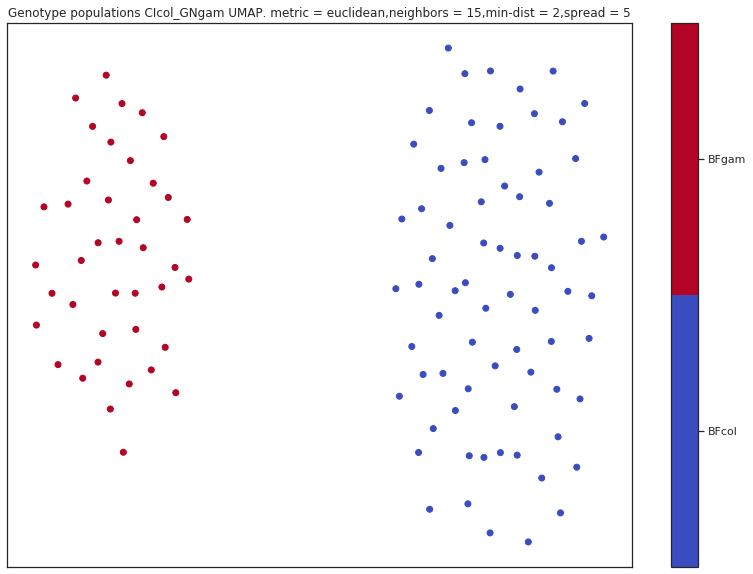

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 324)
2.) Filtering Rare Allels
Number of SNPs removed =  3443481
Retaining =  208239
3.) Performing LD Pruning
iteration 1 retaining 96969 removing 111270 variants
iteration 2 retaining 96390 removing 579 variants
iteration 3 retaining 96376 removing 14 variants
Retained Haplotype Matrix =  (96376, 324)
Retained Positions Matrix =  (96376,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


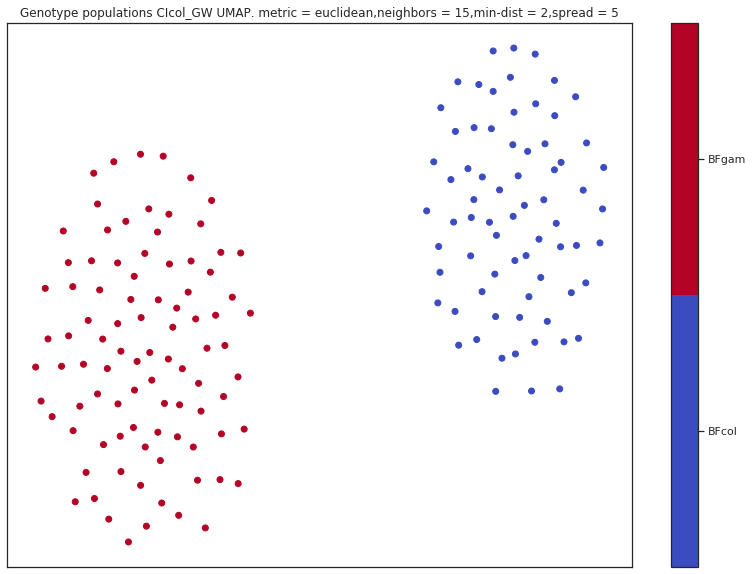

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 238)
2.) Filtering Rare Allels
Number of SNPs removed =  3444457
Retaining =  207263
3.) Performing LD Pruning
iteration 1 retaining 22322 removing 184941 variants
iteration 2 retaining 12047 removing 10275 variants
iteration 3 retaining 9296 removing 2751 variants
Retained Haplotype Matrix =  (9296, 238)
Retained Positions Matrix =  (9296,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


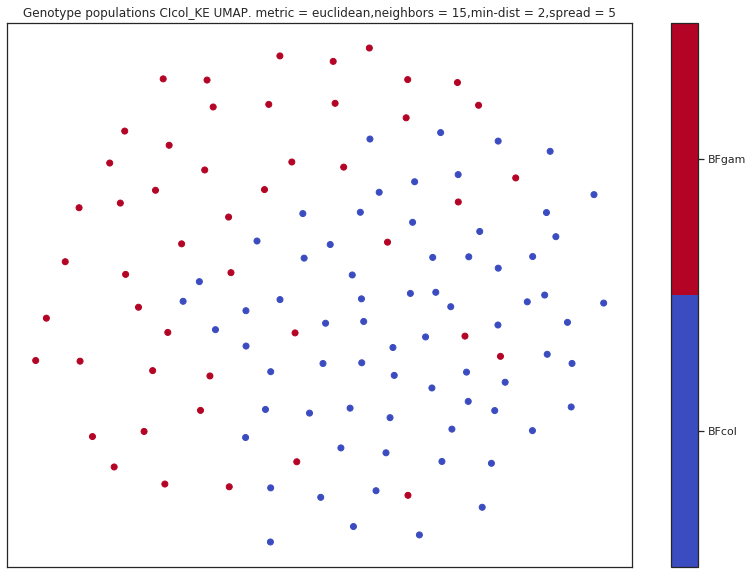

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CIcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 366)
2.) Filtering Rare Allels
Number of SNPs removed =  3446117
Retaining =  205603
3.) Performing LD Pruning
iteration 1 retaining 104964 removing 100639 variants
iteration 2 retaining 103759 removing 1205 variants
iteration 3 retaining 103720 removing 39 variants
Retained Haplotype Matrix =  (103720, 366)
Retained Positions Matrix =  (103720,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


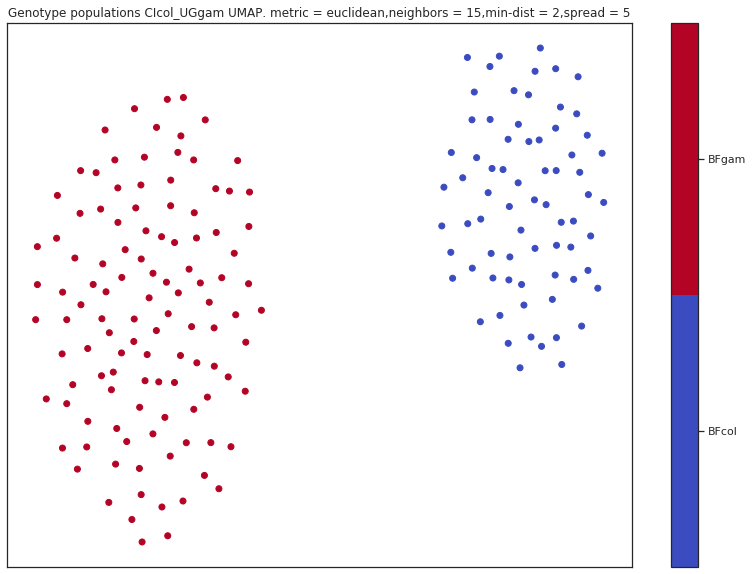

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 338)
2.) Filtering Rare Allels
Number of SNPs removed =  3429246
Retaining =  222474
3.) Performing LD Pruning
iteration 1 retaining 69607 removing 152867 variants
iteration 2 retaining 65103 removing 4504 variants
iteration 3 retaining 64916 removing 187 variants
Retained Haplotype Matrix =  (64916, 338)
Retained Positions Matrix =  (64916,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


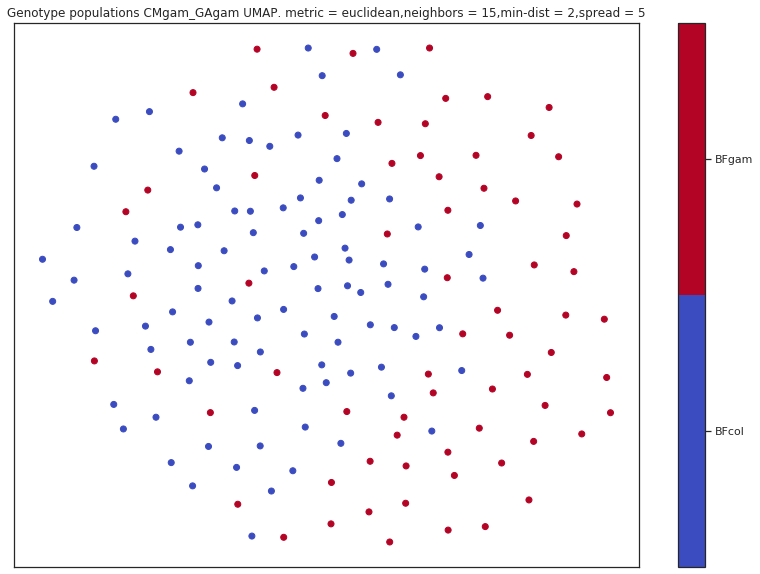

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 310)
2.) Filtering Rare Allels
Number of SNPs removed =  3447274
Retaining =  204446
3.) Performing LD Pruning
iteration 1 retaining 112548 removing 91898 variants
iteration 2 retaining 111247 removing 1301 variants
iteration 3 retaining 111144 removing 103 variants
Retained Haplotype Matrix =  (111144, 310)
Retained Positions Matrix =  (111144,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


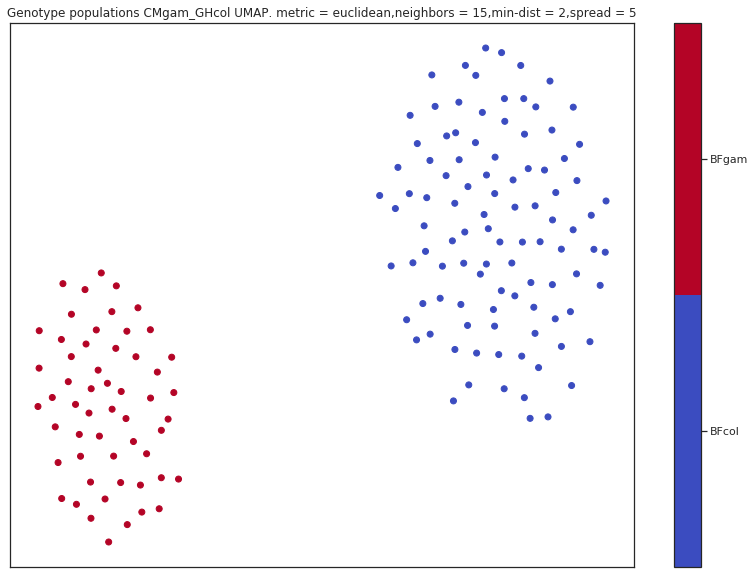

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 330)
2.) Filtering Rare Allels
Number of SNPs removed =  3444212
Retaining =  207508
3.) Performing LD Pruning
iteration 1 retaining 106275 removing 101233 variants
iteration 2 retaining 104122 removing 2153 variants
iteration 3 retaining 103963 removing 159 variants
Retained Haplotype Matrix =  (103963, 330)
Retained Positions Matrix =  (103963,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


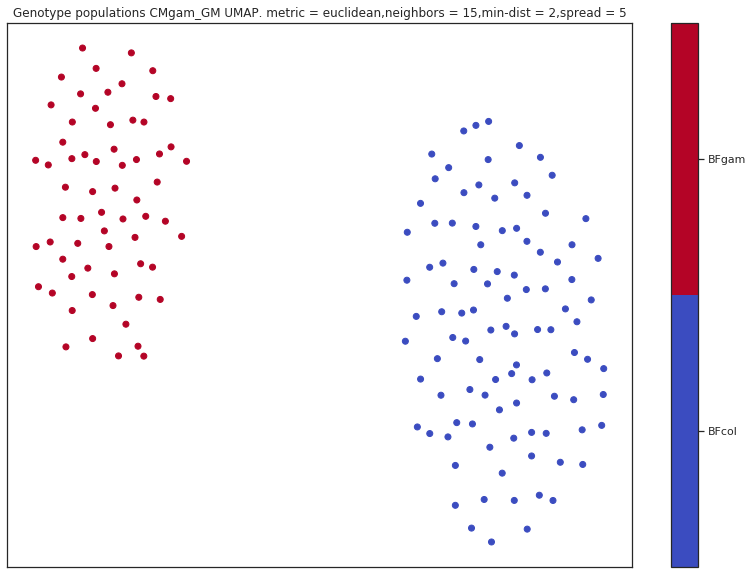

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3442081
Retaining =  209639
3.) Performing LD Pruning
iteration 1 retaining 116096 removing 93543 variants
iteration 2 retaining 114532 removing 1564 variants
iteration 3 retaining 114441 removing 91 variants
Retained Haplotype Matrix =  (114441, 280)
Retained Positions Matrix =  (114441,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


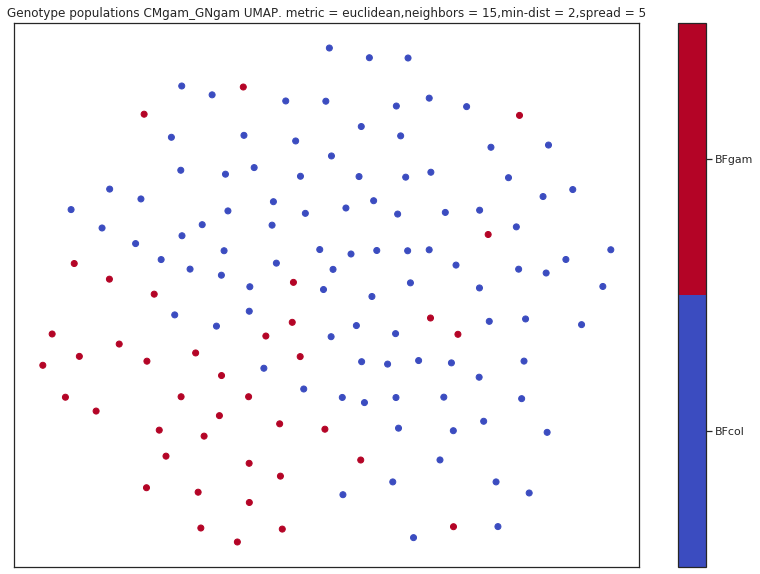

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 382)
2.) Filtering Rare Allels
Number of SNPs removed =  3449090
Retaining =  202630
3.) Performing LD Pruning
iteration 1 retaining 115840 removing 86790 variants
iteration 2 retaining 115340 removing 500 variants
iteration 3 retaining 115315 removing 25 variants
Retained Haplotype Matrix =  (115315, 382)
Retained Positions Matrix =  (115315,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


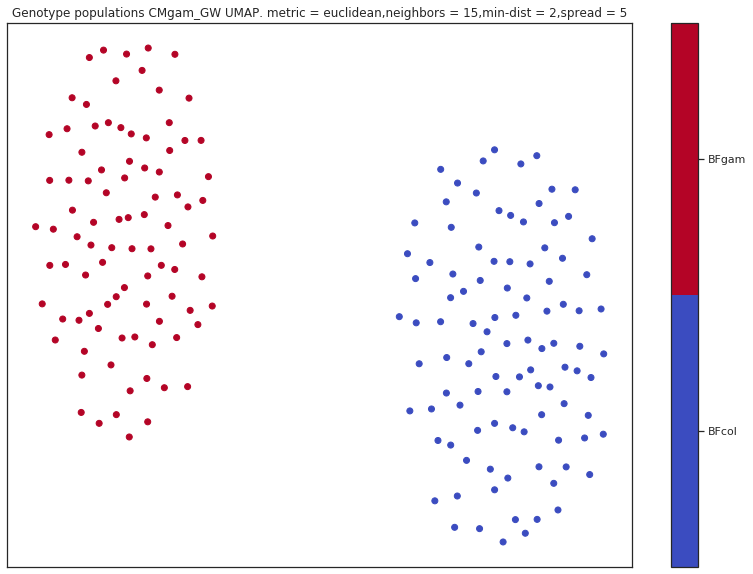

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 296)
2.) Filtering Rare Allels
Number of SNPs removed =  3446934
Retaining =  204786
3.) Performing LD Pruning
iteration 1 retaining 55112 removing 149674 variants
iteration 2 retaining 46002 removing 9110 variants
iteration 3 retaining 44654 removing 1348 variants
Retained Haplotype Matrix =  (44654, 296)
Retained Positions Matrix =  (44654,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


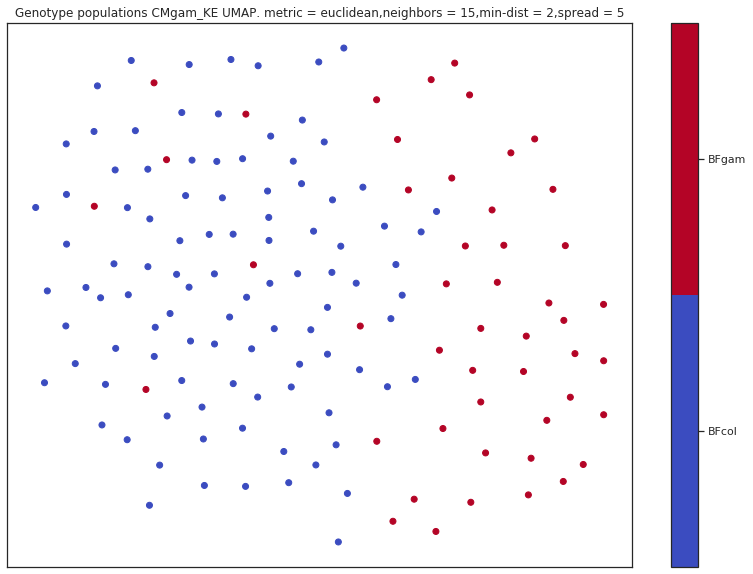

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CMgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 424)
2.) Filtering Rare Allels
Number of SNPs removed =  3448730
Retaining =  202990
3.) Performing LD Pruning
iteration 1 retaining 114759 removing 88231 variants
iteration 2 retaining 114208 removing 551 variants
iteration 3 retaining 114190 removing 18 variants
Retained Haplotype Matrix =  (114190, 424)
Retained Positions Matrix =  (114190,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


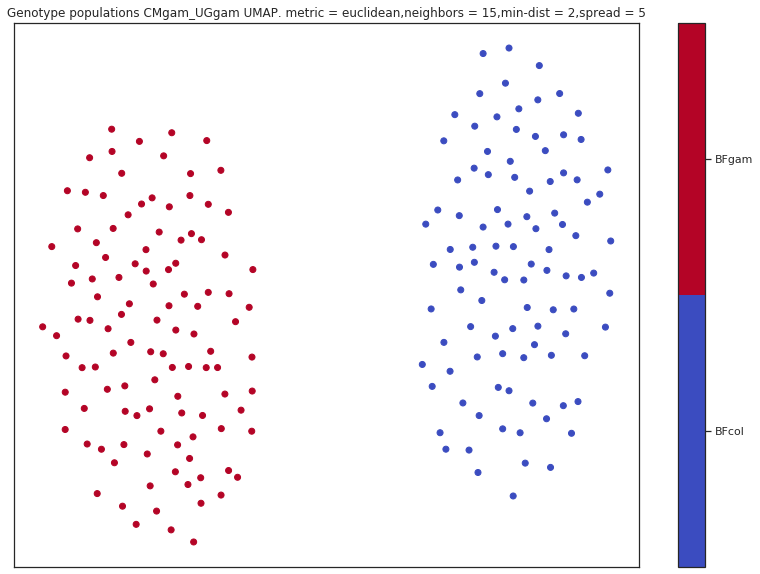

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 248)
2.) Filtering Rare Allels
Number of SNPs removed =  3426812
Retaining =  224908
3.) Performing LD Pruning
iteration 1 retaining 37838 removing 187070 variants
iteration 2 retaining 29787 removing 8051 variants
iteration 3 retaining 29067 removing 720 variants
Retained Haplotype Matrix =  (29067, 248)
Retained Positions Matrix =  (29067,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


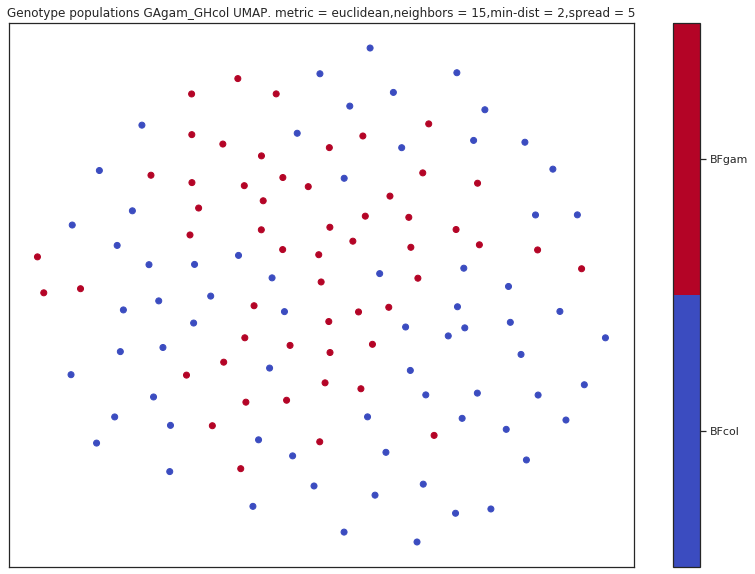

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 268)
2.) Filtering Rare Allels
Number of SNPs removed =  3423297
Retaining =  228423
3.) Performing LD Pruning
iteration 1 retaining 35574 removing 192849 variants
iteration 2 retaining 27125 removing 8449 variants
iteration 3 retaining 26819 removing 306 variants
Retained Haplotype Matrix =  (26819, 268)
Retained Positions Matrix =  (26819,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


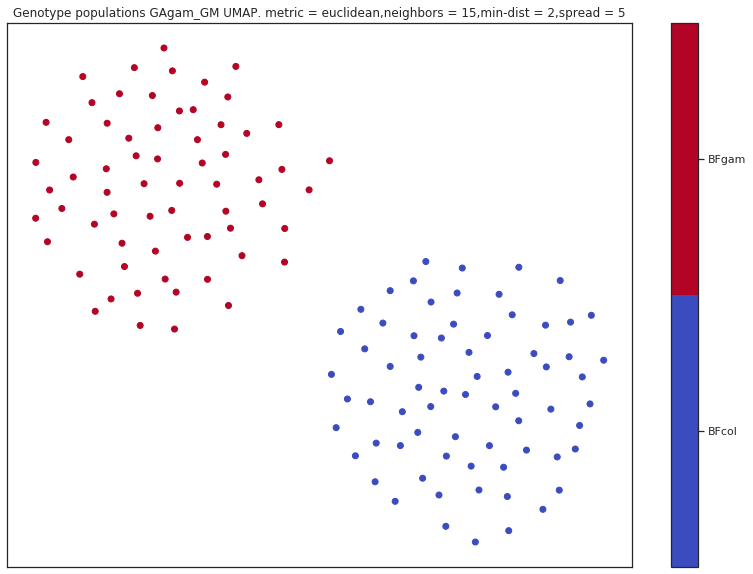

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 218)
2.) Filtering Rare Allels
Number of SNPs removed =  3422444
Retaining =  229276
3.) Performing LD Pruning
iteration 1 retaining 31927 removing 197349 variants
iteration 2 retaining 22871 removing 9056 variants
iteration 3 retaining 22083 removing 788 variants
Retained Haplotype Matrix =  (22083, 218)
Retained Positions Matrix =  (22083,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


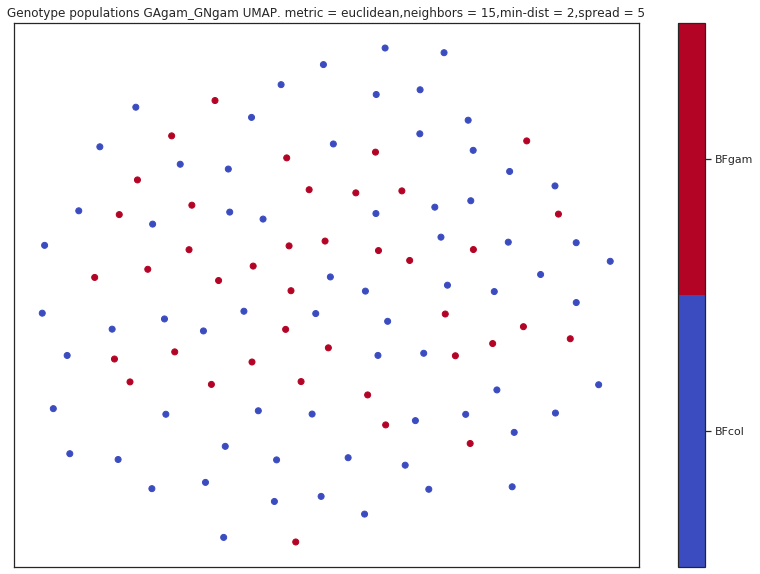

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 320)
2.) Filtering Rare Allels
Number of SNPs removed =  3422927
Retaining =  228793
3.) Performing LD Pruning
iteration 1 retaining 64157 removing 164636 variants
iteration 2 retaining 59657 removing 4500 variants
iteration 3 retaining 59441 removing 216 variants
Retained Haplotype Matrix =  (59441, 320)
Retained Positions Matrix =  (59441,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


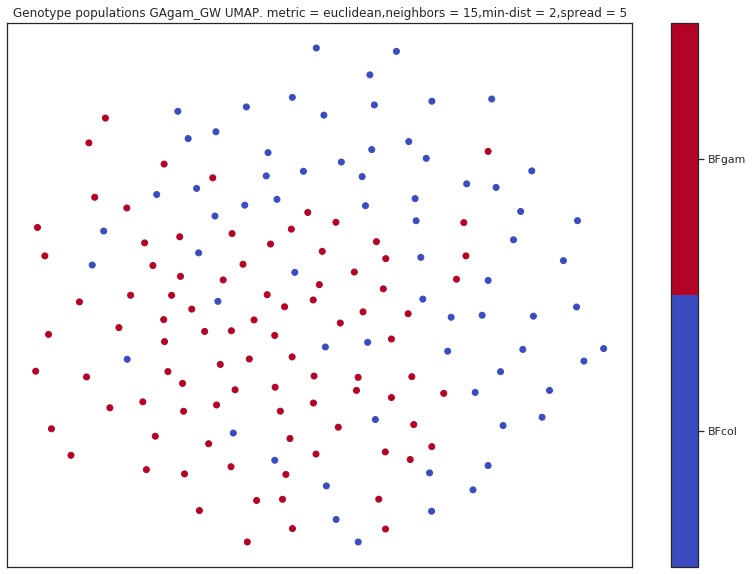

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 234)
2.) Filtering Rare Allels
Number of SNPs removed =  3425465
Retaining =  226255
3.) Performing LD Pruning
iteration 1 retaining 7268 removing 218987 variants
iteration 2 retaining 2386 removing 4882 variants
iteration 3 retaining 1867 removing 519 variants
Retained Haplotype Matrix =  (1867, 234)
Retained Positions Matrix =  (1867,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


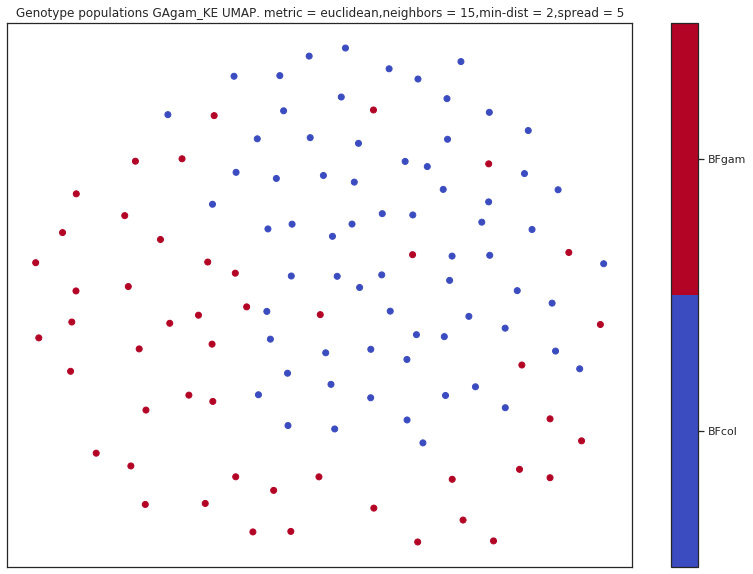

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GAgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 362)
2.) Filtering Rare Allels
Number of SNPs removed =  3434675
Retaining =  217045
3.) Performing LD Pruning
iteration 1 retaining 69036 removing 148009 variants
iteration 2 retaining 65755 removing 3281 variants
iteration 3 retaining 65676 removing 79 variants
Retained Haplotype Matrix =  (65676, 362)
Retained Positions Matrix =  (65676,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


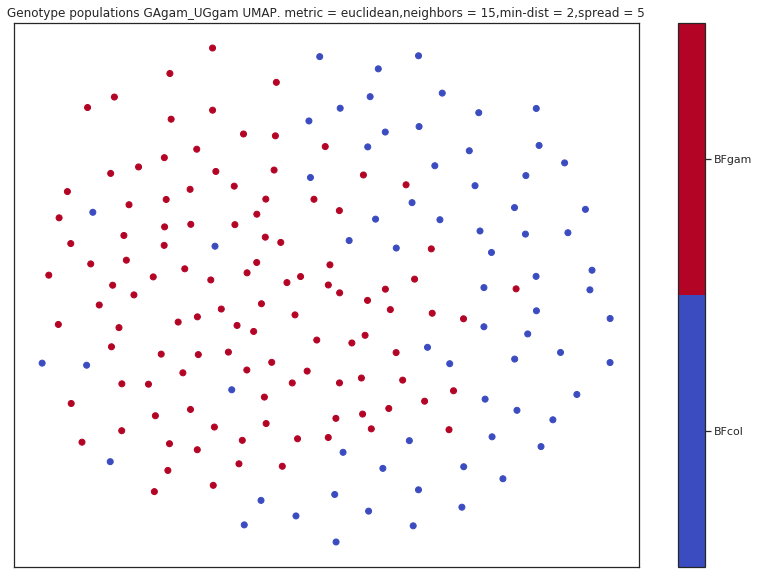

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GHcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 240)
2.) Filtering Rare Allels
Number of SNPs removed =  3429424
Retaining =  222296
3.) Performing LD Pruning
iteration 1 retaining 77640 removing 144656 variants
iteration 2 retaining 72187 removing 5453 variants
iteration 3 retaining 71791 removing 396 variants
Retained Haplotype Matrix =  (71791, 240)
Retained Positions Matrix =  (71791,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


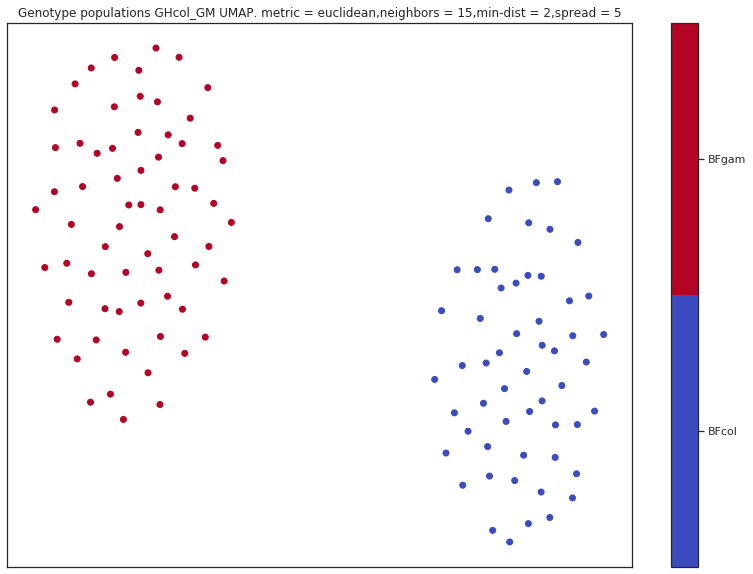

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GHcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 190)
2.) Filtering Rare Allels
Number of SNPs removed =  3444235
Retaining =  207485
3.) Performing LD Pruning
iteration 1 retaining 92222 removing 115263 variants
iteration 2 retaining 87095 removing 5127 variants
iteration 3 retaining 86406 removing 689 variants
Retained Haplotype Matrix =  (86406, 190)
Retained Positions Matrix =  (86406,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


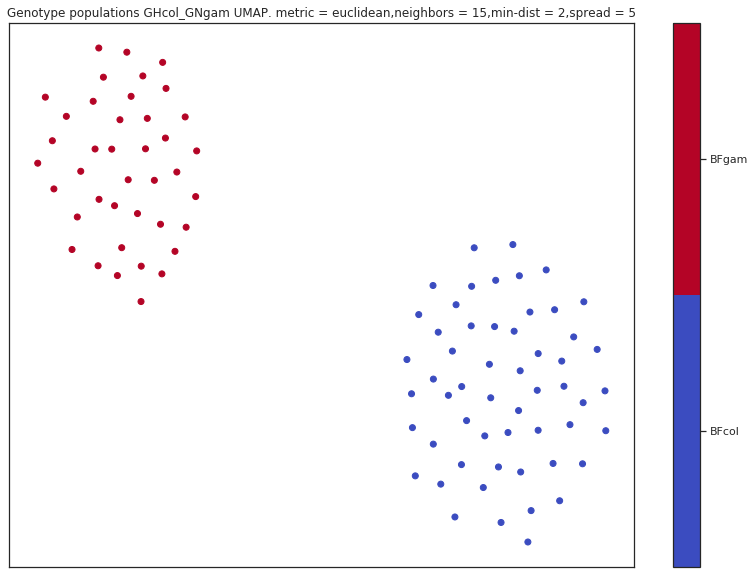

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GHcol_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 292)
2.) Filtering Rare Allels
Number of SNPs removed =  3439904
Retaining =  211816
3.) Performing LD Pruning
iteration 1 retaining 100992 removing 110824 variants


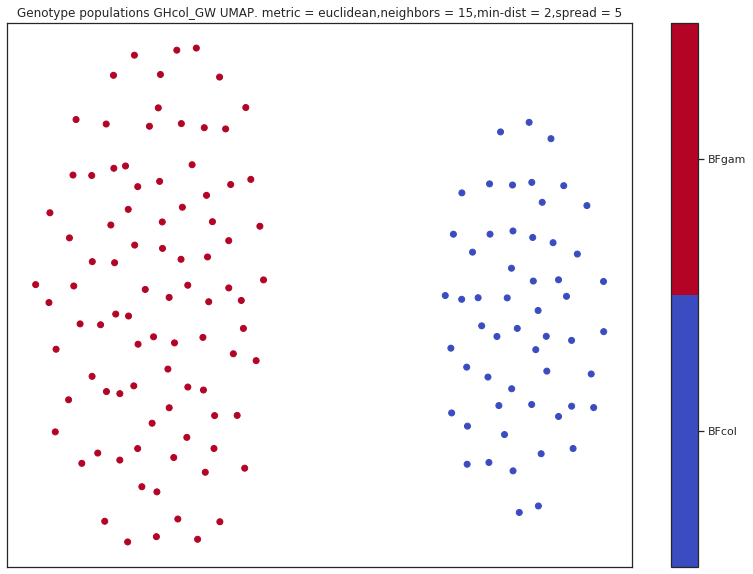

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GHcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 206)
2.) Filtering Rare Allels
Number of SNPs removed =  3459002
Retaining =  192718
3.) Performing LD Pruning
iteration 1 retaining 18766 removing 173952 variants
iteration 2 retaining 6871 removing 11895 variants
iteration 3 retaining 3544 removing 3327 variants
Retained Haplotype Matrix =  (3544, 206)
Retained Positions Matrix =  (3544,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


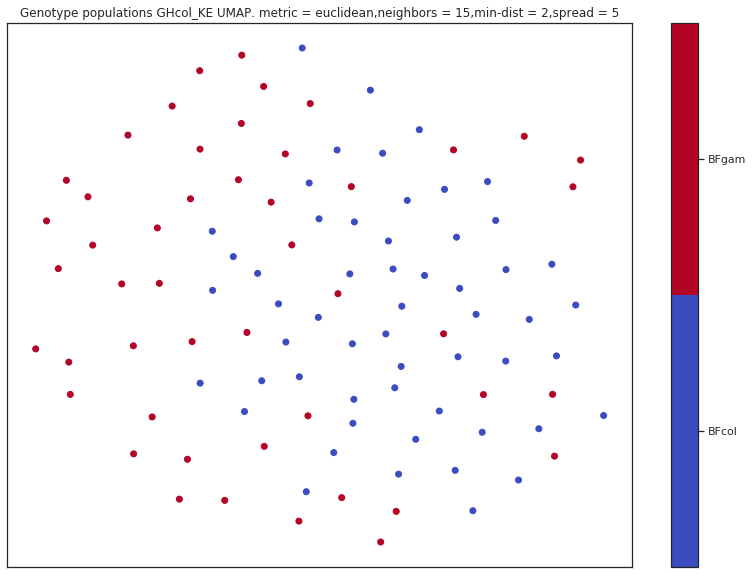

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GHcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 334)
2.) Filtering Rare Allels
Number of SNPs removed =  3443040
Retaining =  208680
3.) Performing LD Pruning
iteration 1 retaining 108291 removing 100389 variants
iteration 2 retaining 107114 removing 1177 variants
iteration 3 retaining 107062 removing 52 variants
Retained Haplotype Matrix =  (107062, 334)
Retained Positions Matrix =  (107062,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


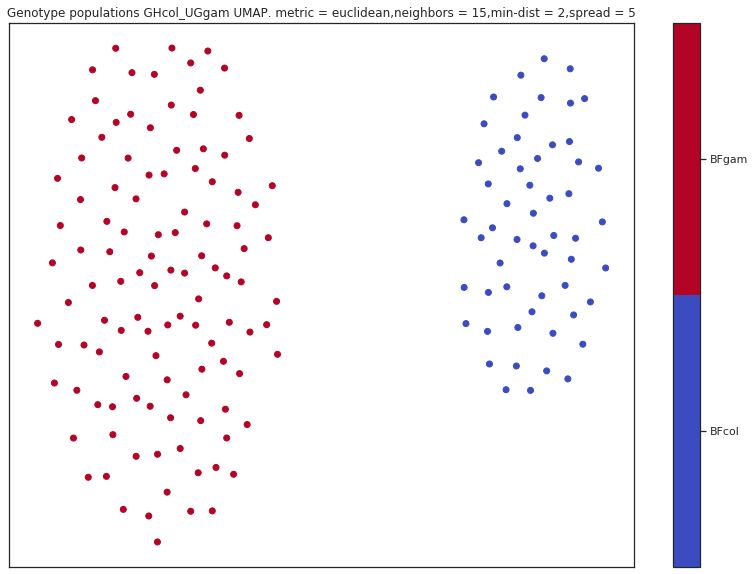

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GM_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 210)
2.) Filtering Rare Allels
Number of SNPs removed =  3437077
Retaining =  214643
3.) Performing LD Pruning
iteration 1 retaining 77249 removing 137394 variants
iteration 2 retaining 69324 removing 7925 variants
iteration 3 retaining 68500 removing 824 variants
Retained Haplotype Matrix =  (68500, 210)
Retained Positions Matrix =  (68500,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


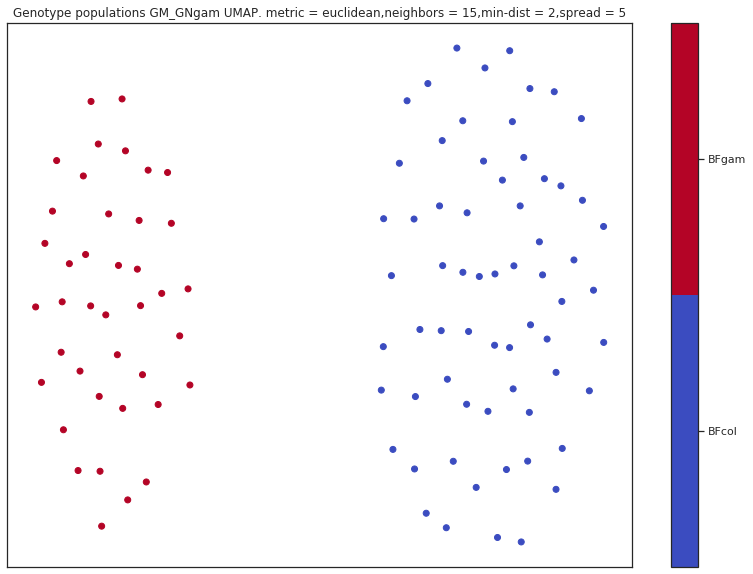

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GM_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 312)
2.) Filtering Rare Allels
Number of SNPs removed =  3434414
Retaining =  217306
3.) Performing LD Pruning
iteration 1 retaining 86794 removing 130512 variants
iteration 2 retaining 85284 removing 1510 variants
iteration 3 retaining 85205 removing 79 variants
Retained Haplotype Matrix =  (85205, 312)
Retained Positions Matrix =  (85205,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


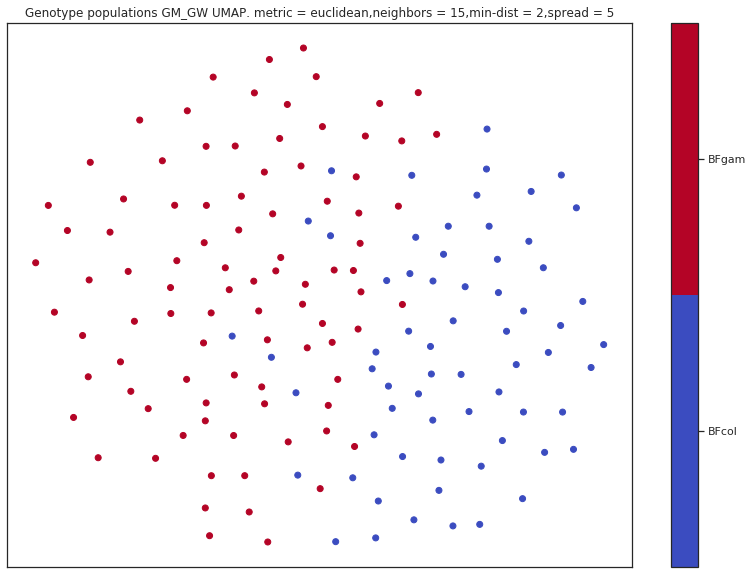

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GM_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 226)
2.) Filtering Rare Allels
Number of SNPs removed =  3447889
Retaining =  203831
3.) Performing LD Pruning
iteration 1 retaining 15730 removing 188101 variants
iteration 2 retaining 6192 removing 9538 variants
iteration 3 retaining 4230 removing 1962 variants
Retained Haplotype Matrix =  (4230, 226)
Retained Positions Matrix =  (4230,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


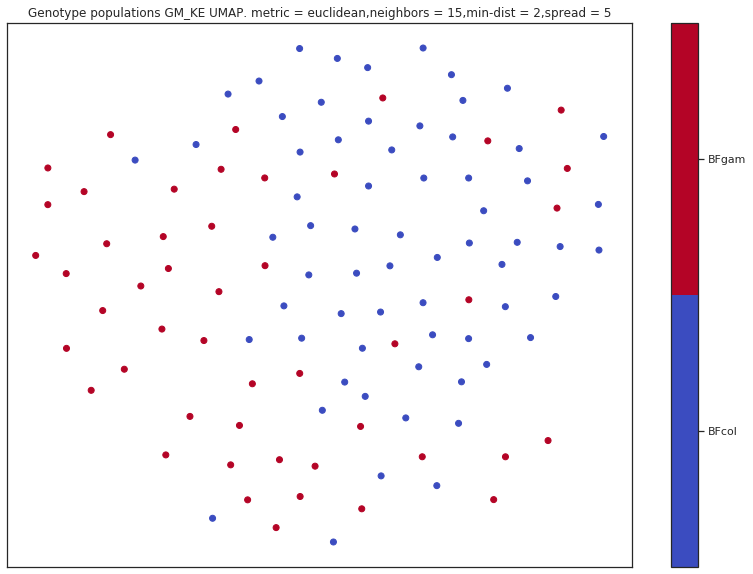

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GM_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 354)
2.) Filtering Rare Allels
Number of SNPs removed =  3440259
Retaining =  211461
3.) Performing LD Pruning
iteration 1 retaining 104095 removing 107366 variants
iteration 2 retaining 102322 removing 1773 variants
iteration 3 retaining 102247 removing 75 variants
Retained Haplotype Matrix =  (102247, 354)
Retained Positions Matrix =  (102247,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


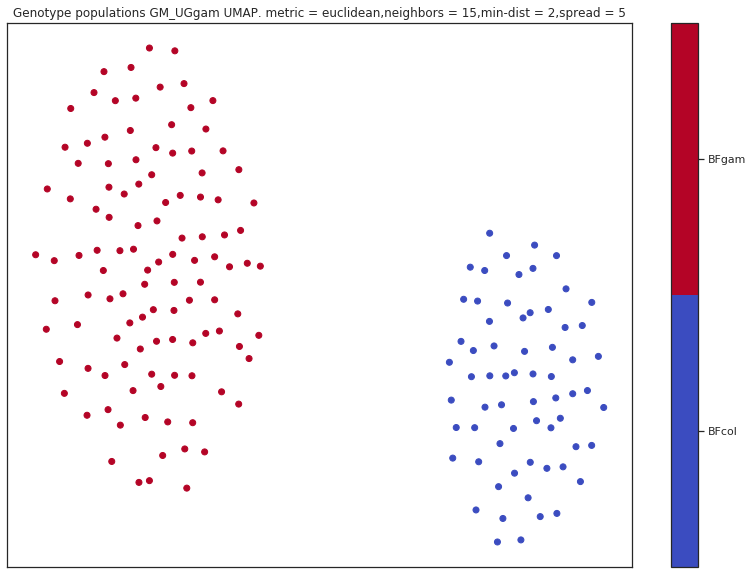

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GNgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 262)
2.) Filtering Rare Allels
Number of SNPs removed =  3446965
Retaining =  204755
3.) Performing LD Pruning
iteration 1 retaining 106394 removing 98361 variants
iteration 2 retaining 105560 removing 834 variants
iteration 3 retaining 105491 removing 69 variants
Retained Haplotype Matrix =  (105491, 262)
Retained Positions Matrix =  (105491,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


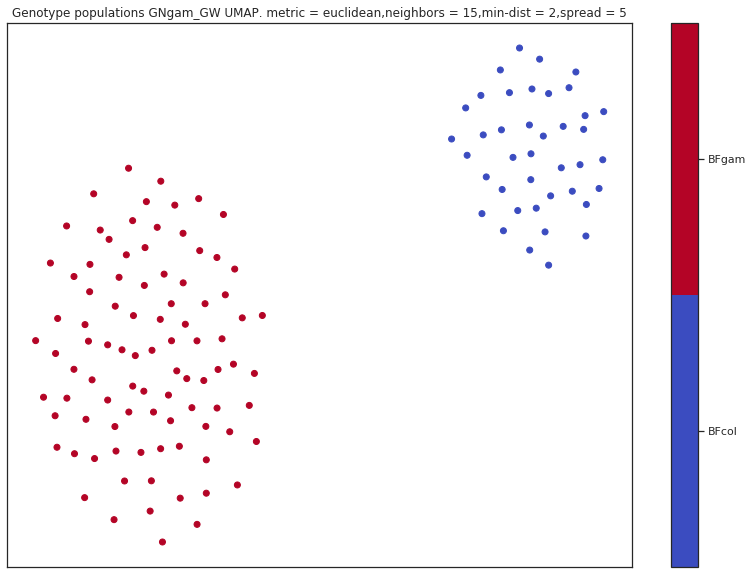

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GNgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 176)
2.) Filtering Rare Allels
Number of SNPs removed =  3468350
Retaining =  183370
3.) Performing LD Pruning
iteration 1 retaining 15379 removing 167991 variants
iteration 2 retaining 3453 removing 11926 variants
iteration 3 retaining 1279 removing 2174 variants
Retained Haplotype Matrix =  (1279, 176)
Retained Positions Matrix =  (1279,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


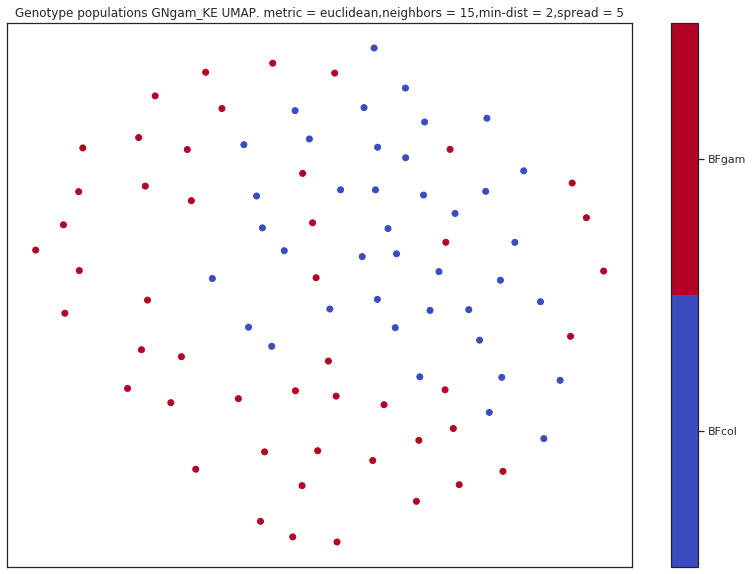

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GNgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 304)
2.) Filtering Rare Allels
Number of SNPs removed =  3446863
Retaining =  204857
3.) Performing LD Pruning
iteration 1 retaining 108327 removing 96530 variants
iteration 2 retaining 107300 removing 1027 variants
iteration 3 retaining 107262 removing 38 variants
Retained Haplotype Matrix =  (107262, 304)
Retained Positions Matrix =  (107262,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


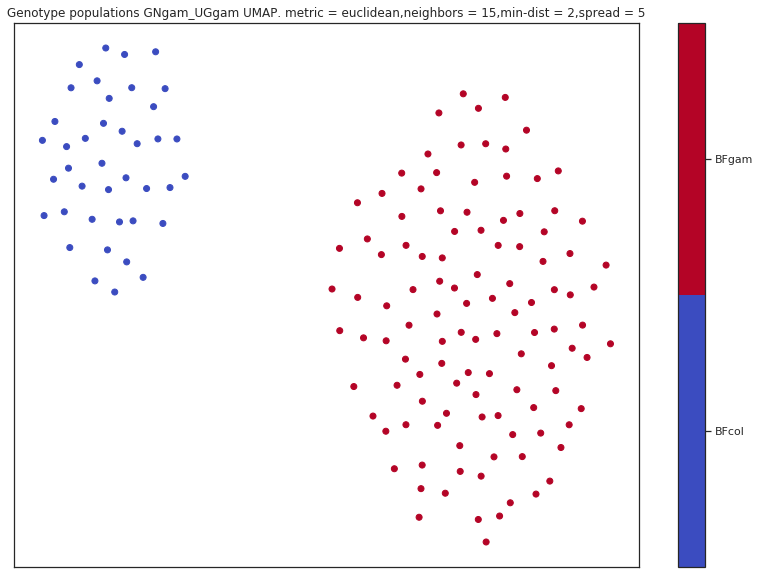

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GW_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 278)
2.) Filtering Rare Allels
Number of SNPs removed =  3442586
Retaining =  209134
3.) Performing LD Pruning
iteration 1 retaining 44768 removing 164366 variants
iteration 2 retaining 35623 removing 9145 variants
iteration 3 retaining 33925 removing 1698 variants
Retained Haplotype Matrix =  (33925, 278)
Retained Positions Matrix =  (33925,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


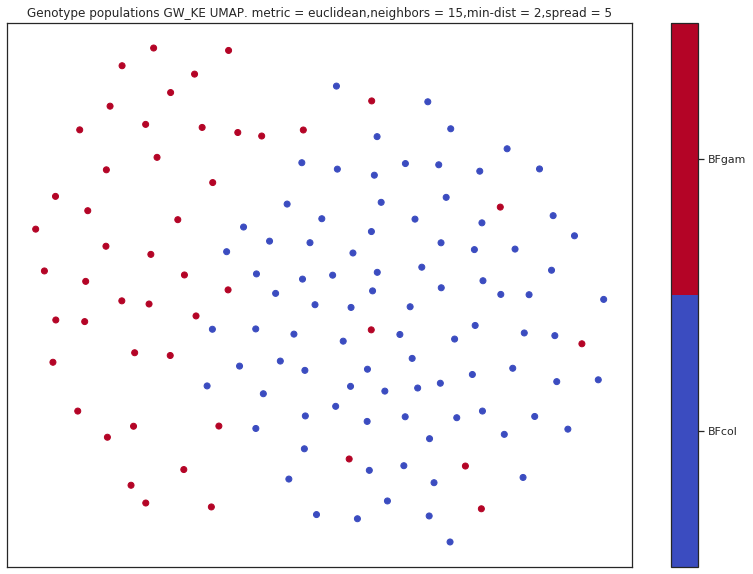

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


GW_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 406)
2.) Filtering Rare Allels
Number of SNPs removed =  3445870
Retaining =  205850
3.) Performing LD Pruning
iteration 1 retaining 113365 removing 92485 variants
iteration 2 retaining 112884 removing 481 variants
iteration 3 retaining 112864 removing 20 variants
Retained Haplotype Matrix =  (112864, 406)
Retained Positions Matrix =  (112864,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


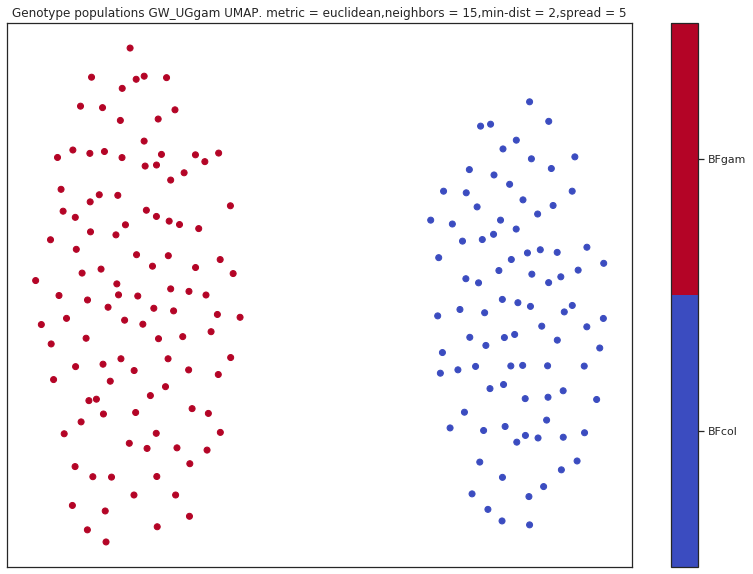

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


KE_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 320)
2.) Filtering Rare Allels
Number of SNPs removed =  3440839
Retaining =  210881
3.) Performing LD Pruning
iteration 1 retaining 54466 removing 156415 variants
iteration 2 retaining 47382 removing 7084 variants
iteration 3 retaining 46669 removing 713 variants
Retained Haplotype Matrix =  (46669, 320)
Retained Positions Matrix =  (46669,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


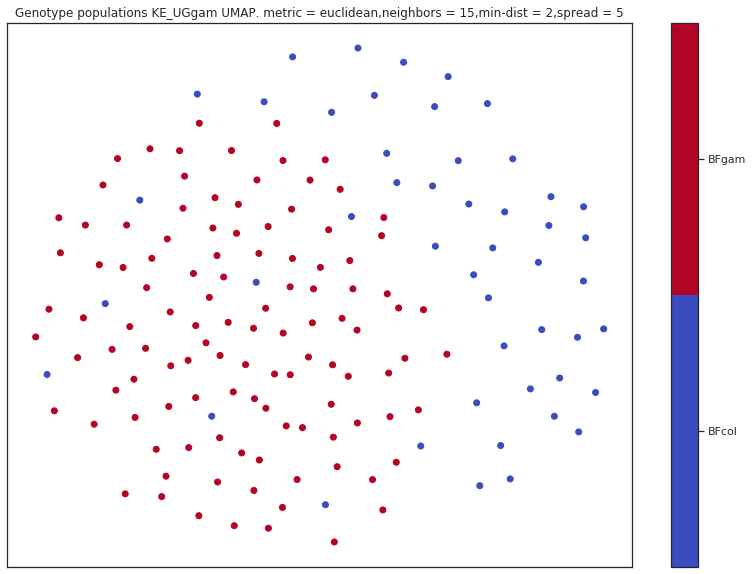

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


ValueError: Length of values (5) does not match length of index (66)

In [124]:
'''
Pairwise analysis of all the 12 populations.
Total 66 combinations/analysis
Analysis includes:
1. Selecting a pair
2. Filtering the SNPs jointly
    - Mega Base Pair Selection
    - Rare Allele Filtering with MAF >= 5%
    - LD Pruning
    Store Filtering stats for all the pairs
3. Haplo to Geno and Train-Test Split
4. Classifying using Logistic Regression and LDA
5. Generating UMAP visualization
6. Dimensionality Reduction: Obtaining 20 UMAP components 
7. Training LR classifier on UMAP components
8. Dumping all the stats and evaluation scores into a dataframe
'''
# Storage Path
home = home = os.path.expanduser('~')
directory = os.path.join(home,'Imp_Research','Repository','Pairwise_Analysis')

# List of keys
keys = list(H.keys())
count = 0
pnames = []
psamples = []
pmaf = []
psnps_init = []
psnps_filt = []
accuracy_lr = []
f1score_lr = []
kappa_lr = []
accuracy_ulr = []
f1score_ulr = []
kappa_ulr = []

# Edited to do damage control ! 
for i in range(11):
    for j in range(i+1,12):
        count+=1
        pair_pos = POS_all[keys[i]]
        # 1. Pair Selection. Combining the populations. 
        pop1 = H[keys[i]]
        pop2 = H[keys[j]]
        pair_h = np.append(pop1,pop2,1)
        pname = f'{keys[i][:-3]}_{keys[j][:-3]}'
        pnames.append(pname)
        psnps_init.append(pair_h.shape[0])
        psamples.append(pair_h.shape[1]/2)
        print(f'{pname}\n{psnp_init}')
        
        # 2. Filtering (Using FilterSNP class) Taking window size 250 is quicker.
        fsnp = FilterSNP(pair_h,pair_pos)
        pair_h, pair_pos = fsnp.all_filters(LD_window_size = 500,LD_overlap_step = 150,LD_iter = 3)
        psnps_filt.append(pair_h.shape[0])
        pmaf.append(fsnp._retained_maf)
#         ppos_filt = len(pair_pos)
        
        # 3. Haplo to Geno and Train-Test Split
        X = pair_h.T
        Xg = to_genotype(X)       #Genotype data
        pshape_g = Xg.shape
        Y = [0]*int(len(pop1[0])/2)
        Y.extend([1]*int(len(pop2[0])/2))
        Y = np.array(Y)
        x_train,x_test,y_train,y_test = train_test_split(Xg,Y,test_size = 0.2,stratify = Y,random_state= R_SEED)
        
        # 4. LR Classifier
        lr = LogisticRegression(n_jobs = -1)
        lr.fit(x_train,y_train)
        acc_lr, f1w_lr, kap_lr = evaluate_classifier(y_test,lr.predict(x_test))
        accuracy_lr.append(acc_lr)
        f1score_lr.append(f1w_lr)
        kappa_lr.append(kap_lr)
        
        # 5. Generate UMAP visualization
        UMAP_g = umap.UMAP(n_neighbors=15,metric='euclidean',min_dist=2,spread=5).fit_transform(Xg)
        sns.set(style='white')
        fig, ax = plt.subplots(1, figsize=(14, 10))
        plt.scatter(UMAP_g[:, 0],UMAP_g[:, 1],c=Y,cmap='coolwarm')
        plt.setp(ax, xticks=[], yticks=[])
        cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
        cbar.set_ticks(np.arange(2))
        cbar.set_ticklabels(populations)
        plt.title(f'Genotype populations {pname} UMAP. metric = euclidean,neighbors = 15,min-dist = 2,spread = 5');
        figname = f'{count}_{pname}_umap.png'
        path = os.path.join(directory,'pairwise_plots',figname)
        plt.savefig(path,dpi=100)
        plt.show() 
        # calling plt.show() before saving clears all the graph
        
        # 6. Dimensionality Reduction: Obtaining 20 umap components
        UMAP_g = umap.UMAP(n_components = 20,n_neighbors=15,metric='euclidean',min_dist=2,spread=5).fit(x_train)
        x_train = UMAP_g.embedding_
        x_test = UMAP_g.transform(x_test)
        
        # 7. Training LR on UMAP components
        ulr = LogisticRegression(n_jobs = -1)
        ulr.fit(x_train,y_train)
        acc_ulr, f1w_ulr, kap_ulr = evaluate_classifier(y_test,ulr.predict(x_test))
        accuracy_ulr.append(acc_ulr)
        f1score_ulr.append(f1w_ulr)
        kappa_ulr.append(kap_ulr)
    
pairwise_analysis = pd.DataFrame()
pairwise_analysis['Count'] = range(1,len(pnames)+1)
pairwise_analysis['Population_pair'] = pnames
pairwise_analysis['Samples'] = psamples
pairwise_analysis['Initial_SNP'] = psnps_init
pairwise_analysis['MAF_filter_SNP'] = pmaf
pairwise_analysis['Filtered_SNP'] = psnps_filt
pairwise_analysis['LR_accuracy'] = accuracy_lr
pairwise_analysis['LR_f1score'] = f1score_lr
pairwise_analysis['LR_kappa'] = kappa_lr
pairwise_analysis['UMAP_LR_accuracy'] = accuracy_ulr
pairwise_analysis['UMAP_LR_f1score'] = f1score_ulr
pairwise_analysis['UMAP_LR_kappa'] = kappa_ulr

# Errored at i = 5, j = 8, count = 48, pname = 'GAgam_GNgam'
# status: UMAP saved but no data. Also 20 components exceeded some samples.
# because I messed up (-_-) took test size 80% (-_-)(*_*)


print(pairwise_analysis)
path = os.path.join(directory,'Pairwise_Analysis_Stats.csv')
pairwise_analysis.to_csv(path,index= False)


In [128]:
path = os.path.join(directory,'Pairwise_Analysis_Stats_Euclidean_UMAP.csv')
pairwise_analysis.to_csv(path,index= False)

In [127]:
pairwise_analysis.head(50)

Count Population_pair  Samples  Initial_SNP  MAF_filter_SNP  Filtered_SNP  \
0       1     BFcol_BFgam    167.0      4836295          202928        116947   
1       2     BFcol_AOcol    153.0      4836295          196218         61477   
2       3     BFcol_CIcol    146.0      4836295          206852         91924   
3       4     BFcol_CMgam    175.0      4836295          200832        117855   
4       5     BFcol_GAgam    144.0      4836295          218226         52373   
5       6     BFcol_GHcol    130.0      4836295          209195         99782   
6       7        BFcol_GM    140.0      4836295          213948         95080   
7       8     BFcol_GNgam    115.0      4836295          200373        111014   
8       9        BFcol_GW    166.0      4836295          206882        111254   
9      10        BFcol_KE    123.0      4836295          192085         21719   
10     11     BFcol_UGgam    187.0      4836295          205039        114456   
11     12     BFgam_AOcol    170.0      4836295          207088         69339   
12     13     BFgam_CIcol    163.0      4836295          204334        102654   
13     14     BFgam_CMgam    192.0      4836295          201889        113461   
14     15     BFgam_GAgam    161.0      4836295          215988         59156   
15     16     BFgam_GHcol    147.0      4836295          207173        108392   
16     17        BFgam_GM    157.0      4836295          210501         99979   
17     18     BFgam_GNgam    132.0      4836295          203447        105816   
18     19        BFgam_GW    183.0      4836295          204333        113954   
19     20        BFgam_KE    140.0      4836295          205403         37312   
20     21     BFgam_UGgam    204.0      4836295          204547        113845   
21     22     AOcol_CIcol    149.0      4836295          207682         46424   
22     23     AOcol_CMgam    178.0      4836295          205542         74067   
23     24     AOcol_GAgam    147.0      4836295          227616         19320   
24     25     AOcol_GHcol    133.0      4836295          199242         41458   
25     26        AOcol_GM    143.0      4836295          206985         37741   
26     27     AOcol_GNgam    118.0      4836295          201758         34738   
27     28        AOcol_GW    169.0      4836295          210052         66857   
28     29        AOcol_KE    126.0      4836295          208538          4681   
29     30     AOcol_UGgam    190.0      4836295          210194         74624   
30     31     CIcol_CMgam    171.0      4836295          201711        105937   
31     32     CIcol_GAgam    140.0      4836295          232069         35845   
32     33     CIcol_GHcol    126.0      4836295          214330         68829   
33     34        CIcol_GM    136.0      4836295          216401         72688   
34     35     CIcol_GNgam    111.0      4836295          204304         81277   
35     36        CIcol_GW    162.0      4836295          208239         96376   
36     37        CIcol_KE    119.0      4836295          207263          9296   
37     38     CIcol_UGgam    183.0      4836295          205603        103720   
38     39     CMgam_GAgam    169.0      4836295          222474         64916   
39     40     CMgam_GHcol    155.0      4836295          204446        111144   
40     41        CMgam_GM    165.0      4836295          207508        103963   
41     42     CMgam_GNgam    140.0      4836295          209639        114441   
42     43        CMgam_GW    191.0      4836295          202630        115315   
43     44        CMgam_KE    148.0      4836295          204786         44654   
44     45     CMgam_UGgam    212.0      4836295          202990        114190   
45     46     GAgam_GHcol    124.0      4836295          224908         29067   
46     47        GAgam_GM    134.0      4836295          228423         26819   
47     48     GAgam_GNgam    109.0      4836295          229276         22083   
48     49        GAgam_GW    160.0 

BFcol_BFgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 334)
2.) Filtering Rare Allels
Number of SNPs removed =  3448792
Retaining =  202928
3.) Performing LD Pruning
BFcol_AOcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 306)
2.) Filtering Rare Allels
Number of SNPs removed =  3455502
Retaining =  196218
3.) Performing LD Pruning
iteration 1 retaining 66893 removing 129325 variants
iteration 2 retaining 62345 removing 4548 variants
iteration 3 retaining 61911 removing 434 variants
Retained Haplotype Matrix =  (61911, 306)
Retained Positions Matrix =  (61911,)
Unique Labels:  [0 1]
BFcol : 75, _AOcol : 78


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


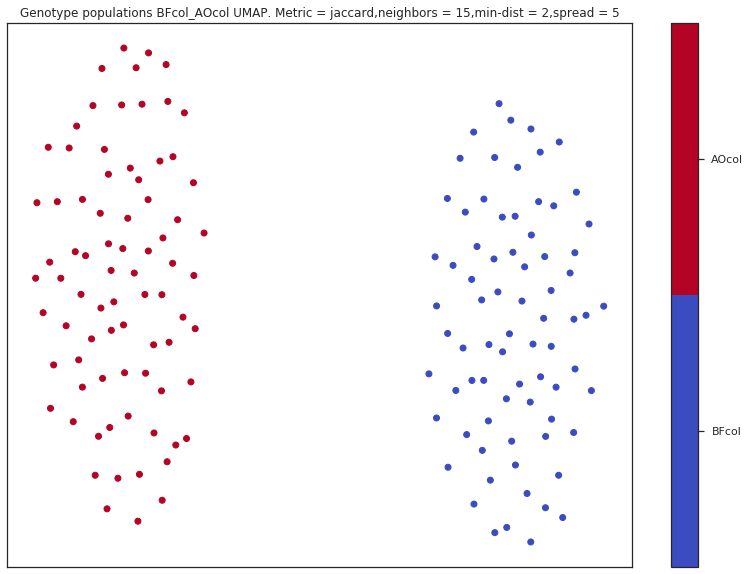

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFcol_CIcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 292)
2.) Filtering Rare Allels
Number of SNPs removed =  3444868
Retaining =  206852
3.) Performing LD Pruning
iteration 1 retaining 93624 removing 113228 variants
iteration 2 retaining 91752 removing 1872 variants
iteration 3 retaining 91634 removing 118 variants
Retained Haplotype Matrix =  (91634, 292)
Retained Positions Matrix =  (91634,)
Unique Labels:  [0 1]
BFcol : 75, _CIcol : 71


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


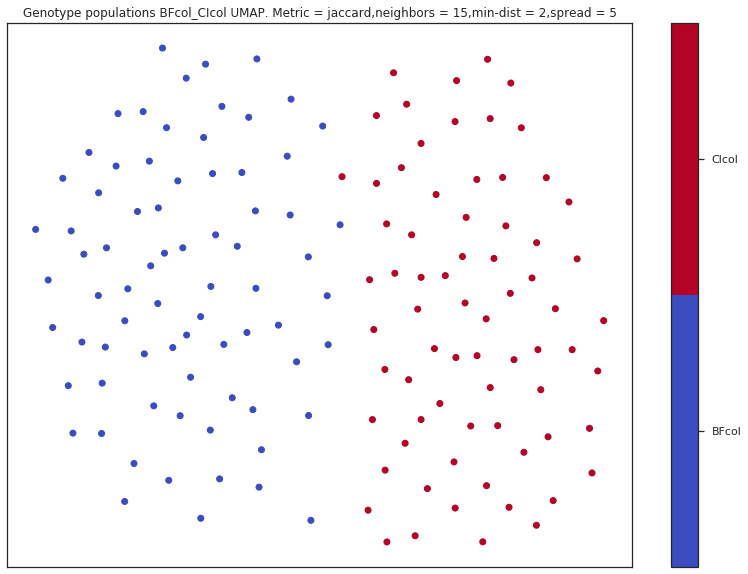

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFcol_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 350)
2.) Filtering Rare Allels
Number of SNPs removed =  3450888
Retaining =  200832
3.) Performing LD Pruning
iteration 1 retaining 119307 removing 81525 variants
iteration 2 retaining 118153 removing 1154 variants
iteration 3 retaining 118031 removing 122 variants
Retained Haplotype Matrix =  (118031, 350)
Retained Positions Matrix =  (118031,)
Unique Labels:  [0 1]
BFcol : 75, _CMgam : 100


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


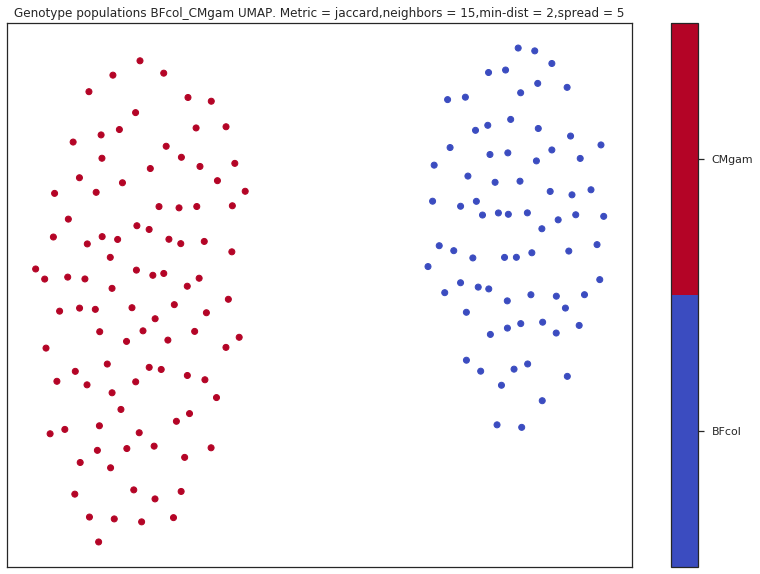

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFcol_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 288)
2.) Filtering Rare Allels
Number of SNPs removed =  3433494
Retaining =  218226
3.) Performing LD Pruning
iteration 1 retaining 62526 removing 155700 variants
iteration 2 retaining 52984 removing 9542 variants
iteration 3 retaining 52077 removing 907 variants
Retained Haplotype Matrix =  (52077, 288)
Retained Positions Matrix =  (52077,)
Unique Labels:  [0 1]
BFcol : 75, _GAgam : 69


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


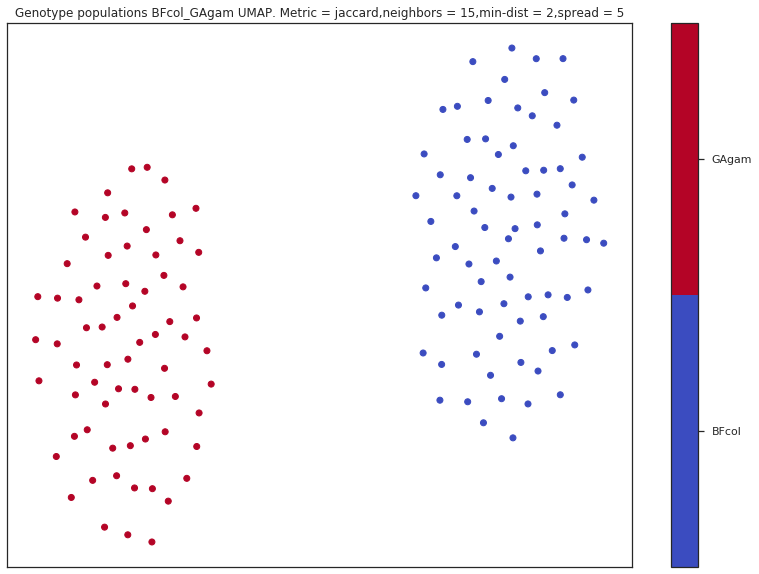

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFcol_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 260)
2.) Filtering Rare Allels
Number of SNPs removed =  3442525
Retaining =  209195
3.) Performing LD Pruning
iteration 1 retaining 101212 removing 107983 variants
iteration 2 retaining 100029 removing 1183 variants
iteration 3 retaining 99926 removing 103 variants
Retained Haplotype Matrix =  (99926, 260)
Retained Positions Matrix =  (99926,)
Unique Labels:  [0 1]
BFcol : 75, _GHcol : 55


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


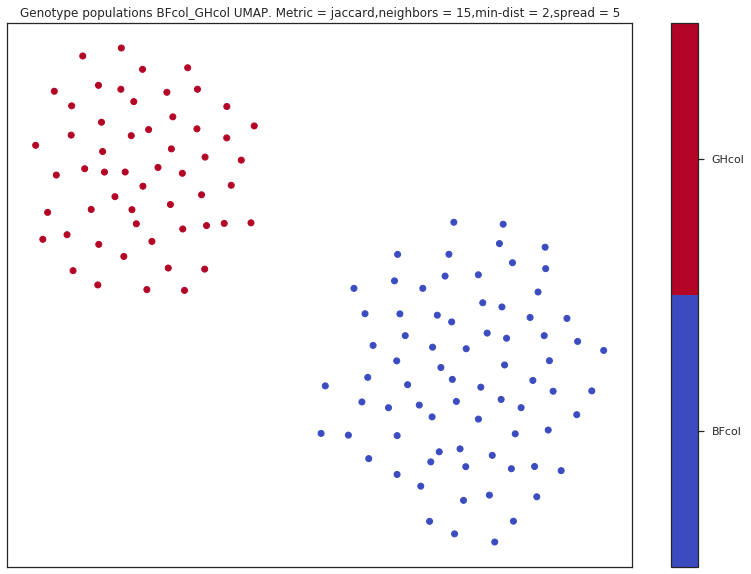

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3437772
Retaining =  213948
3.) Performing LD Pruning
iteration 1 retaining 100357 removing 113591 variants
iteration 2 retaining 96421 removing 3936 variants
iteration 3 retaining 95963 removing 458 variants
Retained Haplotype Matrix =  (95963, 280)
Retained Positions Matrix =  (95963,)
Unique Labels:  [0 1]
BFcol : 75, _GM : 65


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


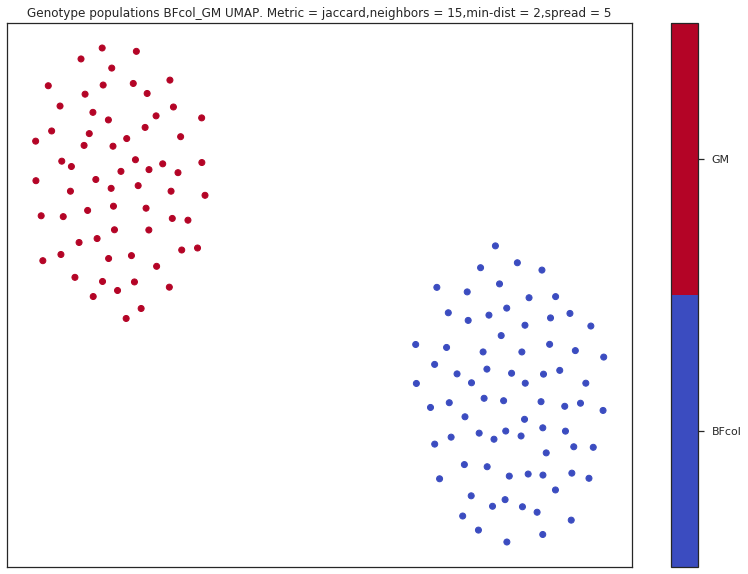

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 230)
2.) Filtering Rare Allels
Number of SNPs removed =  3451347
Retaining =  200373
3.) Performing LD Pruning
iteration 1 retaining 114156 removing 86217 variants
iteration 2 retaining 112503 removing 1653 variants
iteration 3 retaining 112287 removing 216 variants
Retained Haplotype Matrix =  (112287, 230)
Retained Positions Matrix =  (112287,)
Unique Labels:  [0 1]
BFcol : 75, _GNgam : 40


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


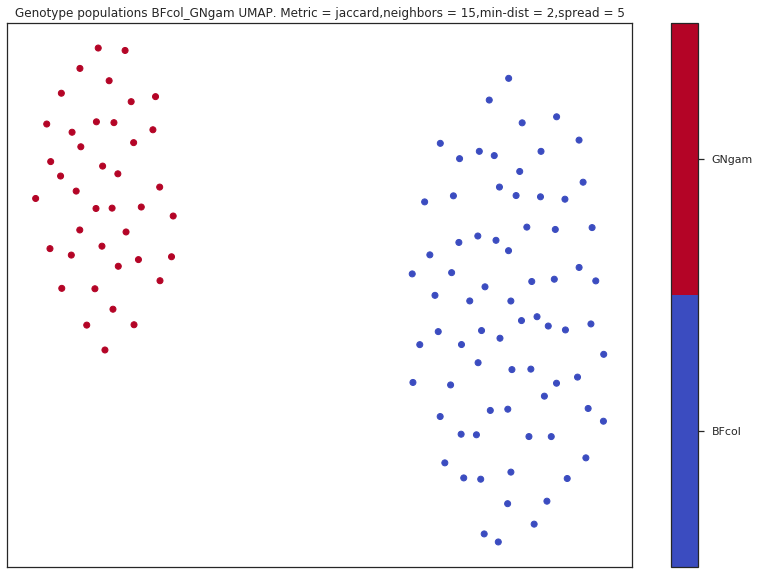

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFcol_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 332)
2.) Filtering Rare Allels
Number of SNPs removed =  3444838
Retaining =  206882
3.) Performing LD Pruning
iteration 1 retaining 111715 removing 95167 variants
iteration 2 retaining 111239 removing 476 variants
iteration 3 retaining 111223 removing 16 variants
Retained Haplotype Matrix =  (111223, 332)
Retained Positions Matrix =  (111223,)
Unique Labels:  [0 1]
BFcol : 75, _GW : 91


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


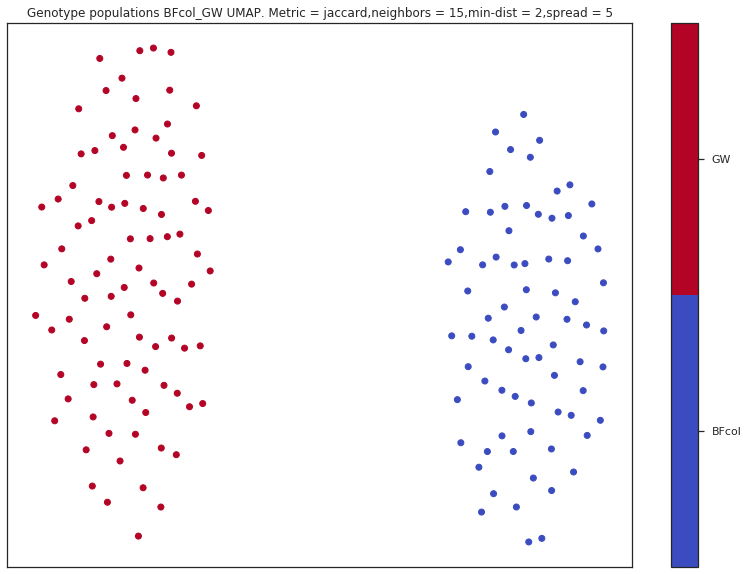

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 246)
2.) Filtering Rare Allels
Number of SNPs removed =  3459635
Retaining =  192085
3.) Performing LD Pruning
iteration 1 retaining 44636 removing 147449 variants
iteration 2 retaining 32722 removing 11914 variants
iteration 3 retaining 29700 removing 3022 variants
Retained Haplotype Matrix =  (29700, 246)
Retained Positions Matrix =  (29700,)
Unique Labels:  [0 1]
BFcol : 75, _KE : 48


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


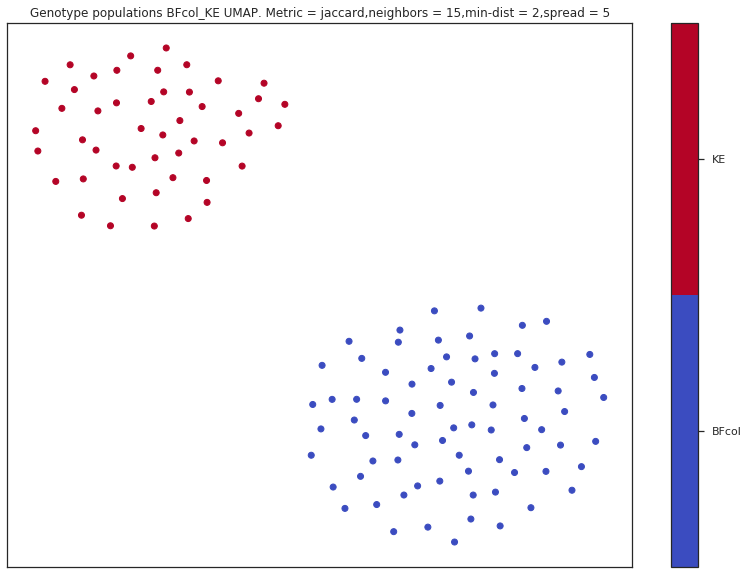

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 374)
2.) Filtering Rare Allels
Number of SNPs removed =  3446681
Retaining =  205039
3.) Performing LD Pruning
iteration 1 retaining 115941 removing 89098 variants
iteration 2 retaining 114581 removing 1360 variants
iteration 3 retaining 114473 removing 108 variants
Retained Haplotype Matrix =  (114473, 374)
Retained Positions Matrix =  (114473,)
Unique Labels:  [0 1]
BFcol : 75, _UGgam : 112


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


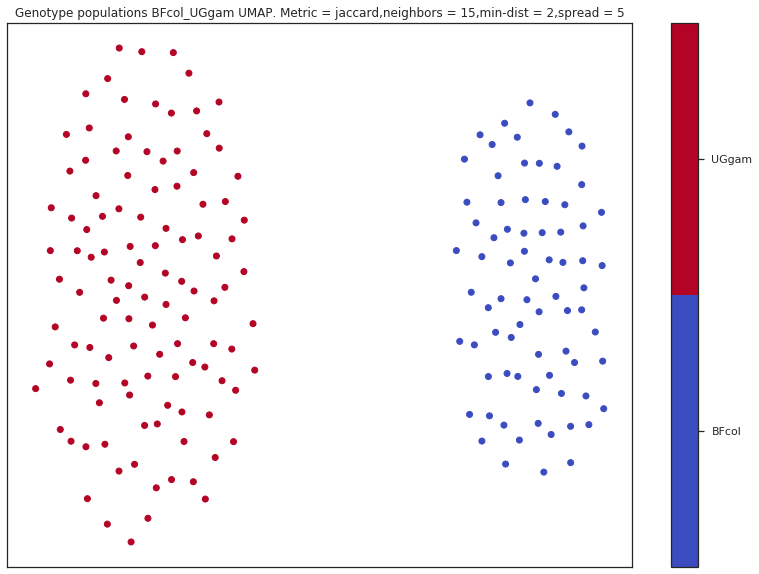

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFgam_AOcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 340)
2.) Filtering Rare Allels
Number of SNPs removed =  3444632
Retaining =  207088
3.) Performing LD Pruning
iteration 1 retaining 75265 removing 131823 variants
iteration 2 retaining 70019 removing 5246 variants
iteration 3 retaining 69555 removing 464 variants
Retained Haplotype Matrix =  (69555, 340)
Retained Positions Matrix =  (69555,)
Unique Labels:  [0 1]
BFgam : 92, _AOcol : 78


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


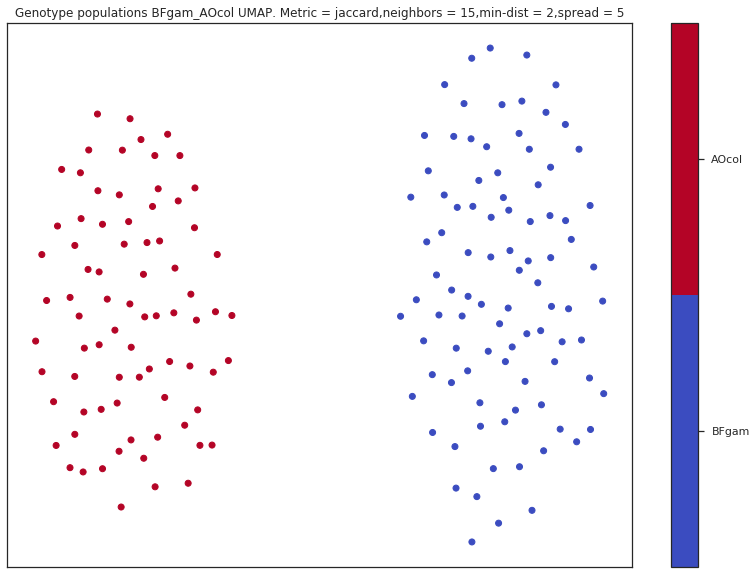

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFgam_CIcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 326)
2.) Filtering Rare Allels
Number of SNPs removed =  3447386
Retaining =  204334
3.) Performing LD Pruning
iteration 1 retaining 105472 removing 98862 variants
iteration 2 retaining 102901 removing 2571 variants
iteration 3 retaining 102661 removing 240 variants
Retained Haplotype Matrix =  (102661, 326)
Retained Positions Matrix =  (102661,)
Unique Labels:  [0 1]
BFgam : 92, _CIcol : 71


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


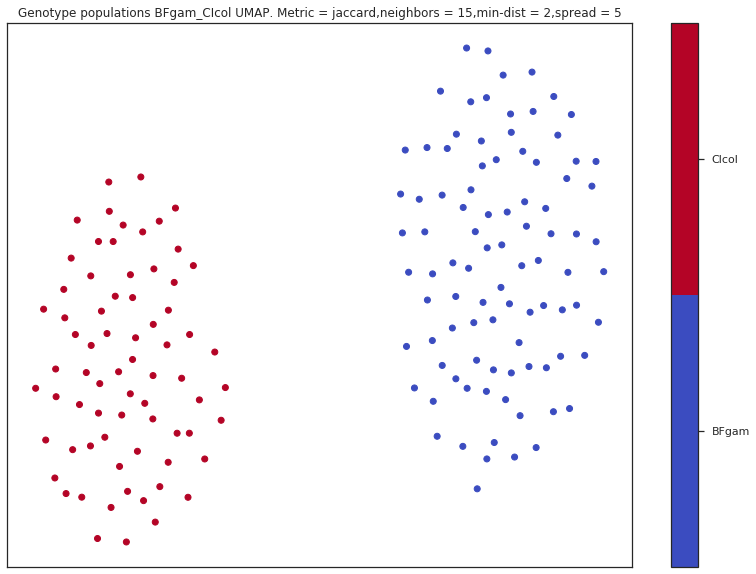

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFgam_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 384)
2.) Filtering Rare Allels
Number of SNPs removed =  3449831
Retaining =  201889
3.) Performing LD Pruning
iteration 1 retaining 115181 removing 86708 variants
iteration 2 retaining 113602 removing 1579 variants
iteration 3 retaining 113457 removing 145 variants
Retained Haplotype Matrix =  (113457, 384)
Retained Positions Matrix =  (113457,)
Unique Labels:  [0 1]
BFgam : 92, _CMgam : 100


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


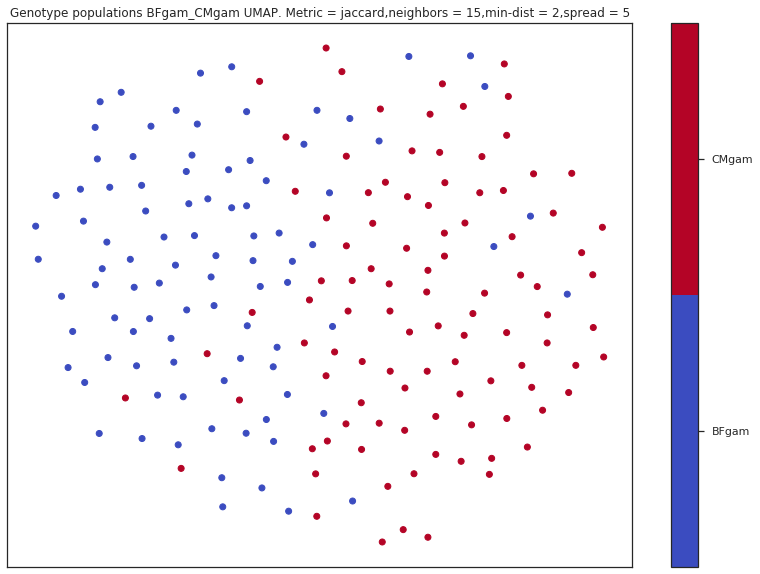

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFgam_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 322)
2.) Filtering Rare Allels
Number of SNPs removed =  3435732
Retaining =  215988
3.) Performing LD Pruning
iteration 1 retaining 67662 removing 148326 variants
iteration 2 retaining 59021 removing 8641 variants
iteration 3 retaining 58249 removing 772 variants
Retained Haplotype Matrix =  (58249, 322)
Retained Positions Matrix =  (58249,)
Unique Labels:  [0 1]
BFgam : 92, _GAgam : 69


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


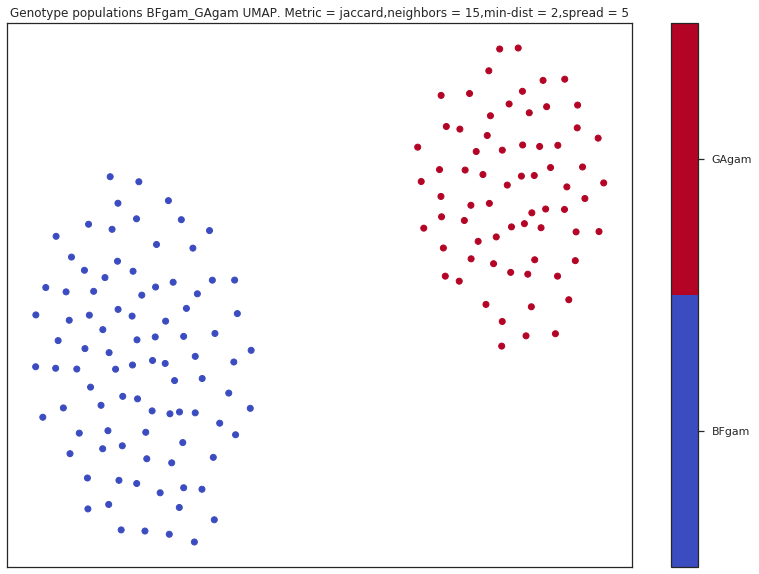

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFgam_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 294)
2.) Filtering Rare Allels
Number of SNPs removed =  3444547
Retaining =  207173
3.) Performing LD Pruning
iteration 1 retaining 111219 removing 95954 variants
iteration 2 retaining 108901 removing 2318 variants
iteration 3 retaining 108662 removing 239 variants
Retained Haplotype Matrix =  (108662, 294)
Retained Positions Matrix =  (108662,)
Unique Labels:  [0 1]
BFgam : 92, _GHcol : 55


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


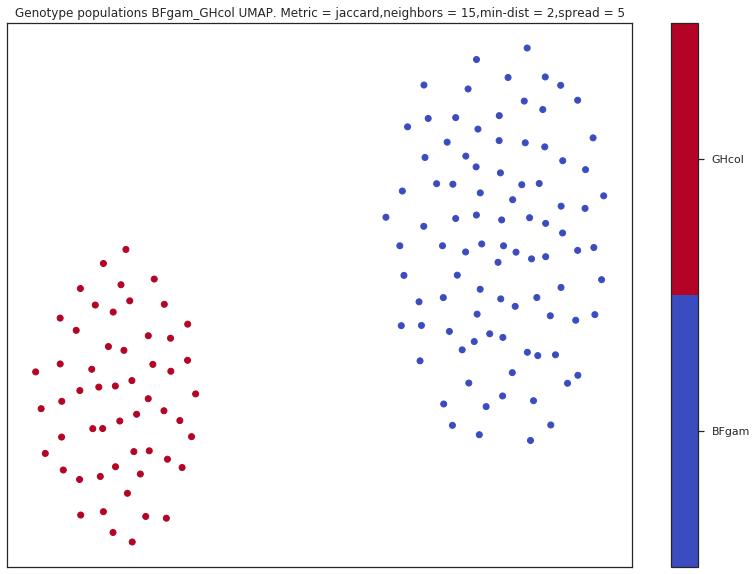

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFgam_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 314)
2.) Filtering Rare Allels
Number of SNPs removed =  3441219
Retaining =  210501
3.) Performing LD Pruning
iteration 1 retaining 104872 removing 105629 variants
iteration 2 retaining 101022 removing 3850 variants
iteration 3 retaining 100563 removing 459 variants
Retained Haplotype Matrix =  (100563, 314)
Retained Positions Matrix =  (100563,)
Unique Labels:  [0 1]
BFgam : 92, _GM : 65


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


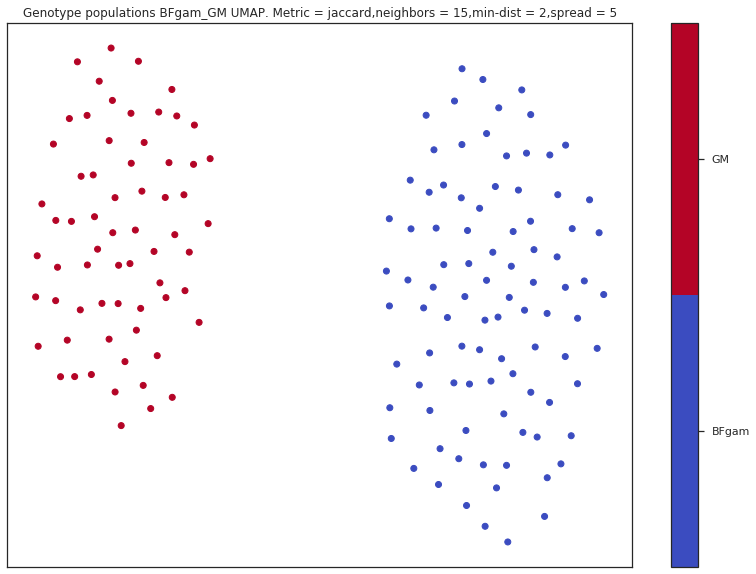

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFgam_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 264)
2.) Filtering Rare Allels
Number of SNPs removed =  3448273
Retaining =  203447
3.) Performing LD Pruning
iteration 1 retaining 109187 removing 94260 variants
iteration 2 retaining 106476 removing 2711 variants
iteration 3 retaining 106226 removing 250 variants
Retained Haplotype Matrix =  (106226, 264)
Retained Positions Matrix =  (106226,)
Unique Labels:  [0 1]
BFgam : 92, _GNgam : 40


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


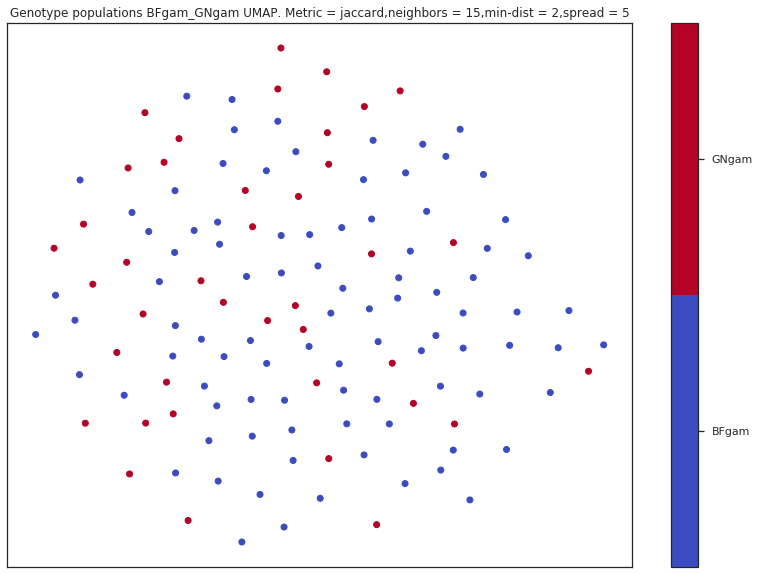

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 366)
2.) Filtering Rare Allels
Number of SNPs removed =  3447387
Retaining =  204333
3.) Performing LD Pruning
iteration 1 retaining 115046 removing 89287 variants
iteration 2 retaining 113908 removing 1138 variants
iteration 3 retaining 113845 removing 63 variants
Retained Haplotype Matrix =  (113845, 366)
Retained Positions Matrix =  (113845,)
Unique Labels:  [0 1]
BFgam : 92, _GW : 91


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


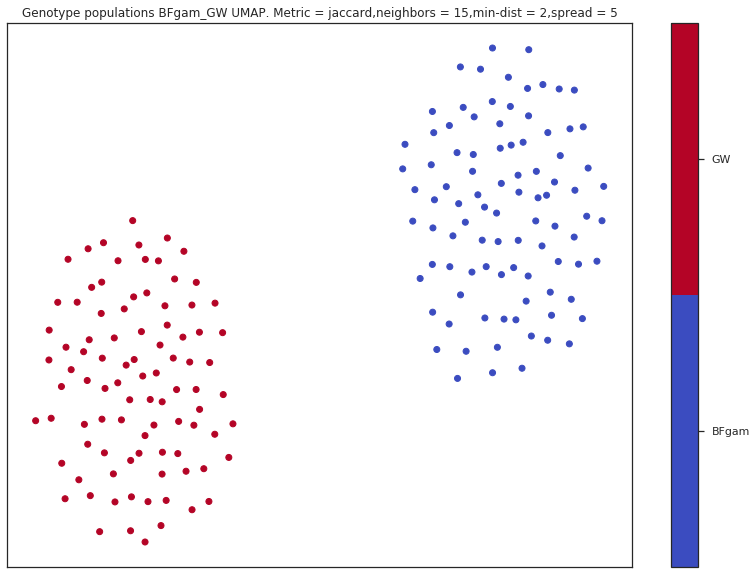

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3446317
Retaining =  205403
3.) Performing LD Pruning
iteration 1 retaining 54510 removing 150893 variants
iteration 2 retaining 43582 removing 10928 variants
iteration 3 retaining 41730 removing 1852 variants
Retained Haplotype Matrix =  (41730, 280)
Retained Positions Matrix =  (41730,)
Unique Labels:  [0 1]
BFgam : 92, _KE : 48


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


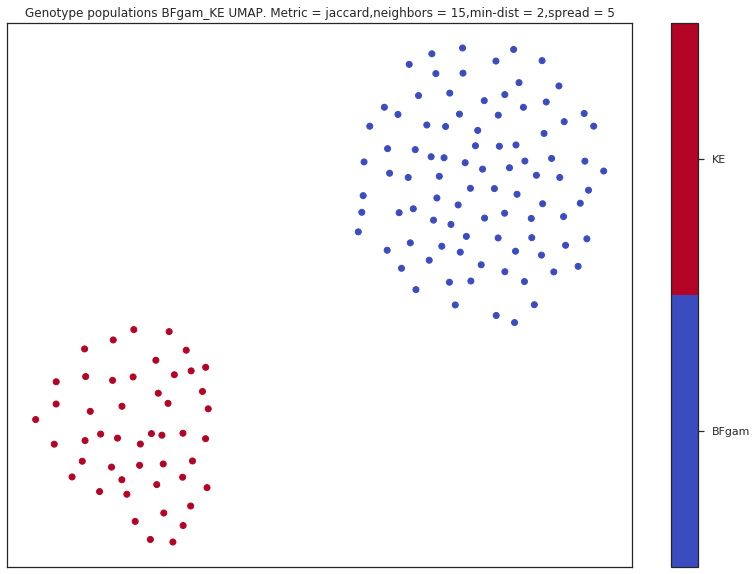

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


BFgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 408)
2.) Filtering Rare Allels
Number of SNPs removed =  3447173
Retaining =  204547
3.) Performing LD Pruning
iteration 1 retaining 115177 removing 89370 variants
iteration 2 retaining 113817 removing 1360 variants
iteration 3 retaining 113718 removing 99 variants
Retained Haplotype Matrix =  (113718, 408)
Retained Positions Matrix =  (113718,)
Unique Labels:  [0 1]
BFgam : 92, _UGgam : 112


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


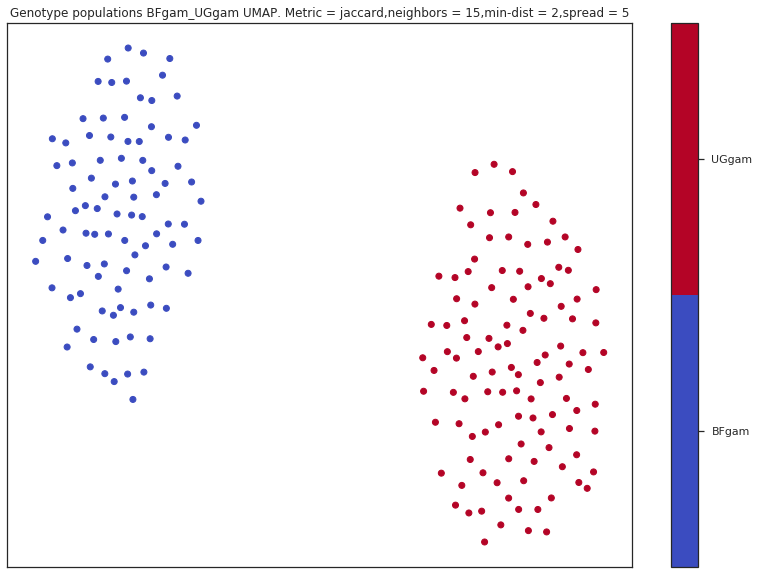

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


AOcol_CIcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 298)
2.) Filtering Rare Allels
Number of SNPs removed =  3444038
Retaining =  207682
3.) Performing LD Pruning
iteration 1 retaining 53851 removing 153831 variants
iteration 2 retaining 46150 removing 7701 variants
iteration 3 retaining 45620 removing 530 variants
Retained Haplotype Matrix =  (45620, 298)
Retained Positions Matrix =  (45620,)
Unique Labels:  [0 1]
AOcol : 78, _CIcol : 71


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


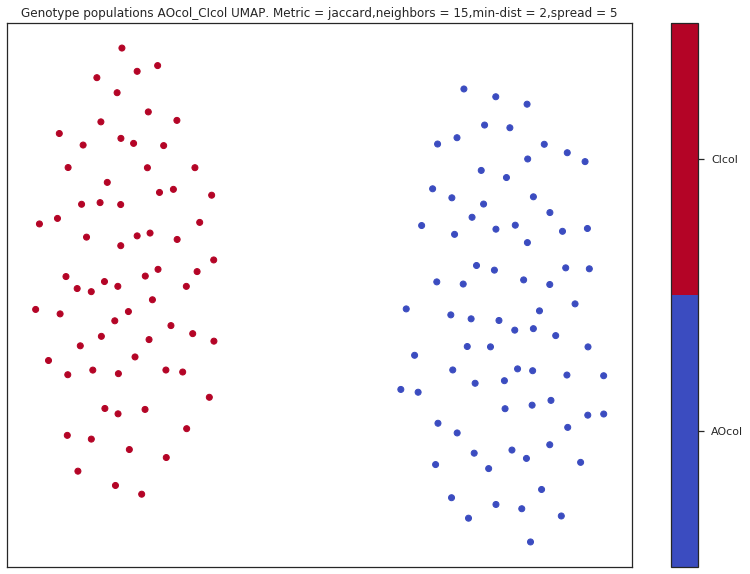

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


AOcol_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 356)
2.) Filtering Rare Allels
Number of SNPs removed =  3446178
Retaining =  205542
3.) Performing LD Pruning
iteration 1 retaining 78991 removing 126551 variants
iteration 2 retaining 74458 removing 4533 variants
iteration 3 retaining 74009 removing 449 variants
Retained Haplotype Matrix =  (74009, 356)
Retained Positions Matrix =  (74009,)
Unique Labels:  [0 1]
AOcol : 78, _CMgam : 100


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


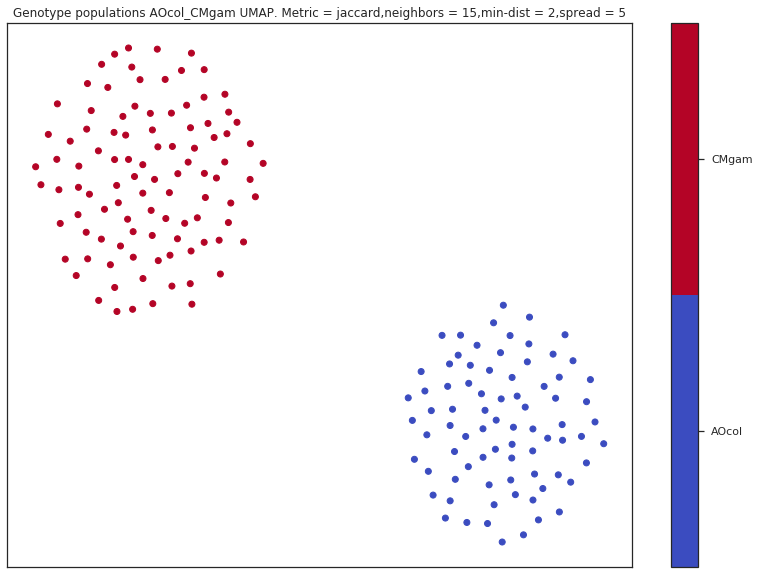

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


AOcol_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 294)
2.) Filtering Rare Allels
Number of SNPs removed =  3424104
Retaining =  227616
3.) Performing LD Pruning
iteration 1 retaining 29946 removing 197670 variants
iteration 2 retaining 18617 removing 11329 variants
iteration 3 retaining 18086 removing 531 variants
Retained Haplotype Matrix =  (18086, 294)
Retained Positions Matrix =  (18086,)
Unique Labels:  [0 1]
AOcol : 78, _GAgam : 69


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


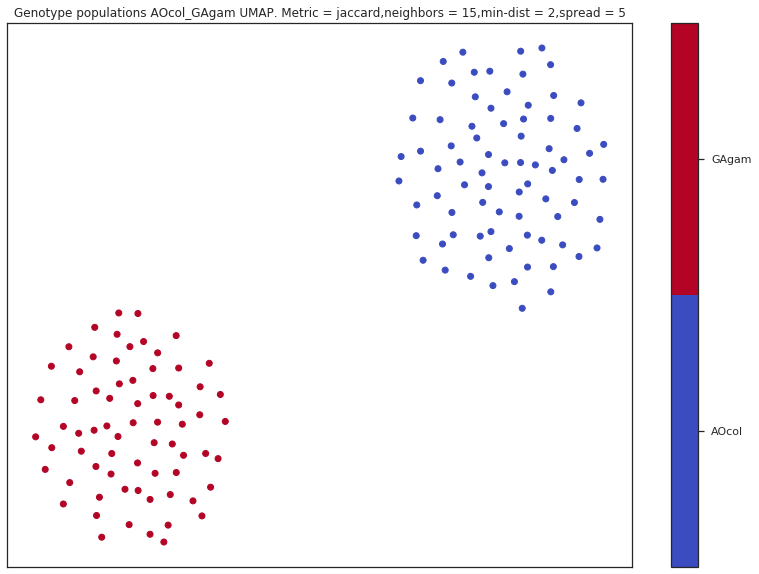

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


AOcol_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 266)
2.) Filtering Rare Allels
Number of SNPs removed =  3452478
Retaining =  199242
3.) Performing LD Pruning
iteration 1 retaining 49776 removing 149466 variants
iteration 2 retaining 42335 removing 7441 variants
iteration 3 retaining 41676 removing 659 variants
Retained Haplotype Matrix =  (41676, 266)
Retained Positions Matrix =  (41676,)
Unique Labels:  [0 1]
AOcol : 78, _GHcol : 55


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


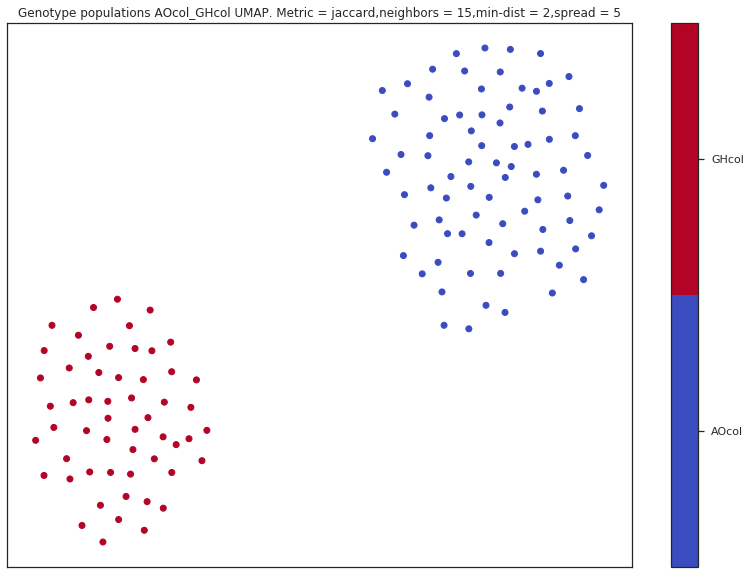

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


AOcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 286)
2.) Filtering Rare Allels
Number of SNPs removed =  3444735
Retaining =  206985
3.) Performing LD Pruning
iteration 1 retaining 48105 removing 158880 variants
iteration 2 retaining 38032 removing 10073 variants
iteration 3 retaining 37138 removing 894 variants
Retained Haplotype Matrix =  (37138, 286)
Retained Positions Matrix =  (37138,)
Unique Labels:  [0 1]
AOcol : 78, _GM : 65


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


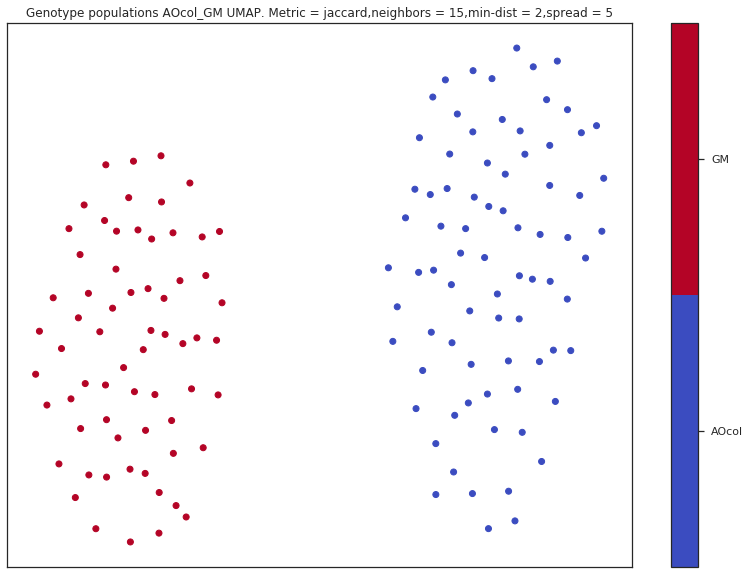

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


AOcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 236)
2.) Filtering Rare Allels
Number of SNPs removed =  3449962
Retaining =  201758
3.) Performing LD Pruning
iteration 1 retaining 46233 removing 155525 variants
iteration 2 retaining 36439 removing 9794 variants
iteration 3 retaining 35277 removing 1162 variants
Retained Haplotype Matrix =  (35277, 236)
Retained Positions Matrix =  (35277,)
Unique Labels:  [0 1]
AOcol : 78, _GNgam : 40


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


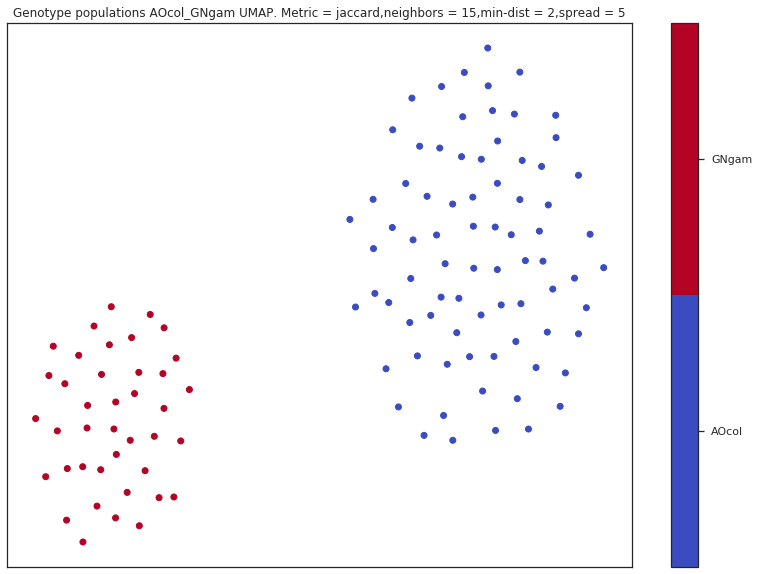

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


AOcol_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 338)
2.) Filtering Rare Allels
Number of SNPs removed =  3441668
Retaining =  210052
3.) Performing LD Pruning
iteration 1 retaining 71336 removing 138716 variants
iteration 2 retaining 67038 removing 4298 variants
iteration 3 retaining 66730 removing 308 variants
Retained Haplotype Matrix =  (66730, 338)
Retained Positions Matrix =  (66730,)
Unique Labels:  [0 1]
AOcol : 78, _GW : 91


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


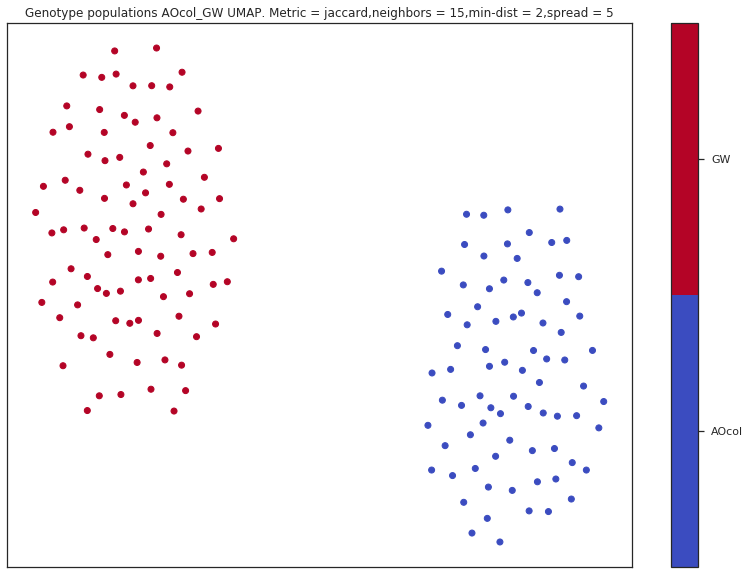

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


AOcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 252)
2.) Filtering Rare Allels
Number of SNPs removed =  3443182
Retaining =  208538
3.) Performing LD Pruning
iteration 1 retaining 16062 removing 192476 variants
iteration 2 retaining 6411 removing 9651 variants
iteration 3 retaining 5304 removing 1107 variants
Retained Haplotype Matrix =  (5304, 252)
Retained Positions Matrix =  (5304,)
Unique Labels:  [0 1]
AOcol : 78, _KE : 48


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


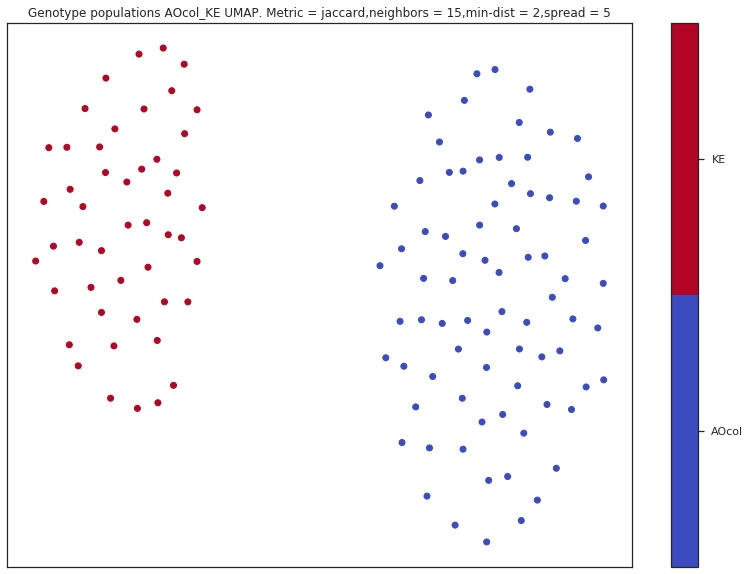

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


AOcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 380)
2.) Filtering Rare Allels
Number of SNPs removed =  3441526
Retaining =  210194
3.) Performing LD Pruning
iteration 1 retaining 78841 removing 131353 variants
iteration 2 retaining 74555 removing 4286 variants
iteration 3 retaining 74205 removing 350 variants
Retained Haplotype Matrix =  (74205, 380)
Retained Positions Matrix =  (74205,)
Unique Labels:  [0 1]
AOcol : 78, _UGgam : 112


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


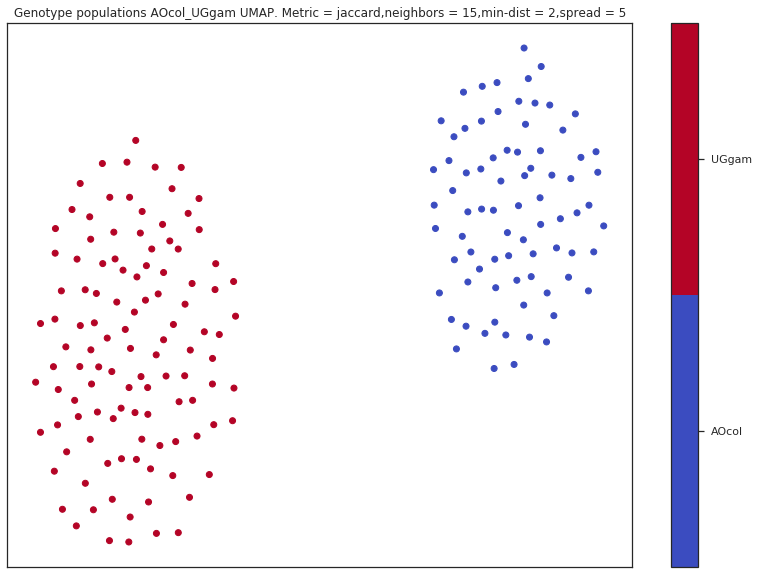

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CIcol_CMgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 342)
2.) Filtering Rare Allels
Number of SNPs removed =  3450009
Retaining =  201711
3.) Performing LD Pruning
iteration 1 retaining 108297 removing 93414 variants
iteration 2 retaining 106133 removing 2164 variants
iteration 3 retaining 105937 removing 196 variants
Retained Haplotype Matrix =  (105937, 342)
Retained Positions Matrix =  (105937,)
Unique Labels:  [0 1]
CIcol : 71, _CMgam : 100


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


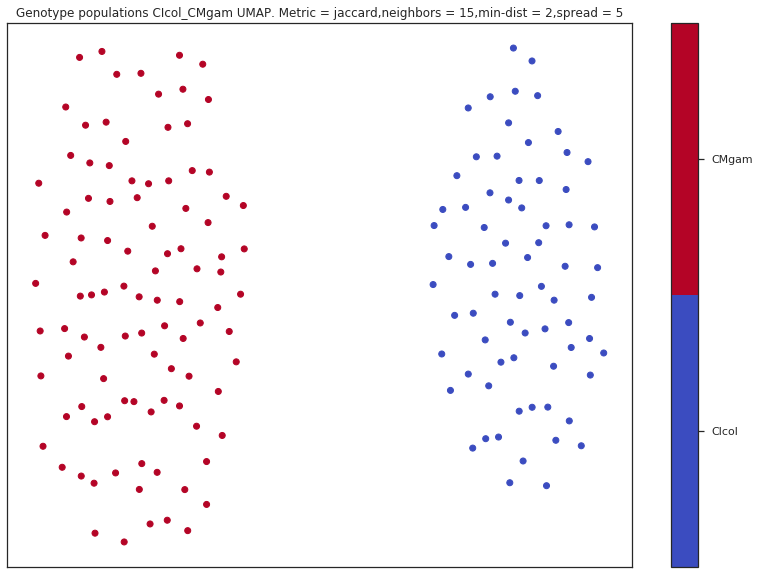

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CIcol_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3419651
Retaining =  232069
3.) Performing LD Pruning
iteration 1 retaining 48346 removing 183723 variants
iteration 2 retaining 35496 removing 12850 variants
iteration 3 retaining 34586 removing 910 variants
Retained Haplotype Matrix =  (34586, 280)
Retained Positions Matrix =  (34586,)
Unique Labels:  [0 1]
CIcol : 71, _GAgam : 69


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


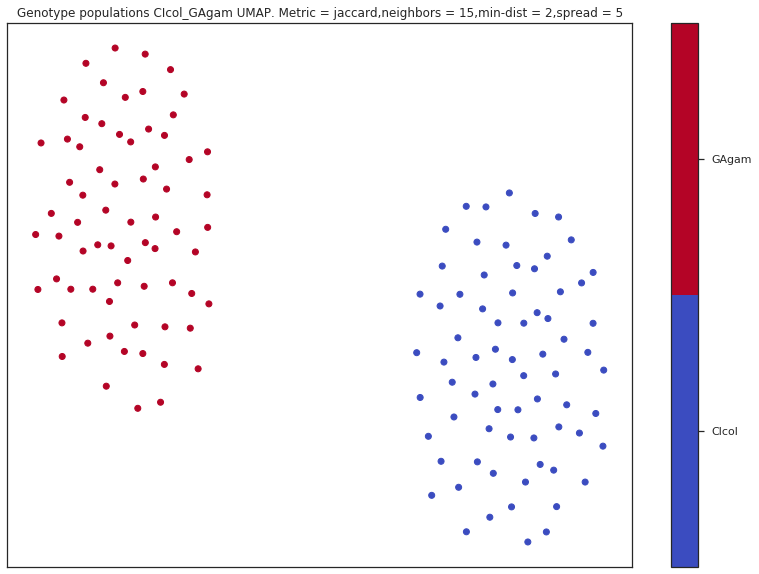

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CIcol_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 252)
2.) Filtering Rare Allels
Number of SNPs removed =  3437390
Retaining =  214330
3.) Performing LD Pruning
iteration 1 retaining 72222 removing 142108 variants
iteration 2 retaining 68108 removing 4114 variants
iteration 3 retaining 67923 removing 185 variants
Retained Haplotype Matrix =  (67923, 252)
Retained Positions Matrix =  (67923,)
Unique Labels:  [0 1]
CIcol : 71, _GHcol : 55


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


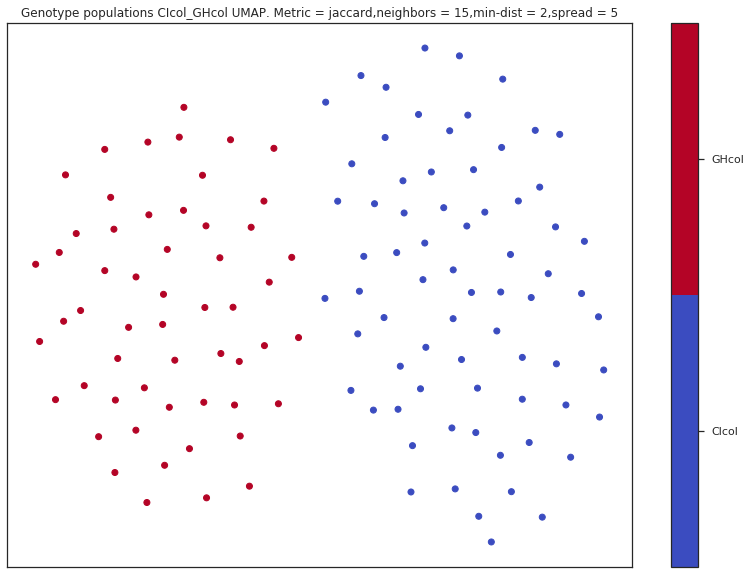

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CIcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 272)
2.) Filtering Rare Allels
Number of SNPs removed =  3435319
Retaining =  216401
3.) Performing LD Pruning
iteration 1 retaining 79981 removing 136420 variants
iteration 2 retaining 73227 removing 6754 variants
iteration 3 retaining 72602 removing 625 variants
Retained Haplotype Matrix =  (72602, 272)
Retained Positions Matrix =  (72602,)
Unique Labels:  [0 1]
CIcol : 71, _GM : 65


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


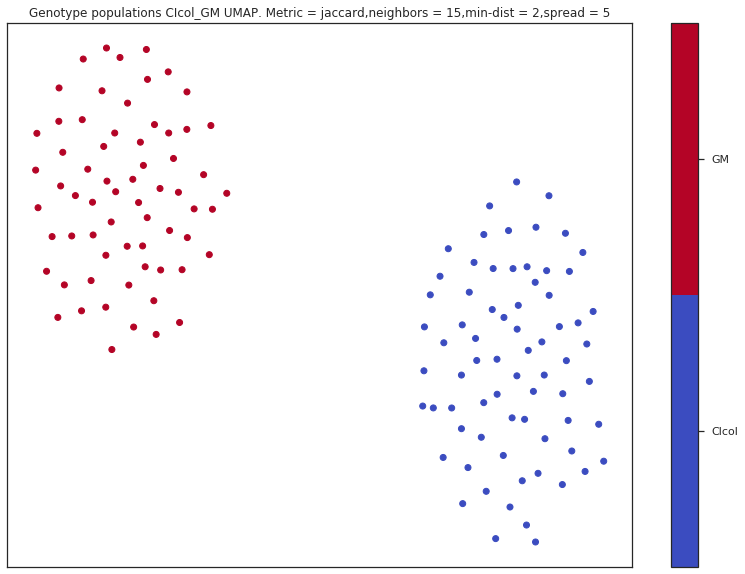

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CIcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 222)
2.) Filtering Rare Allels
Number of SNPs removed =  3447416
Retaining =  204304
3.) Performing LD Pruning
iteration 1 retaining 87456 removing 116848 variants
iteration 2 retaining 82374 removing 5082 variants
iteration 3 retaining 81889 removing 485 variants
Retained Haplotype Matrix =  (81889, 222)
Retained Positions Matrix =  (81889,)
Unique Labels:  [0 1]
CIcol : 71, _GNgam : 40


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


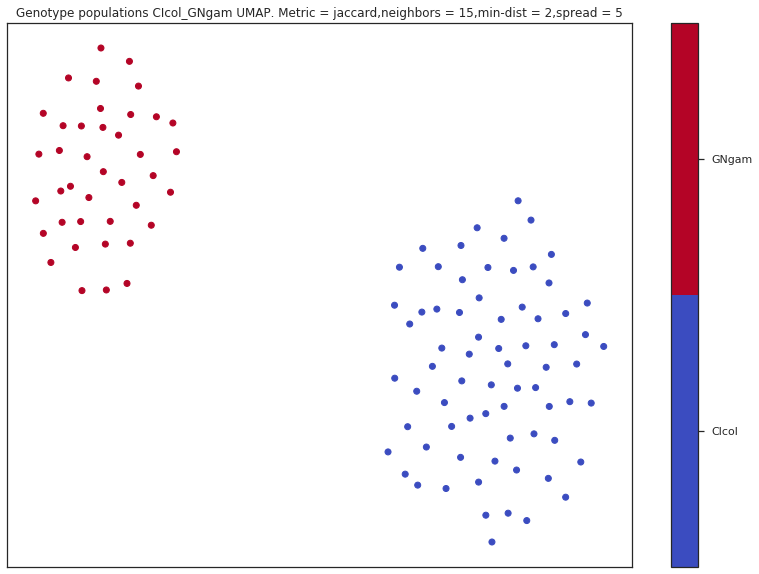

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CIcol_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 324)
2.) Filtering Rare Allels
Number of SNPs removed =  3443481
Retaining =  208239
3.) Performing LD Pruning
iteration 1 retaining 97730 removing 110509 variants
iteration 2 retaining 96235 removing 1495 variants
iteration 3 retaining 96149 removing 86 variants
Retained Haplotype Matrix =  (96149, 324)
Retained Positions Matrix =  (96149,)
Unique Labels:  [0 1]
CIcol : 71, _GW : 91


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


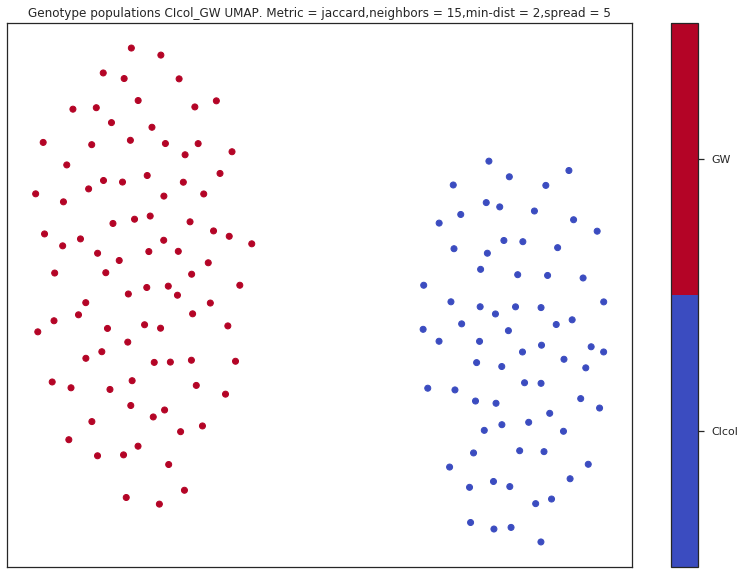

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CIcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 238)
2.) Filtering Rare Allels
Number of SNPs removed =  3444457
Retaining =  207263
3.) Performing LD Pruning
iteration 1 retaining 27165 removing 180098 variants
iteration 2 retaining 14806 removing 12359 variants
iteration 3 retaining 12374 removing 2432 variants
Retained Haplotype Matrix =  (12374, 238)
Retained Positions Matrix =  (12374,)
Unique Labels:  [0 1]
CIcol : 71, _KE : 48


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


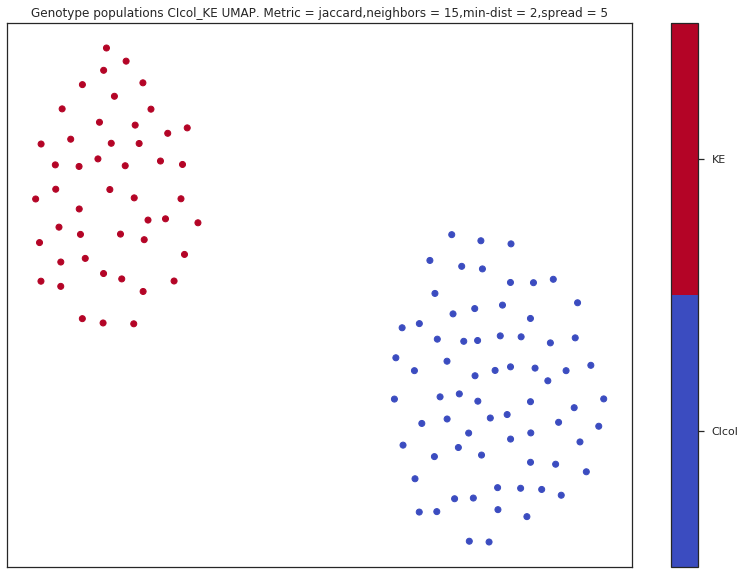

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CIcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 366)
2.) Filtering Rare Allels
Number of SNPs removed =  3446117
Retaining =  205603
3.) Performing LD Pruning
iteration 1 retaining 106044 removing 99559 variants
iteration 2 retaining 103765 removing 2279 variants
iteration 3 retaining 103564 removing 201 variants
Retained Haplotype Matrix =  (103564, 366)
Retained Positions Matrix =  (103564,)
Unique Labels:  [0 1]
CIcol : 71, _UGgam : 112


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


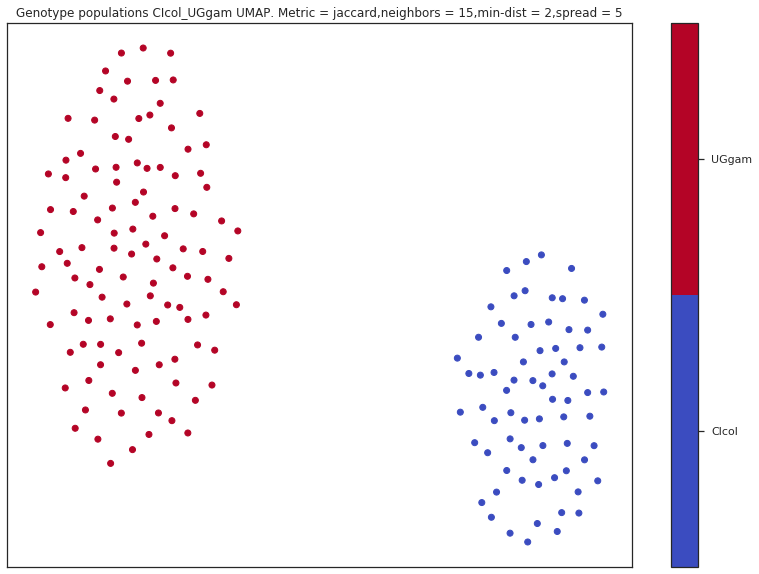

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CMgam_GAgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 338)
2.) Filtering Rare Allels
Number of SNPs removed =  3429246
Retaining =  222474
3.) Performing LD Pruning
iteration 1 retaining 73077 removing 149397 variants
iteration 2 retaining 64857 removing 8220 variants
iteration 3 retaining 64123 removing 734 variants
Retained Haplotype Matrix =  (64123, 338)
Retained Positions Matrix =  (64123,)
Unique Labels:  [0 1]
CMgam : 100, _GAgam : 69


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


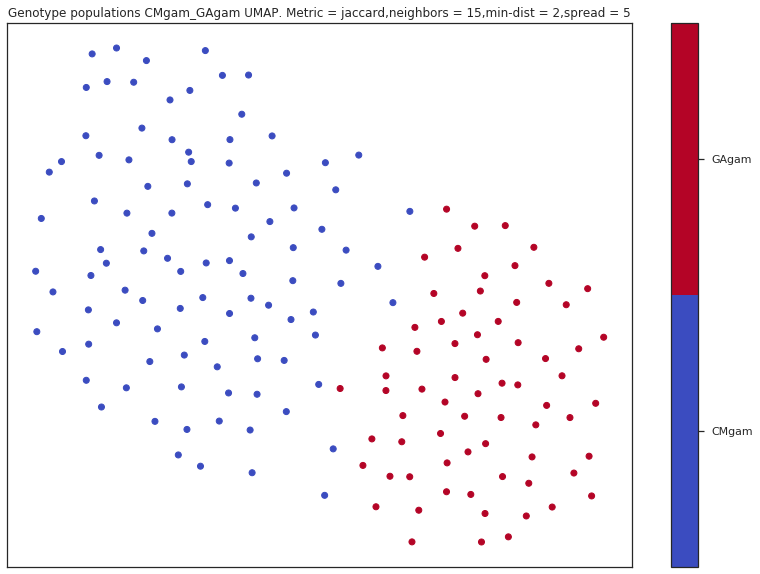

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CMgam_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 310)
2.) Filtering Rare Allels
Number of SNPs removed =  3447274
Retaining =  204446
3.) Performing LD Pruning
iteration 1 retaining 113573 removing 90873 variants
iteration 2 retaining 111701 removing 1872 variants
iteration 3 retaining 111487 removing 214 variants
Retained Haplotype Matrix =  (111487, 310)
Retained Positions Matrix =  (111487,)
Unique Labels:  [0 1]
CMgam : 100, _GHcol : 55


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


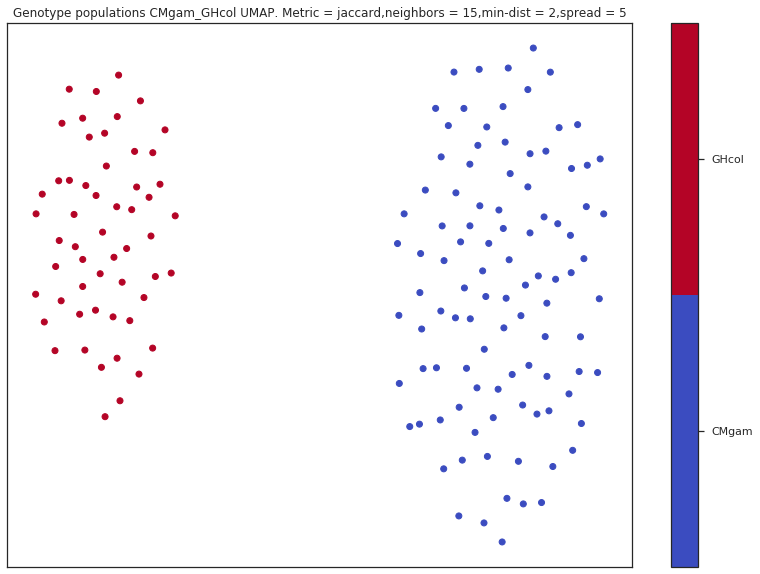

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CMgam_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 330)
2.) Filtering Rare Allels
Number of SNPs removed =  3444212
Retaining =  207508
3.) Performing LD Pruning
iteration 1 retaining 108024 removing 99484 variants
iteration 2 retaining 104940 removing 3084 variants
iteration 3 retaining 104545 removing 395 variants
Retained Haplotype Matrix =  (104545, 330)
Retained Positions Matrix =  (104545,)
Unique Labels:  [0 1]
CMgam : 100, _GM : 65


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


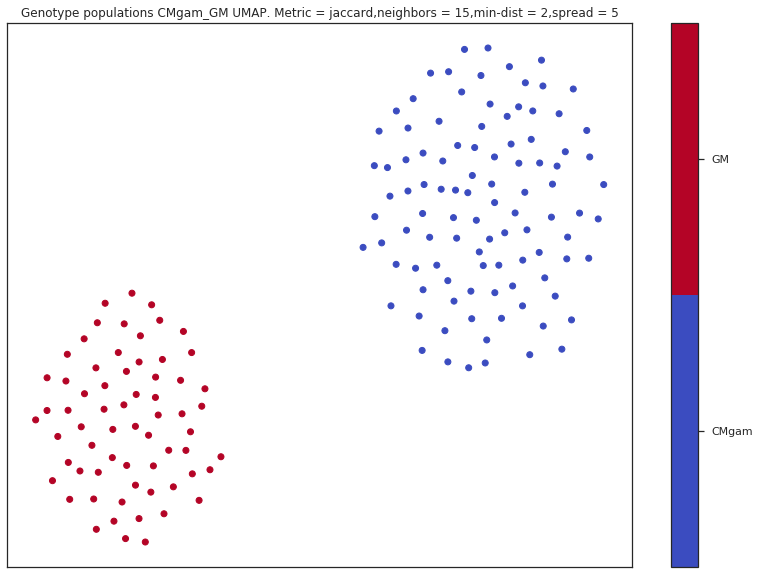

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CMgam_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 280)
2.) Filtering Rare Allels
Number of SNPs removed =  3442081
Retaining =  209639
3.) Performing LD Pruning
iteration 1 retaining 117268 removing 92371 variants
iteration 2 retaining 115052 removing 2216 variants
iteration 3 retaining 114800 removing 252 variants
Retained Haplotype Matrix =  (114800, 280)
Retained Positions Matrix =  (114800,)
Unique Labels:  [0 1]
CMgam : 100, _GNgam : 40


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


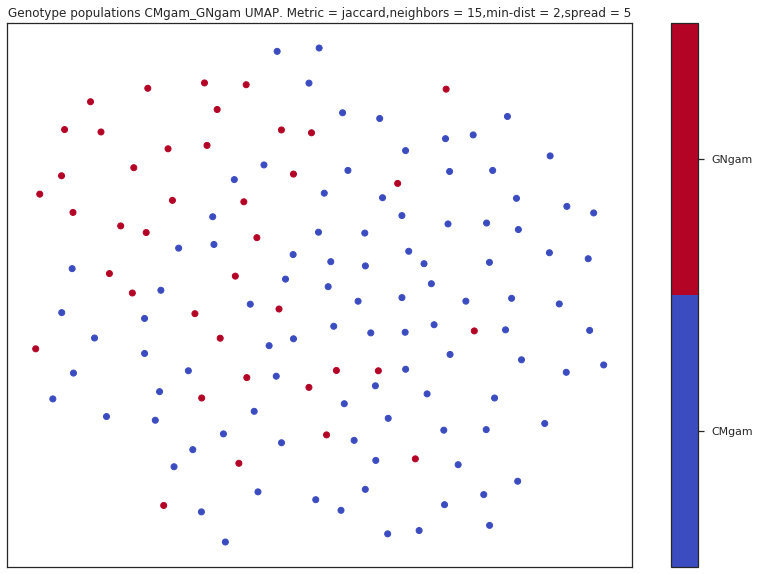

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CMgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 382)
2.) Filtering Rare Allels
Number of SNPs removed =  3449090
Retaining =  202630
3.) Performing LD Pruning
iteration 1 retaining 116249 removing 86381 variants
iteration 2 retaining 115384 removing 865 variants
iteration 3 retaining 115326 removing 58 variants
Retained Haplotype Matrix =  (115326, 382)
Retained Positions Matrix =  (115326,)
Unique Labels:  [0 1]
CMgam : 100, _GW : 91


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


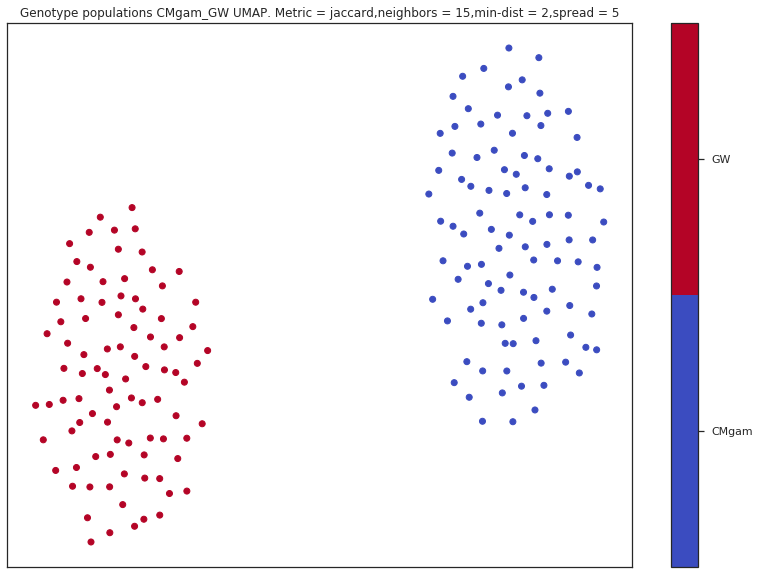

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CMgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 296)
2.) Filtering Rare Allels
Number of SNPs removed =  3446934
Retaining =  204786
3.) Performing LD Pruning
iteration 1 retaining 59561 removing 145225 variants
iteration 2 retaining 49698 removing 9863 variants
iteration 3 retaining 48208 removing 1490 variants
Retained Haplotype Matrix =  (48208, 296)
Retained Positions Matrix =  (48208,)
Unique Labels:  [0 1]
CMgam : 100, _KE : 48


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


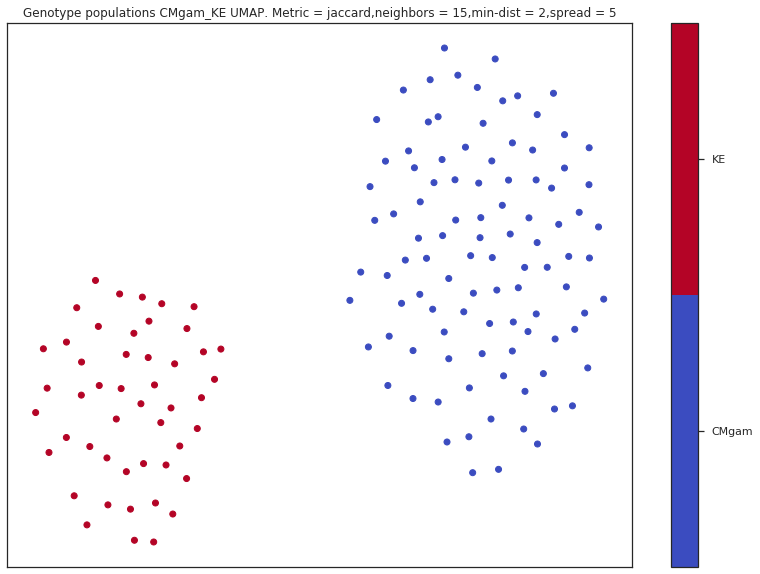

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


CMgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 424)
2.) Filtering Rare Allels
Number of SNPs removed =  3448730
Retaining =  202990
3.) Performing LD Pruning
iteration 1 retaining 115320 removing 87670 variants
iteration 2 retaining 114177 removing 1143 variants
iteration 3 retaining 114098 removing 79 variants
Retained Haplotype Matrix =  (114098, 424)
Retained Positions Matrix =  (114098,)
Unique Labels:  [0 1]
CMgam : 100, _UGgam : 112


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


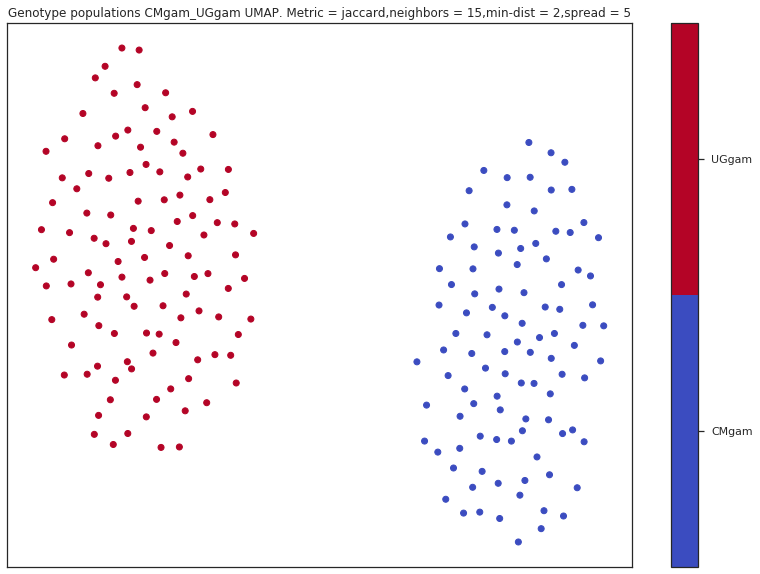

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GAgam_GHcol
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 248)
2.) Filtering Rare Allels
Number of SNPs removed =  3426812
Retaining =  224908
3.) Performing LD Pruning
iteration 1 retaining 43091 removing 181817 variants
iteration 2 retaining 30156 removing 12935 variants
iteration 3 retaining 28847 removing 1309 variants
Retained Haplotype Matrix =  (28847, 248)
Retained Positions Matrix =  (28847,)
Unique Labels:  [0 1]
GAgam : 69, _GHcol : 55


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


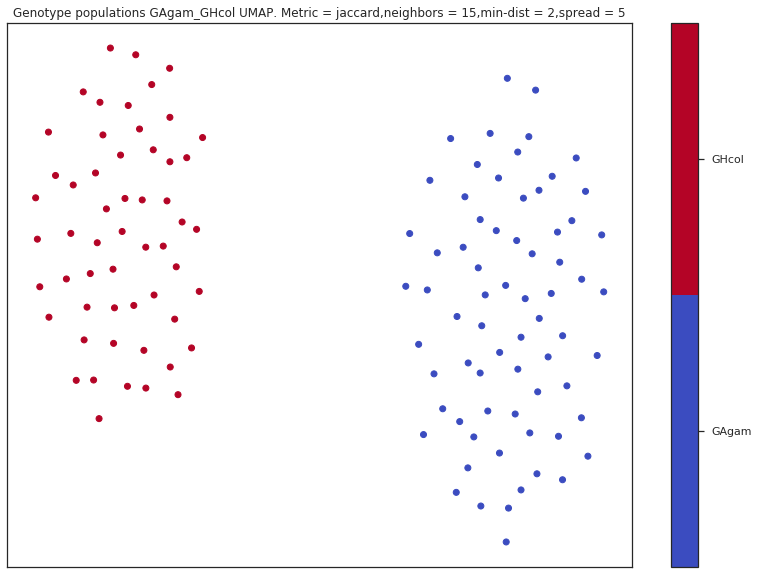

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GAgam_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 268)
2.) Filtering Rare Allels
Number of SNPs removed =  3423297
Retaining =  228423
3.) Performing LD Pruning
iteration 1 retaining 41735 removing 186688 variants
iteration 2 retaining 26944 removing 14791 variants
iteration 3 retaining 25672 removing 1272 variants
Retained Haplotype Matrix =  (25672, 268)
Retained Positions Matrix =  (25672,)
Unique Labels:  [0 1]
GAgam : 69, _GM : 65


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


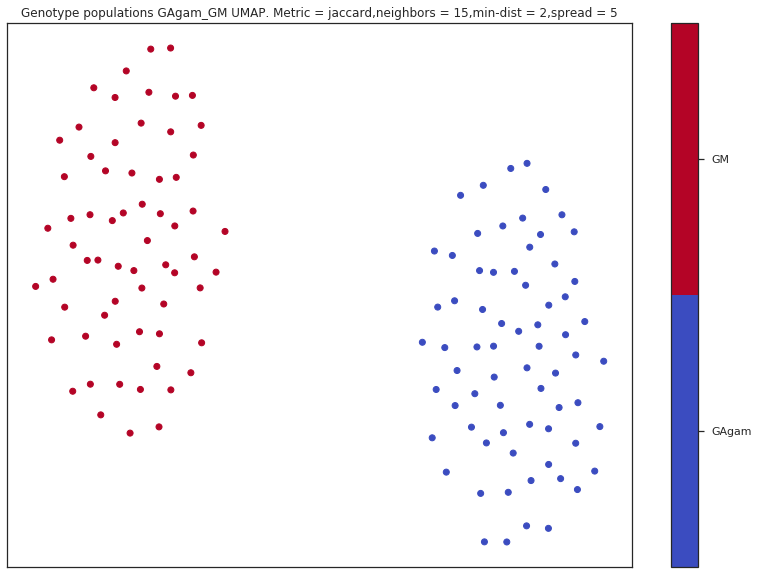

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GAgam_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 218)
2.) Filtering Rare Allels
Number of SNPs removed =  3422444
Retaining =  229276
3.) Performing LD Pruning
iteration 1 retaining 37757 removing 191519 variants
iteration 2 retaining 23465 removing 14292 variants
iteration 3 retaining 21907 removing 1558 variants
Retained Haplotype Matrix =  (21907, 218)
Retained Positions Matrix =  (21907,)
Unique Labels:  [0 1]
GAgam : 69, _GNgam : 40


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


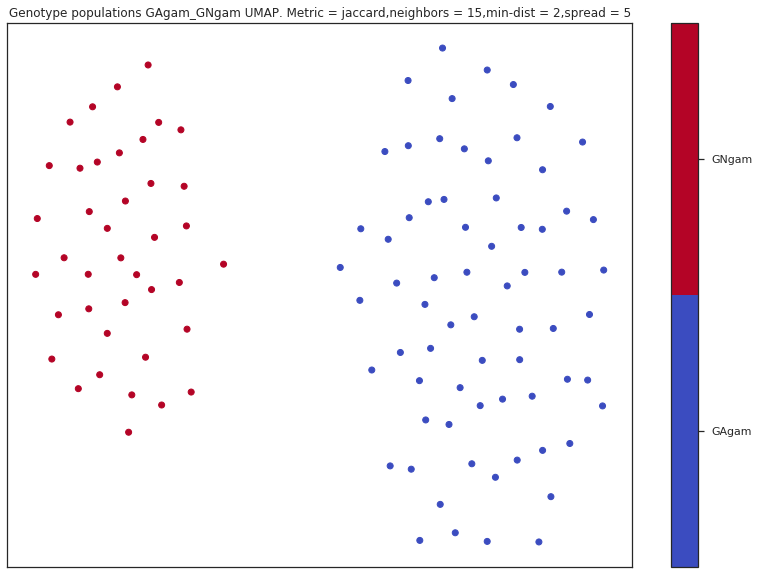

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GAgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 320)
2.) Filtering Rare Allels
Number of SNPs removed =  3422927
Retaining =  228793
3.) Performing LD Pruning
iteration 1 retaining 67706 removing 161087 variants
iteration 2 retaining 59443 removing 8263 variants
iteration 3 retaining 58792 removing 651 variants
Retained Haplotype Matrix =  (58792, 320)
Retained Positions Matrix =  (58792,)
Unique Labels:  [0 1]
GAgam : 69, _GW : 91


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


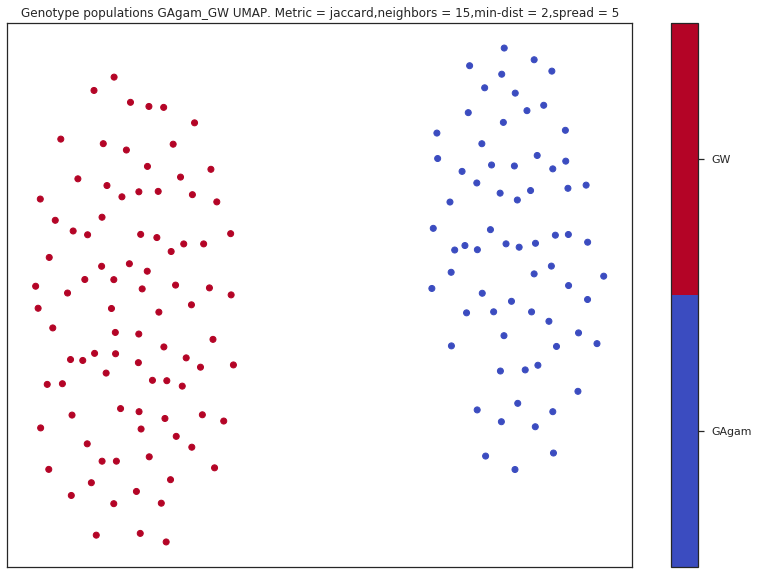

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GAgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 234)
2.) Filtering Rare Allels
Number of SNPs removed =  3425465
Retaining =  226255
3.) Performing LD Pruning
iteration 1 retaining 12027 removing 214228 variants
iteration 2 retaining 2696 removing 9331 variants
iteration 3 retaining 2122 removing 574 variants
Retained Haplotype Matrix =  (2122, 234)
Retained Positions Matrix =  (2122,)
Unique Labels:  [0 1]
GAgam : 69, _KE : 48


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


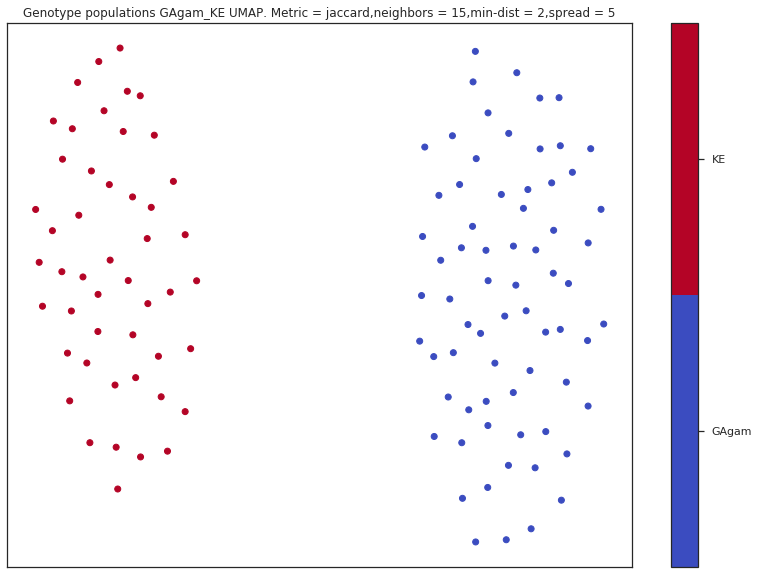

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GAgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 362)
2.) Filtering Rare Allels
Number of SNPs removed =  3434675
Retaining =  217045
3.) Performing LD Pruning
iteration 1 retaining 71994 removing 145051 variants
iteration 2 retaining 65130 removing 6864 variants
iteration 3 retaining 64608 removing 522 variants
Retained Haplotype Matrix =  (64608, 362)
Retained Positions Matrix =  (64608,)
Unique Labels:  [0 1]
GAgam : 69, _UGgam : 112


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


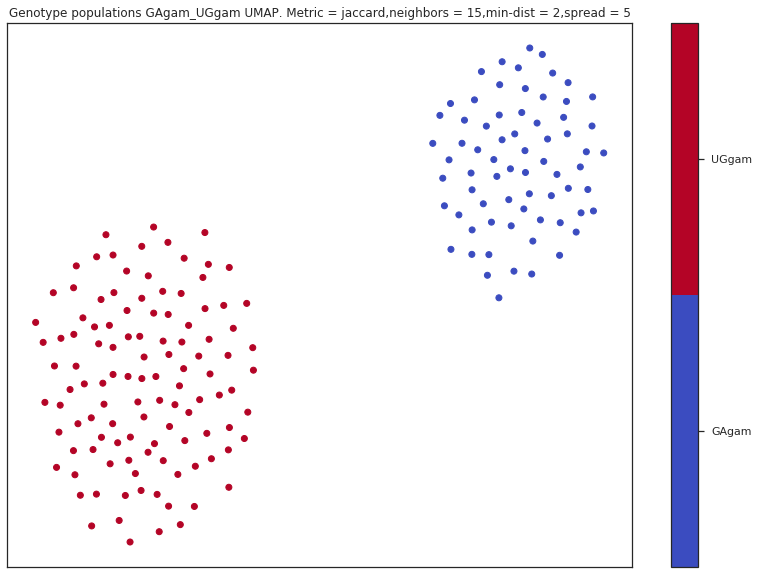

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GHcol_GM
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 240)
2.) Filtering Rare Allels
Number of SNPs removed =  3429424
Retaining =  222296
3.) Performing LD Pruning
iteration 1 retaining 81446 removing 140850 variants
iteration 2 retaining 73686 removing 7760 variants
iteration 3 retaining 72816 removing 870 variants
Retained Haplotype Matrix =  (72816, 240)
Retained Positions Matrix =  (72816,)
Unique Labels:  [0 1]
GHcol : 55, _GM : 65


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


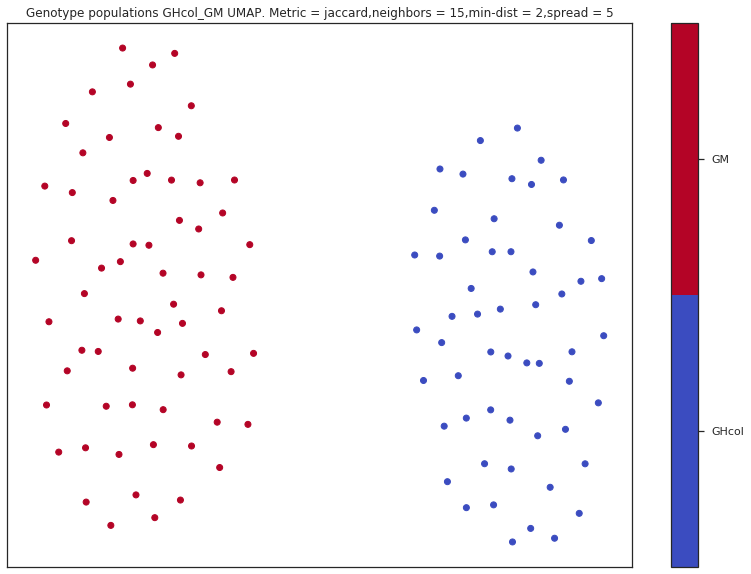

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GHcol_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 190)
2.) Filtering Rare Allels
Number of SNPs removed =  3444235
Retaining =  207485
3.) Performing LD Pruning
iteration 1 retaining 95249 removing 112236 variants
iteration 2 retaining 90099 removing 5150 variants
iteration 3 retaining 89347 removing 752 variants
Retained Haplotype Matrix =  (89347, 190)
Retained Positions Matrix =  (89347,)
Unique Labels:  [0 1]
GHcol : 55, _GNgam : 40


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


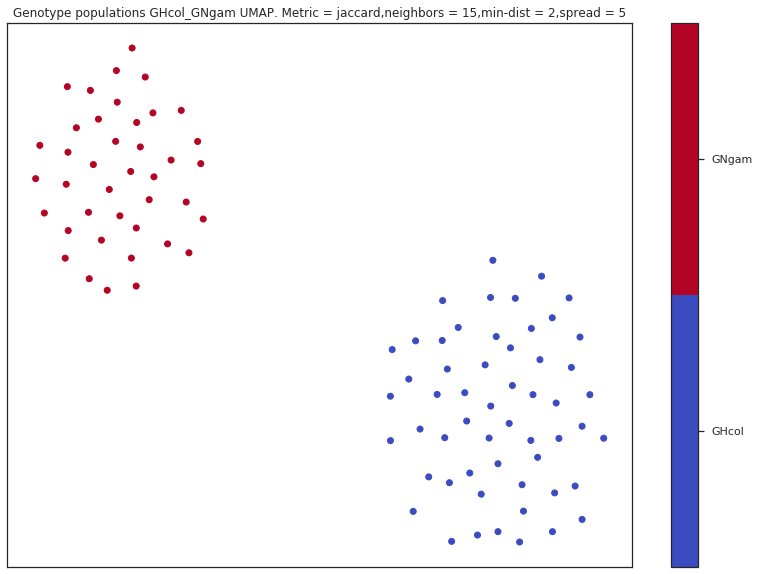

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GHcol_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 292)
2.) Filtering Rare Allels
Number of SNPs removed =  3439904
Retaining =  211816
3.) Performing LD Pruning
iteration 1 retaining 101513 removing 110303 variants
iteration 2 retaining 100421 removing 1092 variants
iteration 3 retaining 100367 removing 54 variants
Retained Haplotype Matrix =  (100367, 292)
Retained Positions Matrix =  (100367,)
Unique Labels:  [0 1]
GHcol : 55, _GW : 91


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


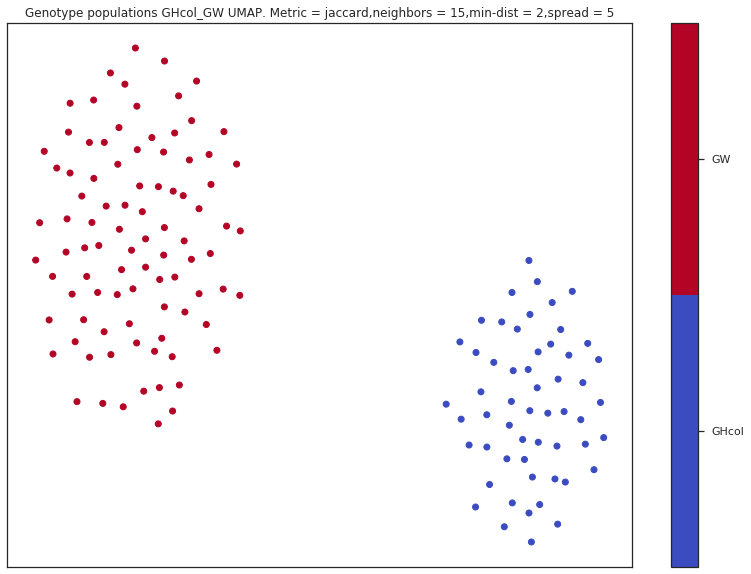

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GHcol_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 206)
2.) Filtering Rare Allels
Number of SNPs removed =  3459002
Retaining =  192718
3.) Performing LD Pruning
iteration 1 retaining 23386 removing 169332 variants
iteration 2 retaining 10462 removing 12924 variants
iteration 3 retaining 6764 removing 3698 variants
Retained Haplotype Matrix =  (6764, 206)
Retained Positions Matrix =  (6764,)
Unique Labels:  [0 1]
GHcol : 55, _KE : 48


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


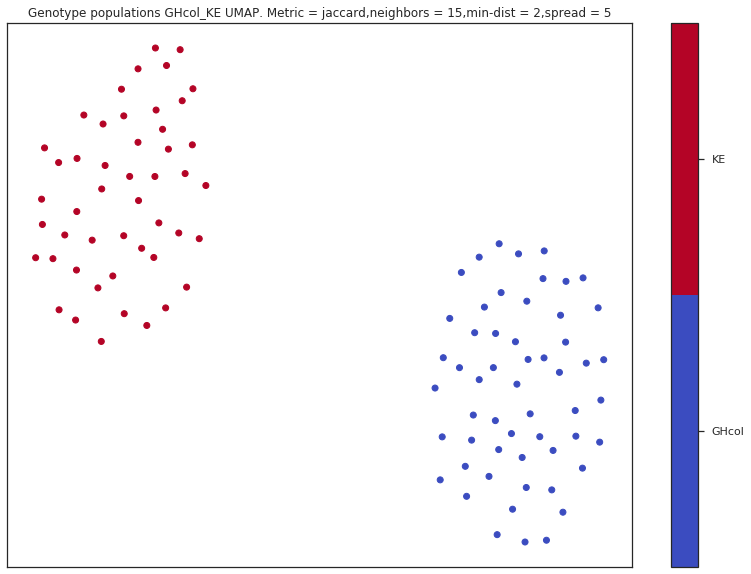

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GHcol_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 334)
2.) Filtering Rare Allels
Number of SNPs removed =  3443040
Retaining =  208680
3.) Performing LD Pruning
iteration 1 retaining 109297 removing 99383 variants
iteration 2 retaining 107110 removing 2187 variants
iteration 3 retaining 106948 removing 162 variants
Retained Haplotype Matrix =  (106948, 334)
Retained Positions Matrix =  (106948,)
Unique Labels:  [0 1]
GHcol : 55, _UGgam : 112


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


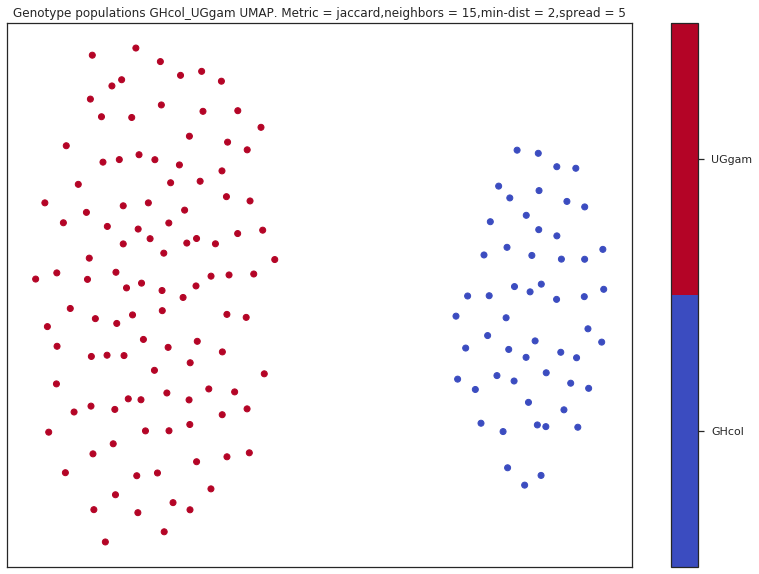

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GM_GNgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 210)
2.) Filtering Rare Allels
Number of SNPs removed =  3437077
Retaining =  214643
3.) Performing LD Pruning
iteration 1 retaining 82354 removing 132289 variants
iteration 2 retaining 72414 removing 9940 variants
iteration 3 retaining 70905 removing 1509 variants
Retained Haplotype Matrix =  (70905, 210)
Retained Positions Matrix =  (70905,)
Unique Labels:  [0 1]
GM_GN : 65, gam : 40


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


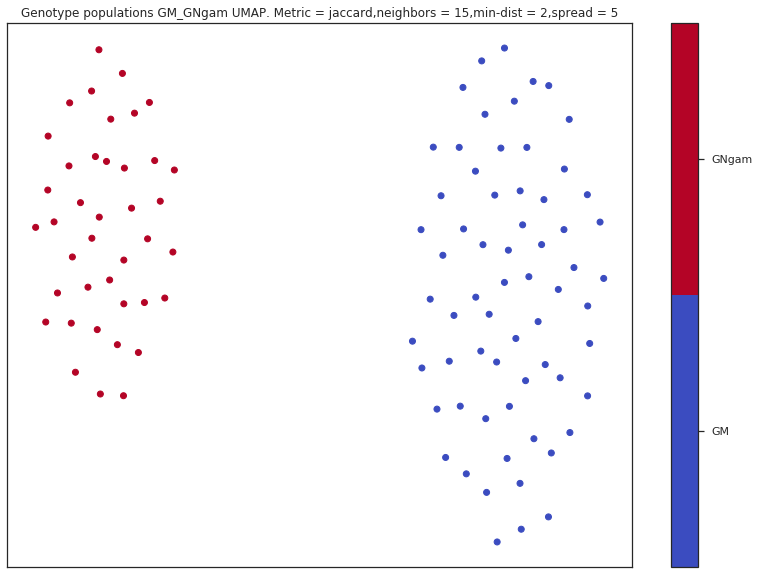

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GM_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 312)
2.) Filtering Rare Allels
Number of SNPs removed =  3434414
Retaining =  217306
3.) Performing LD Pruning
iteration 1 retaining 88277 removing 129029 variants
iteration 2 retaining 85299 removing 2978 variants
iteration 3 retaining 85053 removing 246 variants
Retained Haplotype Matrix =  (85053, 312)
Retained Positions Matrix =  (85053,)
Unique Labels:  [0 1]
GM_GW : 65,  : 91


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


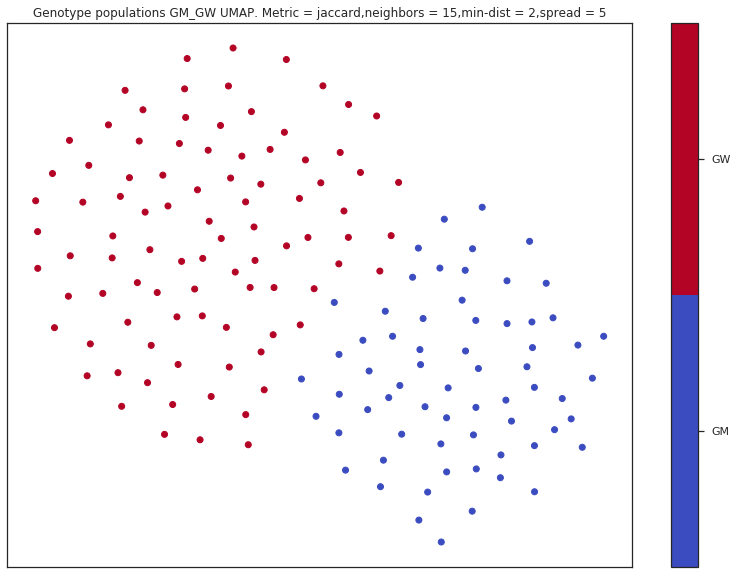

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GM_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 226)
2.) Filtering Rare Allels
Number of SNPs removed =  3447889
Retaining =  203831
3.) Performing LD Pruning
iteration 1 retaining 21101 removing 182730 variants
iteration 2 retaining 7881 removing 13220 variants
iteration 3 retaining 5650 removing 2231 variants
Retained Haplotype Matrix =  (5650, 226)
Retained Positions Matrix =  (5650,)
Unique Labels:  [0 1]
GM_KE : 65,  : 48


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


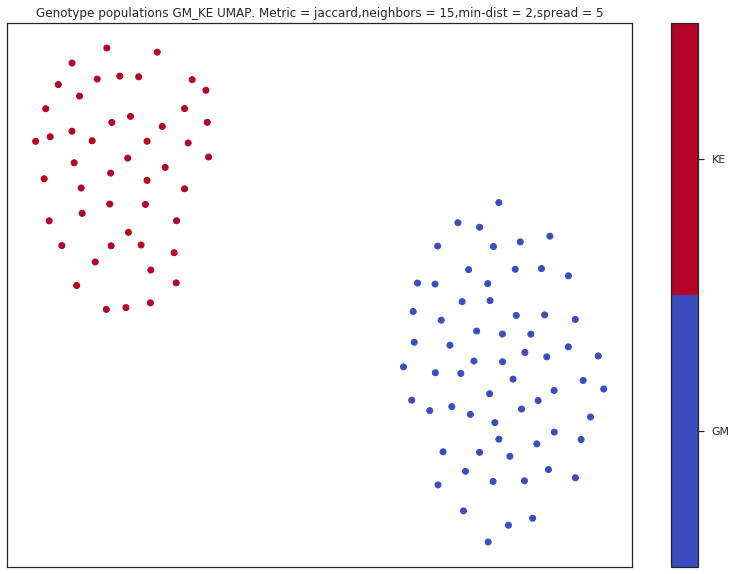

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GM_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 354)
2.) Filtering Rare Allels
Number of SNPs removed =  3440259
Retaining =  211461
3.) Performing LD Pruning
iteration 1 retaining 105742 removing 105719 variants
iteration 2 retaining 102591 removing 3151 variants
iteration 3 retaining 102301 removing 290 variants
Retained Haplotype Matrix =  (102301, 354)
Retained Positions Matrix =  (102301,)
Unique Labels:  [0 1]
GM_UG : 65, gam : 112


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


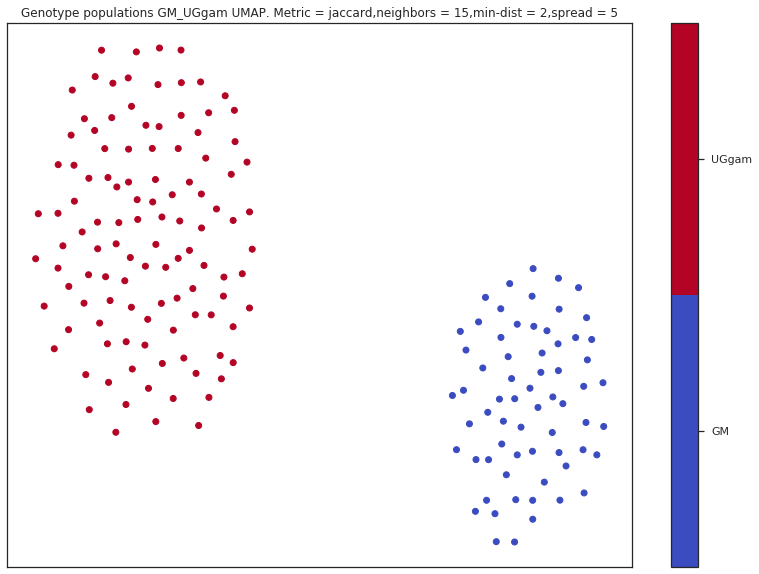

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GNgam_GW
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 262)
2.) Filtering Rare Allels
Number of SNPs removed =  3446965
Retaining =  204755
3.) Performing LD Pruning
iteration 1 retaining 107103 removing 97652 variants
iteration 2 retaining 105811 removing 1292 variants
iteration 3 retaining 105699 removing 112 variants
Retained Haplotype Matrix =  (105699, 262)
Retained Positions Matrix =  (105699,)
Unique Labels:  [0 1]
GNgam : 40, _GW : 91


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


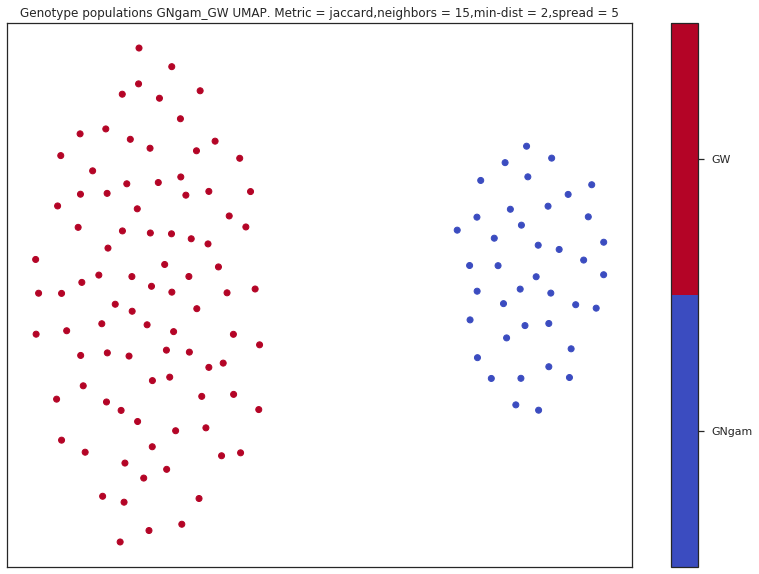

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GNgam_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 176)
2.) Filtering Rare Allels
Number of SNPs removed =  3468350
Retaining =  183370
3.) Performing LD Pruning
iteration 1 retaining 21434 removing 161936 variants
iteration 2 retaining 6513 removing 14921 variants
iteration 3 retaining 2712 removing 3801 variants
Retained Haplotype Matrix =  (2712, 176)
Retained Positions Matrix =  (2712,)
Unique Labels:  [0 1]
GNgam : 40, _KE : 48


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


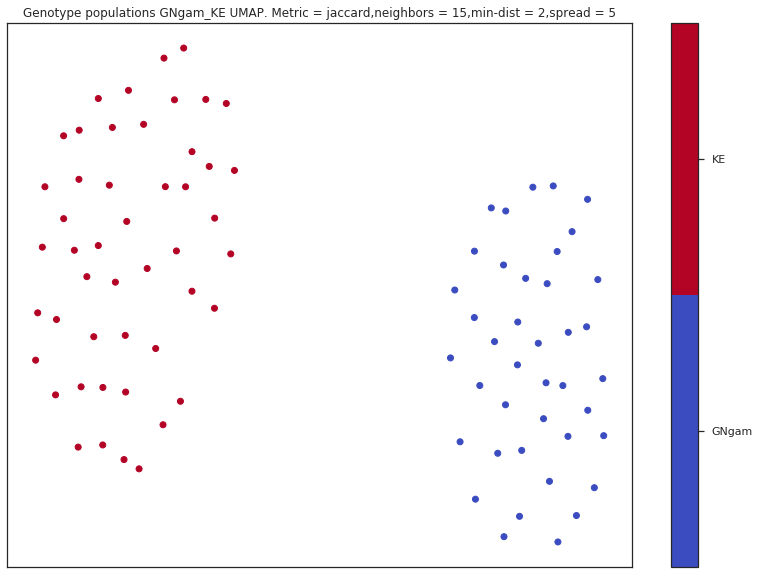

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GNgam_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 304)
2.) Filtering Rare Allels
Number of SNPs removed =  3446863
Retaining =  204857
3.) Performing LD Pruning
iteration 1 retaining 109264 removing 95593 variants
iteration 2 retaining 107323 removing 1941 variants
iteration 3 retaining 107170 removing 153 variants
Retained Haplotype Matrix =  (107170, 304)
Retained Positions Matrix =  (107170,)
Unique Labels:  [0 1]
GNgam : 40, _UGgam : 112


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


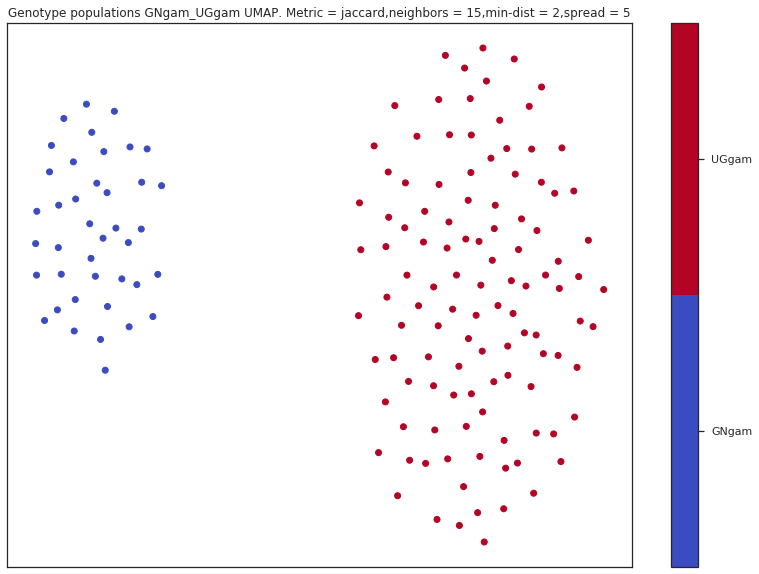

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GW_KE
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 278)
2.) Filtering Rare Allels
Number of SNPs removed =  3442586
Retaining =  209134
3.) Performing LD Pruning
iteration 1 retaining 48477 removing 160657 variants
iteration 2 retaining 39078 removing 9399 variants
iteration 3 retaining 37633 removing 1445 variants
Retained Haplotype Matrix =  (37633, 278)
Retained Positions Matrix =  (37633,)
Unique Labels:  [0 1]
GW_KE : 91,  : 48


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


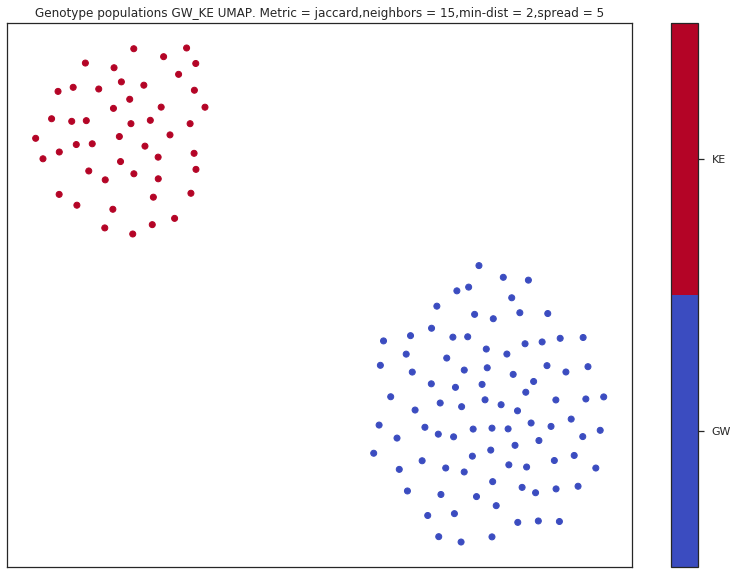

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


GW_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 406)
2.) Filtering Rare Allels
Number of SNPs removed =  3445870
Retaining =  205850
3.) Performing LD Pruning
iteration 1 retaining 113771 removing 92079 variants
iteration 2 retaining 112730 removing 1041 variants
iteration 3 retaining 112664 removing 66 variants
Retained Haplotype Matrix =  (112664, 406)
Retained Positions Matrix =  (112664,)
Unique Labels:  [0 1]
GW_UG : 91, gam : 112


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


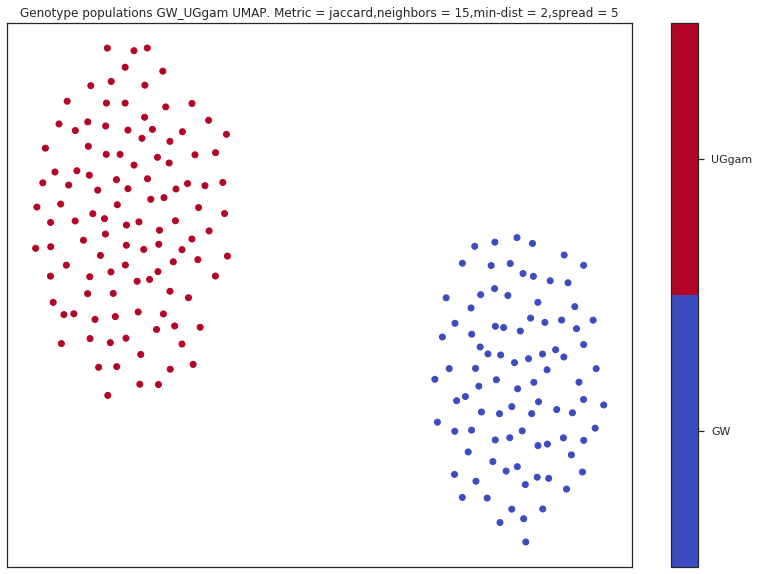

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


KE_UGgam
4836295
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 320)
2.) Filtering Rare Allels
Number of SNPs removed =  3440839
Retaining =  210881
3.) Performing LD Pruning
iteration 1 retaining 58102 removing 152779 variants
iteration 2 retaining 49297 removing 8805 variants
iteration 3 retaining 48242 removing 1055 variants
Retained Haplotype Matrix =  (48242, 320)
Retained Positions Matrix =  (48242,)
Unique Labels:  [0 1]
KE_UG : 48, gam : 112


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


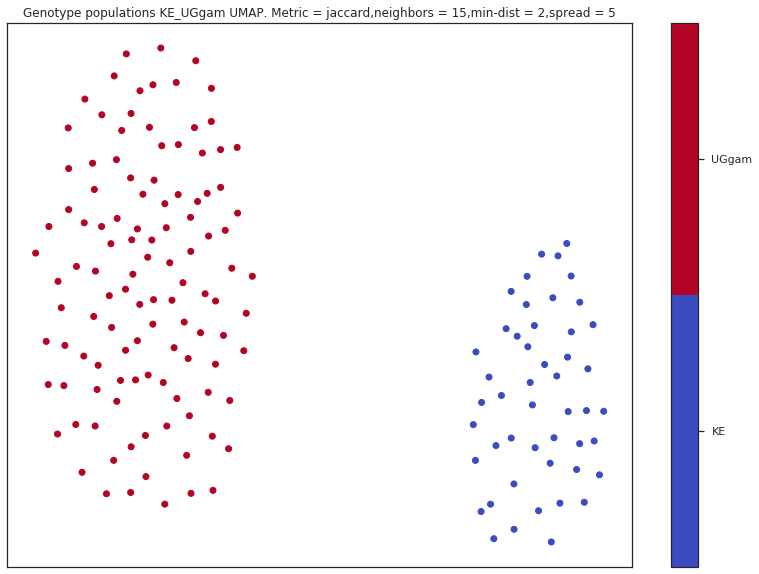

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


    Count Population_pair  Samples  Initial_SNP  MAF_filter_SNP  Filtered_SNP  \
0       1     BFcol_BFgam    167.0      4836295          202928        117141   
1       2     BFcol_AOcol    153.0      4836295          196218         61911   
2       3     BFcol_CIcol    146.0      4836295          206852         91634   
3       4     BFcol_CMgam    175.0      4836295          200832        118031   
4       5     BFcol_GAgam    144.0      4836295          218226         52077   
..    ...             ...      ...          ...             ...           ...   
61     62        GNgam_KE     88.0      4836295          183370          2712   
62     63     GNgam_UGgam    152.0      4836295          204857        107170   
63     64           GW_KE    139.0      4836295          209134         37633   
64     65        GW_UGgam    203.0      4836295          205850        112664   
65     66        KE_UGgam    160.0      4836295          210881         48242   

    LR_accuracy  LR_f1score

In [321]:
# IMPROVISED ANALYSIS SCRIPT
# UPDATES ADDED - 1) Saves SNP positions 2) Added Patterson Scaler 3) Added PCA+LR classification stats

'''
Pairwise analysis of all the 12 populations.
Total 66 combinations/analysis
Analysis includes:
1. Selecting a pair
2. Filtering the SNPs jointly
    - Mega Base Pair Selection
    - Rare Allele Filtering with MAF >= 5%
    - LD Pruning
    Save Filtering stats for all the pairs
3. Convert Haplotype to Genotype
4. Patterson Scaling
5. Train-Test Split
6. Classifying using Logistic Regression and LDA
7. Generating UMAP visualization
8. Dimensionality Reduction: Obtaining 20 UMAP components 
9. Training LR classifier on UMAP components
10. Dimensionality Reduction: Obtaining 50 PCA components
11. Training LR classifier on PCA components
12. Storing all the stats and evaluation scores into a dataframe
'''
# Storage Path
home = home = os.path.expanduser('~')
directory = os.path.join(home,'Imp_Research','Repository','Pairwise_Analysis')

# List of keys
keys = list(H.keys())
count = 0
pnames = []
psamples = []
pmaf = []
psnps_init = []
psnps_filt = []
accuracy_lr = []
f1score_lr = []
kappa_lr = []
accuracy_ulr = []
f1score_ulr = []
kappa_ulr = []
accuracy_plr = []
f1score_plr = []
kappa_plr = []
snp_pos = {} 

for i in range(11):
    for j in range(i+1,12):
        count+=1
        pair_pos = POS_all[keys[i]]
        # 1. Pair Selection. Combining the populations. 
        pop1 = H[keys[i]]
        pop2 = H[keys[j]]
        pair_h = np.append(pop1,pop2,1)
        pname = f'{keys[i][:-3]}_{keys[j][:-3]}'
        pnames.append(pname)
        psnps_init.append(pair_h.shape[0])
        psamples.append(pair_h.shape[1]/2)
        print(f'{pname}\n{psnp_init}')
        
        # 2. Filtering (Using FilterSNP class) Taking window size 250 is quicker.
        fsnp = FilterSNP(pair_h,pair_pos)
        pair_h, pair_pos = fsnp.all_filters(LD_window_size = 250,LD_overlap_step = 100,LD_iter = 3)
        psnps_filt.append(pair_h.shape[0])
        pmaf.append(fsnp._retained_maf)
        snp_pos[pname] = pair_pos
    
        # 3. Converting Haplo to Geno
        X = pair_h.T
        Xg = to_genotype(X)       # Func to obtain Genotype
        pshape_g = Xg.shape
        
        # 4. Patterson Scaling
#         Xg = allel.PattersonScaler().fit_transform(Xg)
        
        # 5. Train-Test Split
        Y = [0]*int(len(pop1[0])/2)
        Y.extend([1]*int(len(pop2[0])/2))
        Y = np.array(Y)
        print("Unique Labels: ",np.unique(Y))
        print(f"{pname[:5]} : {len(np.where(Y==0)[0])}, {pname[5:]} : {len(np.where(Y==1)[0])}")
        x_train,x_test,y_train,y_test = train_test_split(Xg,Y,test_size = 0.2,stratify = Y,random_state= 22)
        
        # 6. LR Classifier
        lr = LogisticRegression(n_jobs = -1)
        lr.fit(x_train,y_train)
        acc_lr, f1w_lr, kap_lr = evaluate_classifier(y_test,lr.predict(x_test))
        accuracy_lr.append(acc_lr)
        f1score_lr.append(f1w_lr)
        kappa_lr.append(kap_lr)
        
        # 7. Generate UMAP visualization
        UMAP_g = umap.UMAP(n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit_transform(Xg)
        sns.set(style='white')
        fig, ax = plt.subplots(1, figsize=(14, 10))
        plt.scatter(UMAP_g[:, 0],UMAP_g[:, 1],c=Y,cmap='coolwarm')
        plt.setp(ax, xticks=[], yticks=[])
        cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
        cbar.set_ticks(np.arange(2))
        cbar.set_ticklabels(pname.split('_'))
        plt.title(f'Genotype populations {pname} UMAP. Metric = jaccard,neighbors = 15,min-dist = 2,spread = 5');
#         figname = f'{count}_{pname}_umap.png'
#         path = os.path.join(directory,'pairwise_plots','pairwise_jaccard_patterson_plots',figname)
#         plt.savefig(path,dpi=100)
        plt.show() 
        # NOTE !!! Calling plt.show() before saving clears the figure so empty graph will be saved
        
        # 8. Dimensionality Reduction: Obtaining 20 umap components
        UMAP_g = umap.UMAP(n_components = 20,n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit(x_train)
        x_utrain = UMAP_g.embedding_
        x_utest = UMAP_g.transform(x_test)
        
        # 9. Training LR on UMAP components
        ulr = LogisticRegression(n_jobs = -1)
        ulr.fit(x_utrain,y_train)
        acc_ulr, f1w_ulr, kap_ulr = evaluate_classifier(y_test,ulr.predict(x_utest))
        accuracy_ulr.append(acc_ulr)
        f1score_ulr.append(f1w_ulr)
        kappa_ulr.append(kap_ulr)
        
        
        # 10. Dimensionality Reduction: Obtaining 50 PCA components
        pca = PCA(n_components = 50)
        pca.fit(x_train)
        x_ptrain = pca.transform(x_train)
        x_ptest = pca.transform(x_test)
        
        # 11. Training LR on UMAP components
        plr = LogisticRegression(n_jobs = -1)
        plr.fit(x_ptrain,y_train)
        acc_plr, f1w_plr, kap_plr = evaluate_classifier(y_test,plr.predict(x_ptest))
        accuracy_plr.append(acc_plr)
        f1score_plr.append(f1w_plr)
        kappa_plr.append(kap_plr)
    
pairwise_analysisJ = pd.DataFrame()
pairwise_analysisJ['Count'] = range(1,len(pnames)+1)
pairwise_analysisJ['Population_pair'] = pnames
pairwise_analysisJ['Samples'] = psamples
pairwise_analysisJ['Initial_SNP'] = psnps_init
pairwise_analysisJ['MAF_filter_SNP'] = pmaf
pairwise_analysisJ['Filtered_SNP'] = psnps_filt
pairwise_analysisJ['LR_accuracy'] = accuracy_lr
pairwise_analysisJ['LR_f1score'] = f1score_lr
pairwise_analysisJ['LR_kappa'] = kappa_lr
pairwise_analysisJ['UMAP_LR_accuracy'] = accuracy_ulr
pairwise_analysisJ['UMAP_LR_f1score'] = f1score_ulr
pairwise_analysisJ['UMAP_LR_kappa'] = kappa_ulr
pairwise_analysisJ['PCA_LR_accuracy'] = accuracy_plr
pairwise_analysisJ['PCA_LR_f1score'] = f1score_plr
pairwise_analysisJ['PCA_LR_kappa'] = kappa_plr

# OLD ERROR LOG - Ignore!
# Errored at i = 5, j = 8, count = 48, pname = 'GAgam_GNgam'
# status: UMAP saved but no data. Also 20 components exceeded some samples.
# because I messed up (-_-) and took test size 80% (*_*)


print(pairwise_analysisJ)
path = os.path.join(directory,'Pairwise_Analysis_Stats_Jaccard_UMAP_PCA.csv')
pairwise_analysisJ.to_csv(path,index= False)


# RUN AGAIN WITHOUT PATTERSON PLEASEEEEEEE. Patterson scaling messes up UMAP functioning.
# DONE ^^^

In [320]:
# Saving SNP Positions of all the pairs as a pickle file
import pickle as pkl

path = os.path.join(directory,'POS_Pairwise_Analysis_Jaccard_UMAP_PCA.csv')
with open(path,'wb') as f:
    pkl.dump(snp_pos,f)

In [135]:
pairwise_analysisJ.head(50)

# LD_window = 500, overlap = 150 -> SNP = 116947
# LD_window = 250, overlap = 100 -> SNP = 117141

Count Population_pair  Samples  Initial_SNP  MAF_filter_SNP  Filtered_SNP  \
0       1     BFcol_BFgam    167.0      4836295          202928        116947   
1       2     BFcol_AOcol    153.0      4836295          196218         61477   
2       3     BFcol_CIcol    146.0      4836295          206852         91924   
3       4     BFcol_CMgam    175.0      4836295          200832        117855   
4       5     BFcol_GAgam    144.0      4836295          218226         52373   
5       6     BFcol_GHcol    130.0      4836295          209195         99782   
6       7        BFcol_GM    140.0      4836295          213948         95080   
7       8     BFcol_GNgam    115.0      4836295          200373        111014   
8       9        BFcol_GW    166.0      4836295          206882        111254   
9      10        BFcol_KE    123.0      4836295          192085         21719   
10     11     BFcol_UGgam    187.0      4836295          205039        114456   
11     12     BFgam_AOcol    170.0      4836295          207088         69339   
12     13     BFgam_CIcol    163.0      4836295          204334        102654   
13     14     BFgam_CMgam    192.0      4836295          201889        113461   
14     15     BFgam_GAgam    161.0      4836295          215988         59156   
15     16     BFgam_GHcol    147.0      4836295          207173        108392   
16     17        BFgam_GM    157.0      4836295          210501         99979   
17     18     BFgam_GNgam    132.0      4836295          203447        105816   
18     19        BFgam_GW    183.0      4836295          204333        113954   
19     20        BFgam_KE    140.0      4836295          205403         37312   
20     21     BFgam_UGgam    204.0      4836295          204547        113845   
21     22     AOcol_CIcol    149.0      4836295          207682         46424   
22     23     AOcol_CMgam    178.0      4836295          205542         74067   
23     24     AOcol_GAgam    147.0      4836295          227616         19320   
24     25     AOcol_GHcol    133.0      4836295          199242         41458   
25     26        AOcol_GM    143.0      4836295          206985         37741   
26     27     AOcol_GNgam    118.0      4836295          201758         34738   
27     28        AOcol_GW    169.0      4836295          210052         66857   
28     29        AOcol_KE    126.0      4836295          208538          4681   
29     30     AOcol_UGgam    190.0      4836295          210194         74624   
30     31     CIcol_CMgam    171.0      4836295          201711        105937   
31     32     CIcol_GAgam    140.0      4836295          232069         35845   
32     33     CIcol_GHcol    126.0      4836295          214330         68829   
33     34        CIcol_GM    136.0      4836295          216401         72688   
34     35     CIcol_GNgam    111.0      4836295          204304         81277   
35     36        CIcol_GW    162.0      4836295          208239         96376   
36     37        CIcol_KE    119.0      4836295          207263          9296   
37     38     CIcol_UGgam    183.0      4836295          205603        103720   
38     39     CMgam_GAgam    169.0      4836295          222474         64916   
39     40     CMgam_GHcol    155.0      4836295          204446        111144   
40     41        CMgam_GM    165.0      4836295          207508        103963   
41     42     CMgam_GNgam    140.0      4836295          209639        114441   
42     43        CMgam_GW    191.0      4836295          202630        115315   
43     44        CMgam_KE    148.0      4836295          204786         44654   
44     45     CMgam_UGgam    212.0      4836295          202990        114190   
45     46     GAgam_GHcol    124.0      4836295          224908         29067   
46     47        GAgam_GM    134.0      4836295          228423         26819   
47     48     GAgam_GNgam    109.0      4836295          229276         22083   
48     49        GAgam_GW    160.0 

## JACCARD is BETTER !!! 😎

### BFgam vs CMgam with Patterson scaled data

In [137]:
H.keys()

dict_keys(['BFcol.3R', 'BFgam.3R', 'AOcol.3R', 'CIcol.3R', 'CMgam.3R', 'GAgam.3R', 'GHcol.3R', 'GM.3R', 'GNgam.3R', 'GW.3R', 'KE.3R', 'UGgam.3R'])

In [152]:
bfgam = H['BFgam.3R']
cmgam = H['CMgam.3R']
x_bfcm = np.append(bfgam,cmgam,1)
x_bfcm.shape

(4836295, 384)

In [153]:
fsnp = FilterSNP(x_bfcm,POS_all['BFgam.3R'])
x_bfcm, p_bfcm = fsnp.all_filters(LD_window_size = 500,LD_overlap_step = 150,LD_iter = 3)

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 384)
2.) Filtering Rare Allels
Number of SNPs removed =  3449831
Retaining =  201889
3.) Performing LD Pruning
iteration 1 retaining 114364 removing 87525 variants
iteration 2 retaining 113491 removing 873 variants
iteration 3 retaining 113461 removing 30 variants
Retained Haplotype Matrix =  (113461, 384)
Retained Positions Matrix =  (113461,)


In [154]:
x_bfcm = to_genotype(x_bfcm.T)
x_bfcm.shape

(192, 113461)

In [148]:
y_bfcm = []
y_bfcm.extend([0]*92)
y_bfcm.extend([1]*100)
y_bfcm = np.array(y_bfcm)

In [163]:
x_bfcm = allel.PattersonScaler().fit_transform(x_bfcm)

In [191]:
x_train,x_test,y_train,y_test = train_test_split(x_bfcm,y_bfcm,test_size=0.20,stratify=y_bfcm)

In [162]:
# Doesn't work. IDK Why ? Will figure out later!

# pscaler = allel.PattersonScaler().fit(x_train)
# x_train = pscaler.transform(x_train)
# x_test = pscaler.transform(x_test)

ValueError: operands could not be broadcast together with shapes (48,113461) (144,1) (48,113461) 

In [168]:
lr = LogisticRegression(n_jobs = -1)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
evaluate_classifier(y_test,y_pred)

# (Accuracy, F1Score, Kappa)

(0.9230769230769231, 0.9224635829286992, 0.845442536327609)

In [194]:
UMAP_g = umap.UMAP(n_components = 20,n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit(x_train)
x_train = UMAP_g.embedding_
x_test = UMAP_g.transform(x_test)

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


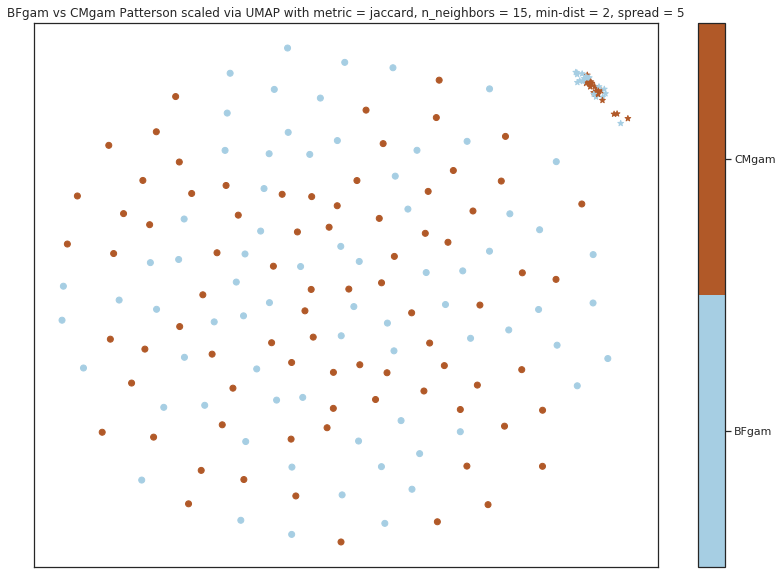

In [193]:
UMAP_g = umap.UMAP(n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit_transform(x_bfcm)


sns.set(style='white')
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      x_train[:, 0],
      x_train[:, 1],
      c=y_train,cmap='Paired')
plt.scatter(
      x_test[:, 0],
      x_test[:, 1],
      c=y_test,cmap='Paired',marker='*')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(['BFgam','CMgam'])
plt.title('BFgam vs CMgam Patterson scaled via UMAP with metric = jaccard, n_neighbors = 15, min-dist = 2, spread = 5');

In [170]:
lru = LogisticRegression(n_jobs = -1)
lru.fit(x_train,y_train)
y_pred = lru.predict(x_test)
evaluate_classifier(y_test,y_pred)

(0.5384615384615384, 0.46367521367521375, 0.05898123324396798)

#### BFgam vs GNgam Patterson scaled analysis

In [179]:
bfgam = H['BFgam.3R']
gngam = H['GNgam.3R']
x_bfgn = np.append(bfgam,gngam,1)
x_bfgn.shape

fsnp = FilterSNP(x_bfgn,POS_all['BFgam.3R'])
x_bfgn, p_bfcm = fsnp.all_filters(LD_window_size = 500,LD_overlap_step = 150,LD_iter = 3)

x_bfgn = to_genotype(x_bfgn.T)

y_bfgn = []
y_bfgn.extend([0]*92)
y_bfgn.extend([1]*40)
y_bfgn = np.array(y_bfgn)

x_bfgn = allel.PattersonScaler().fit_transform(x_bfgn)

x_train,x_test,y_train,y_test = train_test_split(x_bfgn,y_bfgn,test_size=0.20,stratify=y_bfgn)

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 264)
2.) Filtering Rare Allels
Number of SNPs removed =  3448273
Retaining =  203447
3.) Performing LD Pruning
iteration 1 retaining 107740 removing 95707 variants
iteration 2 retaining 105927 removing 1813 variants
iteration 3 retaining 105816 removing 111 variants
Retained Haplotype Matrix =  (105816, 264)
Retained Positions Matrix =  (105816,)


In [180]:
lr = LogisticRegression(n_jobs = -1)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
evaluate_classifier(y_test,y_pred)

(0.7407407407407407, 0.6600823045267489, 0.1674008810572687)

In [181]:
UMAP_g = umap.UMAP(n_components = 20,n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit(x_train)
x_train = UMAP_g.embedding_
x_test = UMAP_g.transform(x_test)

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/spectral.py:344: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


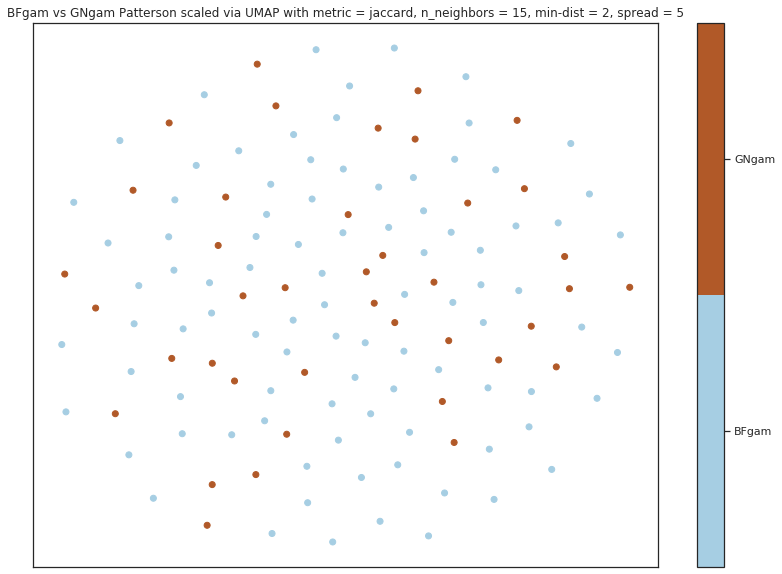

In [184]:
UMAP_g = umap.UMAP(n_components = 2,n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit_transform(x_bfgn)


sns.set(style='white')
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      UMAP_g[:, 0],
      UMAP_g[:, 1],
      c=y_bfgn,cmap='Paired')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(['BFgam','GNgam'])
plt.title('BFgam vs GNgam Patterson scaled via UMAP with metric = jaccard, n_neighbors = 15, min-dist = 2, spread = 5');

### Feature Importance Exploration

In [308]:
# EDITED/UPDATED iteratively so usage maybe different at some places
# Function to perform pre-processing and analysis on any two given pair
'''
Parameters : Population 1, Population 2 and SNP Positions
Returns: 1) Filtered data, Filtered SNP Positions, fitted LR object, UMAP fitted LR Object, PCA, PCA loadings
        or
        if just_train_test is True
        2) x_train, x_test, y_train, y_true for the given pair
'''

def pair_analysis(p1, p2, P, just_train_test = False, patterson = False):

    x = np.append(p1,p2,1)
    print("Shape of samples: ",x.shape)
    fsnp = FilterSNP(x ,P)
    x, P = fsnp.all_filters(LD_window_size = 250,LD_overlap_step = 150,LD_iter = 3)
    
    # to_genotype funtion defined above
    x = to_genotype(x.T)
    print("Shape of samples: ",x.shape)
    y = []
    y.extend([0]*int(len(p1[0])/2))
    y.extend([1]*int(len(p2[0])/2))
    y = np.array(y)
    print("Shape of labels: ",y.shape)
    
    # Scaling (a bit of cheating because there is no alternatie, AFAIK 😅)
    if patterson:
        x = allel.PattersonScaler().fit_transform(x)
    
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,stratify=y)
    
    if just_train_test:
        return x_tain,x_test, y_train,y_test
    
    lr = LogisticRegression(n_jobs = -1)
    lr.fit(x_train,y_train)
    y_pred = lr.predict(x_test)
    # Function defined above
    print(f"LR performance on SNPs: \n")
    evaluate_classifier(y_test,y_pred)
    acc, f1 ,kap = evaluate_classifier(y_test,y_pred)
    print("LR Accuracy: ",acc)
    
    UMAP_g = umap.UMAP(n_components = 20,n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit(x_train)
    x_train = UMAP_g.embedding_
    x_test = UMAP_g.transform(x_test)
    
    print(f"LR performance on UMAP components: \n")
    lru = LogisticRegression(n_jobs = -1)
    lru.fit(x_train,y_train)
    y_pred = lru.predict(x_test)
    acc, f1 ,kap = evaluate_classifier(y_test,y_pred)
    print("UMAP-LR Accuracy: ",acc)
    
    UMAP_g = umap.UMAP(n_components = 2,n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit_transform(x)
    
    pca = PCA(n_components = 160).fit(x)
    loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, 160 + 1)],
    index = P)

    
    """
    Loadings being calculated here is score matrix in Singular Value Decomposition.
    D = U * sv * L.T     or    D = U * S * V
    from this,
    SVD score matrix is -> U * sqrt(explained variance)
    U -> Left singular vector, user to class mapping
    SV -> Singular Values,     strength of class
    
    https://stats.stackexchange.com/questions/346692/how-does-eigenvalues-measure-variance-along-the-principal-components-in-pca
    """
    
    return x, lr, lru, UMAP_g, pca, loadings, P

In [224]:
lr, lru, umap, pca, loadings, pos = pair_analysis(H['BFcol.3R'],H['BFgam.3R'],POS_all['BFcol.3R'])

Shape of samples:  (4836295, 334)
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 334)
2.) Filtering Rare Allels
Number of SNPs removed =  3448792
Retaining =  202928
3.) Performing LD Pruning
iteration 1 retaining 118764 removing 84164 variants
iteration 2 retaining 117373 removing 1391 variants
iteration 3 retaining 117130 removing 243 variants
Retained Haplotype Matrix =  (117130, 334)
Retained Positions Matrix =  (117130,)
Shape of samples:  (167, 117130)
Shape of labels:  (167,)
LR performance on SNPs: 



/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


LR performance on UMAP components: 



/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


In [235]:
plt.style.use('seaborn')

In [302]:
# Edited the function pair_analysis to only obtain PCA 

pca160 = pair_analysis(H['BFcol.3R'],H['BFgam.3R'],POS_all['BFcol.3R'])

Shape of samples:  (4836295, 334)
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 334)
2.) Filtering Rare Allels
Number of SNPs removed =  3448792
Retaining =  202928
3.) Performing LD Pruning
iteration 1 retaining 118764 removing 84164 variants
iteration 2 retaining 117373 removing 1391 variants
iteration 3 retaining 117130 removing 243 variants
Retained Haplotype Matrix =  (117130, 334)
Retained Positions Matrix =  (117130,)
Shape of samples:  (167, 117130)
Shape of labels:  (167,)


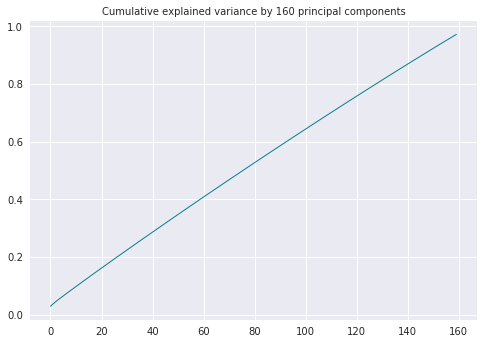

In [306]:
plt.plot(pca160.explained_variance_ratio_.cumsum(), lw=1, color='#087E8B')
plt.title('Cumulative explained variance by 160 principal components', size=10)
plt.show()

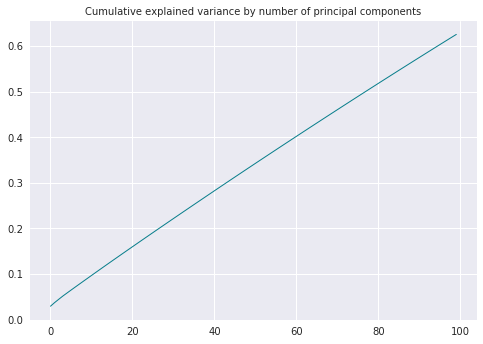

In [236]:
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=1, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=10)
plt.show()

In [250]:
loadings.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
46609  0.348945 -0.037285  0.013033 -0.002422 -0.013380  0.036689  0.062825   
48634 -1.308082 -0.057333 -0.134159  0.073471  0.061353 -0.086621  0.003485   
49078  0.300165  0.010268  0.001076  0.021137  0.055201 -0.020872 -0.030298   
49448 -0.379737 -0.073808  0.149828  0.053135 -0.090703  0.101538 -0.042306   
50174  0.420523  0.018726  0.040891  0.033453 -0.047848 -0.026575  0.021636   

            PC8       PC9      PC10  ...      PC91      PC92      PC93  \
46609 -0.015140 -0.040410 -0.041999  ... -0.022884  0.074897  0.051003   
48634 -0.055152 -0.130855 -0.039451  ...  0.074253  0.080805  0.145935   
49078  0.068852 -0.065039 -0.003823  ... -0.048509 -0.017436  0.100103   
49448  0.069179  0.025860  0.011952  ... -0.032737 -0.123344 -0.033712   
50174 -0.015278  0.043634  0.013024  ... -0.041342 -0.010968  0.051465   

           PC94      PC95      PC96      PC97      PC98      PC99     PC100  
46609  0.056375  0.036114 -0.120455 -0.065105 -0.062797  0.036365  0.003328  
48634 -0.046876  0.037815 -0.027769 -0.100013  0.008761  0.034449 -0.215814  
49078  0.047649 -0.085007 -0.068054  0.025541  0.060324 -0.047725 -0.003732  
49448  0.007799  0.014061 -0.189199 -0.008852 -0.047861  0.019486 -0.021829  
50174 -0.026935  0.152780  0.081053 -0.030274 -0.045984  0.025187  0.039810  

[5 rows x 100 columns]

In [255]:
pc1_loadings['CorrelationWithPC1'][:100]

# Look more into it for explaination!!??
# Loading exceeds 1

0     1.561858
1     1.323784
2     1.320482
3     1.298034
4     1.214922
        ...   
95    0.863297
96    0.863265
97    0.862374
98    0.861085
99    0.860691
Name: CorrelationWithPC1, Length: 100, dtype: float64

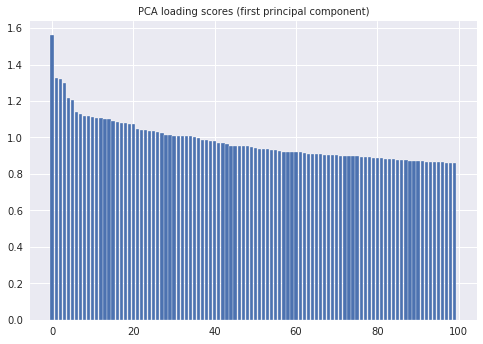

In [259]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=range(100), height=pc1_loadings['CorrelationWithPC1'][:100])
plt.title('PCA loading scores (first principal component)', size=10)
plt.show()

In [265]:
pc1_loadings.head(10)

Attribute  CorrelationWithPC1
0   23464378            1.561858
1   30250951            1.323784
2   27117897            1.320482
3   28336532            1.298034
4   30389635            1.214922
5   26902297            1.207015
6   21272371            1.142346
7   30336767            1.130886
8   27063377            1.120346
9   26852697            1.116241

In [263]:
importances = pd.DataFrame(data={
    'Attribute': pos,
    'Importance': lr.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

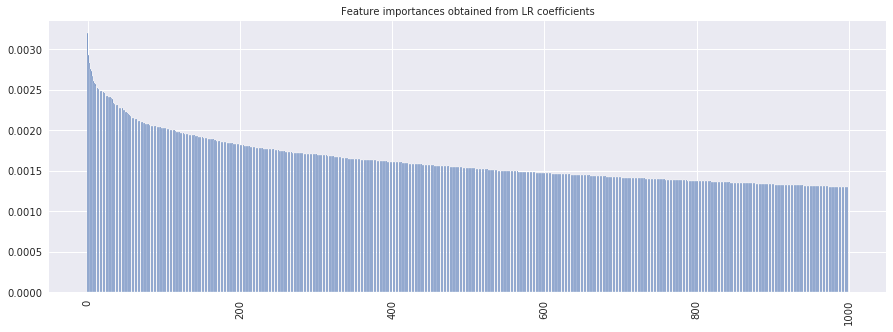

In [268]:
plt.figure(figsize=(15,5))
plt.bar(x=range(1000), height=importances['Importance'][:1000])
plt.title('Feature importances obtained from LR coefficients', size=10)
plt.xticks(rotation='vertical')
plt.show()

#### Row Sum of PCA loadings

In [269]:
component_sum = loadings.sum(axis=1)
component_sum.head(10)

46609    0.591527
48634   -0.988471
49078    0.138213
49448   -0.347043
50174    0.935846
51321    0.074756
52653   -2.408102
68502    0.641599
69500    0.676100
70029    1.207544
dtype: float64

In [271]:
# Sorted Row Sum
component_sum.sort_values(ascending=False).head(10)

8158845     5.021647
21454348    4.758976
31701009    4.546670
24620653    4.510589
26450256    4.474714
5141000     4.231206
9289314     4.216904
27966302    4.213657
27960521    4.211747
3494637     4.142069
dtype: float64

In [275]:
# Sorted Absolute Row Sum
components_absum = component_sum.abs().sort_values(ascending=False)
components_absum.head(10)

8158845     5.021647
19468526    4.992548
5151792     4.899084
20903938    4.881799
26716641    4.796021
5218680     4.773948
21454348    4.758976
7321631     4.721378
554053      4.551268
31701009    4.546670
dtype: float64

In [276]:
# 29920 SNPs with absolute sum of coeffs > 1
# We can attempt to train a classifier on these ?

len(components_absum.loc[components_absum > 1])

29920

In [293]:
components_absum.loc[components_absum > 1].tail(3)

22112383    1.000035
1149196     1.000018
4224773     1.000006
dtype: float64

Values of Coeffs across multiple components

In [285]:
# Contribution of SNP = 8158845 across components
loadings.loc[8158845].sort_values(ascending=False).head(10)

PC43    0.323813
PC30    0.282132
PC44    0.254644
PC39    0.233702
PC72    0.224531
PC53    0.222391
PC34    0.212942
PC5     0.208725
PC74    0.203116
PC77    0.199036
Name: 8158845, dtype: float64

In [295]:
# Contribution of SNP = 4224773 across components
loadings.loc[4224773].sort_values(ascending=False).head(10)

PC12    0.224971
PC41    0.186301
PC11    0.179123
PC46    0.173212
PC33    0.165076
PC37    0.148195
PC88    0.132505
PC78    0.127423
PC82    0.118327
PC79    0.115282
Name: 4224773, dtype: float64

Similar Analysis on complete dataset